## 학생 점수 예측 모델 구현

In [53]:
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.font_manager as fm

from sklearn.datasets import load_diabetes
from itertools import combinations
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, OneHotEncoder, LabelEncoder, OrdinalEncoder
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.preprocessing import PolynomialFeatures
from scipy import stats
from sklearnex import patch_sklearn
patch_sklearn()

In [54]:
# 폰트 파일의 경로 지정
font_path = r'C:\Windows\Fonts\gulim.ttc'

In [55]:
# matplotlib 패키지에 한글 폰트 설정
myFont = fm.FontProperties(fname = font_path).get_name()
mpl.rc('font', family = myFont)

### (1) student-mat.csv

#### 데이터 전처리 <hr>

In [56]:
file_data1 = '../DATA/student-mat.csv'

In [57]:
student_mathDF = pd.read_csv(file_data1, sep = ';')
student_mathDF.head()

school sex  age address famsize Pstatus  Medu  Fedu     Mjob      Fjob  ...  \
0     GP   F   18       U     GT3       A     4     4  at_home   teacher  ...   
1     GP   F   17       U     GT3       T     1     1  at_home     other  ...   
2     GP   F   15       U     LE3       T     1     1  at_home     other  ...   
3     GP   F   15       U     GT3       T     4     2   health  services  ...   
4     GP   F   16       U     GT3       T     3     3    other     other  ...   

  famrel freetime  goout  Dalc  Walc health absences  G1  G2  G3  
0      4        3      4     1     1      3        6   5   6   6  
1      5        3      3     1     1      3        4   5   5   6  
2      4        3      2     2     3      3       10   7   8  10  
3      3        2      2     1     1      5        2  15  14  15  
4      4        3      2     1     2      5        4   6  10  10  

[5 rows x 33 columns]

In [58]:
student_mathDF.shape

(395, 33)

In [59]:
student_mathDF.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395 entries, 0 to 394
Data columns (total 33 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   school      395 non-null    object
 1   sex         395 non-null    object
 2   age         395 non-null    int64 
 3   address     395 non-null    object
 4   famsize     395 non-null    object
 5   Pstatus     395 non-null    object
 6   Medu        395 non-null    int64 
 7   Fedu        395 non-null    int64 
 8   Mjob        395 non-null    object
 9   Fjob        395 non-null    object
 10  reason      395 non-null    object
 11  guardian    395 non-null    object
 12  traveltime  395 non-null    int64 
 13  studytime   395 non-null    int64 
 14  failures    395 non-null    int64 
 15  schoolsup   395 non-null    object
 16  famsup      395 non-null    object
 17  paid        395 non-null    object
 18  activities  395 non-null    object
 19  nursery     395 non-null    object
 20  higher    

In [60]:
# 결측값 없음
student_mathDF.isna().sum().sum()

0

In [61]:
# 수치형 데이터 피처의 고유값 개수
student_mathDF.select_dtypes('int').nunique()

age            8
Medu           5
Fedu           5
traveltime     4
studytime      4
failures       4
famrel         5
freetime       5
goout          5
Dalc           5
Walc           5
health         5
absences      34
G1            17
G2            17
G3            18
dtype: int64

In [62]:
# 범주형 데이터 피처의 고유값 개수
student_mathDF.select_dtypes('object').nunique()

school        2
sex           2
address       2
famsize       2
Pstatus       2
Mjob          5
Fjob          5
reason        4
guardian      3
schoolsup     2
famsup        2
paid          2
activities    2
nursery       2
higher        2
internet      2
romantic      2
dtype: int64

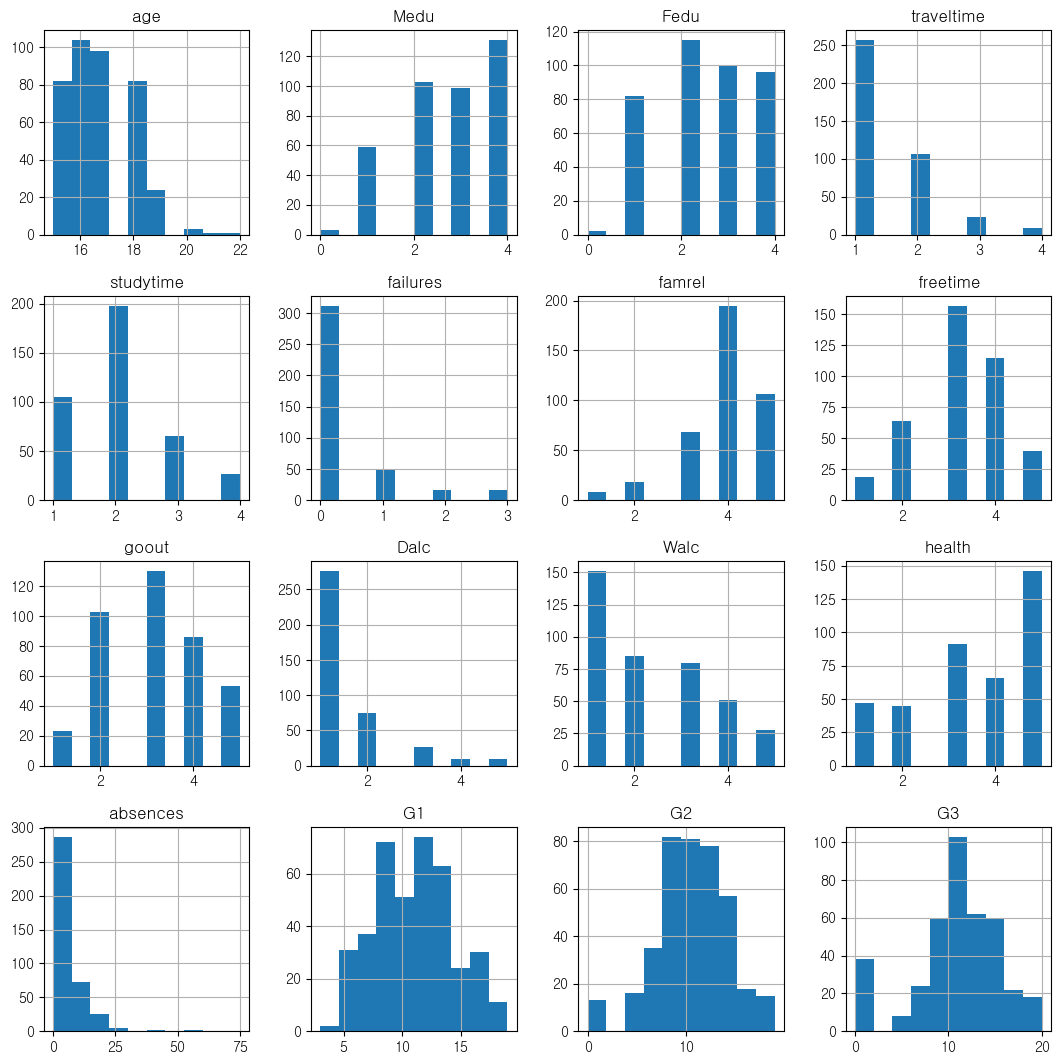

In [63]:
student_mathDF.hist(figsize = (13, 13))
plt.show()

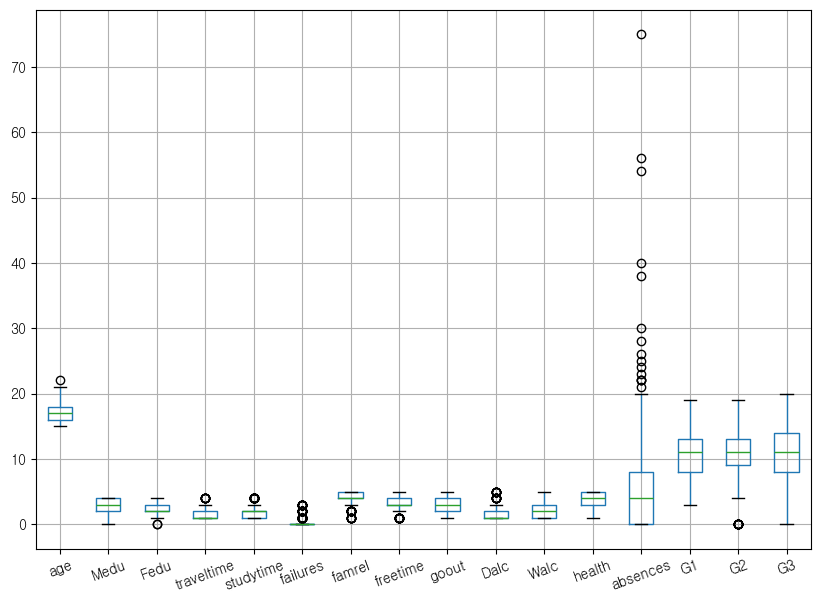

In [64]:
student_mathDF.boxplot(figsize = (10, 7), rot = 20)
plt.show()

In [65]:
numerical_dataDF = student_mathDF.select_dtypes('int')
numerical_dataDF.columns

Index(['age', 'Medu', 'Fedu', 'traveltime', 'studytime', 'failures', 'famrel',
       'freetime', 'goout', 'Dalc', 'Walc', 'health', 'absences', 'G1', 'G2',
       'G3'],
      dtype='object')

In [66]:
# Z-score 기반 이상치 탐지 함수

def find_outlier(column_list, scale = 3, df = student_mathDF):
    for col in column_list:
        mean_value = df[col].mean()
        std_value = df[col].std()

        base = scale
        z_data = (df[col] - mean_value) / std_value
        mask = z_data.abs() > base
        print(f'{col} 특성의 이상치 개수 : {z_data[mask].count()}개\n')

In [67]:
find_outlier(student_mathDF.select_dtypes('int').columns)

age 특성의 이상치 개수 : 0개
Medu 특성의 이상치 개수 : 0개
Fedu 특성의 이상치 개수 : 0개
traveltime 특성의 이상치 개수 : 8개
studytime 특성의 이상치 개수 : 0개
failures 특성의 이상치 개수 : 16개
famrel 특성의 이상치 개수 : 0개
freetime 특성의 이상치 개수 : 0개
goout 특성의 이상치 개수 : 0개
Dalc 특성의 이상치 개수 : 0개
Walc 특성의 이상치 개수 : 0개
health 특성의 이상치 개수 : 0개
absences 특성의 이상치 개수 : 0개
G1 특성의 이상치 개수 : 0개
G2 특성의 이상치 개수 : 0개
G3 특성의 이상치 개수 : 0개


In [68]:
student_mathDF['failures'].value_counts()

failures
0    312
1     50
2     17
3     16
Name: count, dtype: int64

In [69]:
def print_feature(nrows, ncols, target, features, corrs, df = student_mathDF):
    for idx in range(len(features)):
        plt.subplot(nrows, ncols, idx + 1)
        plt.scatter(df[target], df[features[idx]], label = f'corr : {corrs[idx]:.2}', color = 'cornflowerblue')
        plt.xlabel(target)
        plt.ylabel(features[idx])
        plt.legend()
    plt.tight_layout()
    plt.show()

In [70]:
# 수치형 데이터는 모두 순서형 데이터, 점수 데이터도 순서형으로 간주
student_mathDF.corr(method = 'spearman', numeric_only = True)

age      Medu      Fedu  traveltime  studytime  failures  \
age         1.000000 -0.161294 -0.149596    0.109804   0.031557  0.236464   
Medu       -0.161294  1.000000  0.631577   -0.147849   0.063498 -0.242373   
Fedu       -0.149596  0.631577  1.000000   -0.154454   0.018429 -0.236616   
traveltime  0.109804 -0.147849 -0.154454    1.000000  -0.105969  0.079917   
studytime   0.031557  0.063498  0.018429   -0.105969   1.000000 -0.157633   
failures    0.236464 -0.242373 -0.236616    0.079917  -0.157633  1.000000   
famrel      0.031380  0.012361  0.011400   -0.038656   0.058141 -0.051389   
freetime    0.000302  0.028493 -0.017132   -0.022279  -0.131321  0.088058   
goout       0.140131  0.064954  0.047961   -0.001430  -0.065979  0.105419   
Dalc        0.097073  0.022729  0.003994    0.066477  -0.217904  0.187492   
Walc        0.132799 -0.044332 -0.014486    0.063654  -0.264021  0.127912   
health     -0.075150 -0.035686  0.018113   -0.015452  -0.091497  0.079688   
absences    0.149276  0.097562  0.003568   -0.025061  -0.046180  0.096028   
G1         -0.057630  0.209662  0.194737   -0.085501   0.162286 -0.346052   
G2         -0.167622  0.236354  0.194844   -0.123795   0.129160 -0.362357   
G3         -0.173438  0.225036  0.170049   -0.120530   0.105170 -0.361224   

              famrel  freetime     goout      Dalc      Walc    health  \
age         0.031380  0.000302  0.140131  0.097073  0.132799 -0.075150   
Medu        0.012361  0.028493  0.064954  0.022729 -0.044332 -0.035686   
Fedu        0.011400 -0.017132  0.047961  0.003994 -0.014486  0.018113   
traveltime -0.038656 -0.022279 -0.001430  0.066477  0.063654 -0.015452   
studytime   0.058141 -0.131321 -0.065979 -0.217904 -0.264021 -0.091497   
failures   -0.051389  0.088058  0.105419  0.187492  0.127912  0.079688   
famrel      1.000000  0.143142  0.063549 -0.106338 -0.116060  0.085341   
freetime    0.143142  1.000000  0.285182  0.194223  0.130246  0.088975   
goout       0.063549  0.285182  1.000000  0.255146  0.393333 -0.018541   
Dalc       -0.106338  0.194223  0.255146  1.000000  0.639906  0.095139   
Walc       -0.116060  0.130246  0.393333  0.639906  1.000000  0.093625   
health      0.085341  0.088975 -0.018541  0.095139  0.093625  1.000000   
absences   -0.086577  0.013397  0.133280  0.129651  0.208508 -0.070132   
G1          0.026433  0.006973 -0.151636 -0.111438 -0.108368 -0.052224   
G2          0.008165 -0.016765 -0.160985 -0.110086 -0.109144 -0.050900   
G3          0.054977 -0.004994 -0.166119 -0.120944 -0.104459 -0.047790   

            absences        G1        G2        G3  
age         0.149276 -0.057630 -0.167622 -0.173438  
Medu        0.097562  0.209662  0.236354  0.225036  
Fedu        0.003568  0.194737  0.194844  0.170049  
traveltime -0.025061 -0.085501 -0.123795 -0.120530  
studytime  -0.046180  0.162286  0.129160  0.105170  
failures    0.096028 -0.346052 -0.362357 -0.361224  
famrel     -0.086577  0.026433  0.008165  0.054977  
freetime    0.013397  0.006973 -0.016765 -0.004994  
goout       0.133280 -0.151636 -0.160985 -0.166119  
Dalc        0.129651 -0.111438 -0.110086 -0.120944  
Walc        0.208508 -0.108368 -0.109144 -0.104459  
health     -0.070132 -0.052224 -0.050900 -0.047790  
absences    1.000000  0.004479 -0.033600  0.017731  
G1          0.004479  1.000000  0.894792  0.878001  
G2         -0.033600  0.894792  1.000000  0.957125  
G3          0.017731  0.878001  0.957125  1.000000

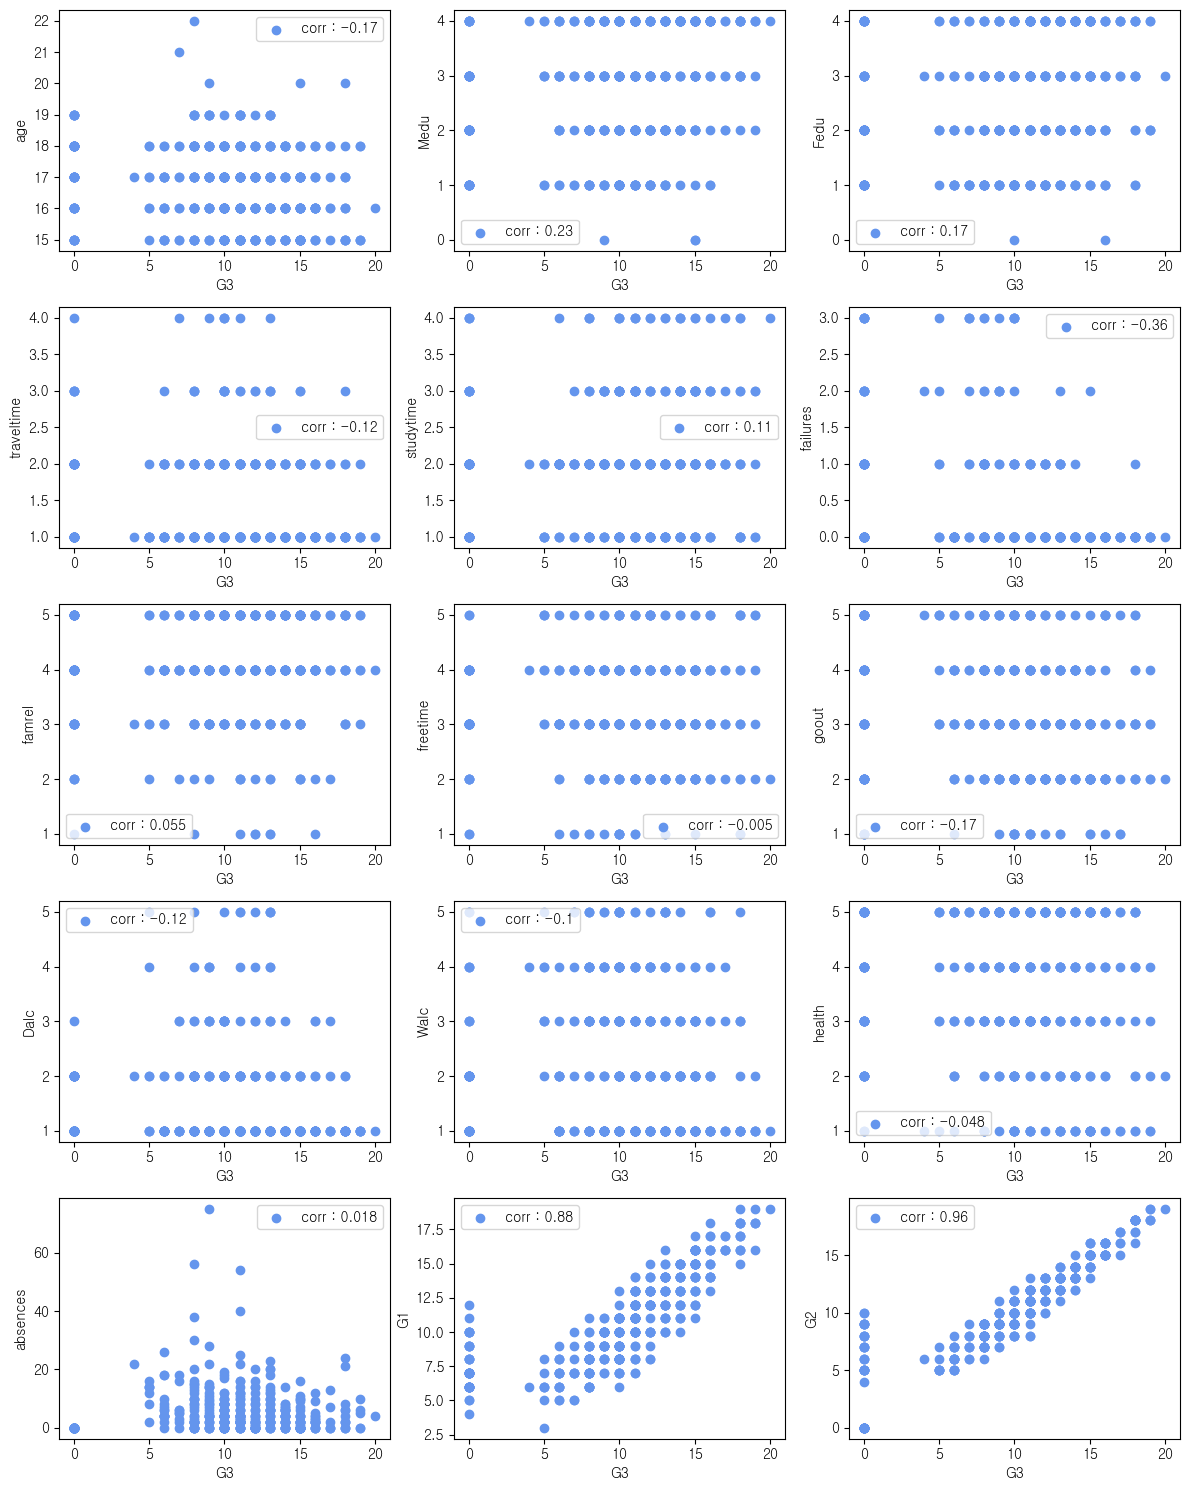

In [71]:
# 스피어만 상관계수
corrs = student_mathDF.corr(method = 'spearman', numeric_only = True)['G3'].to_list()
plt.figure(figsize = (12, 15))
print_feature(5, 3, 'G3', student_mathDF.select_dtypes('int').columns[:-1], corrs[:-1])
plt.show()

In [72]:
# 수치형 데이터는 모두 순서형 데이터, 점수 데이터도 순서형으로 간주
student_mathDF.corr(method = 'kendall', numeric_only = True)

age      Medu      Fedu  traveltime  studytime  failures  \
age         1.000000 -0.134240 -0.123585    0.096264   0.027854  0.210526   
Medu       -0.134240  1.000000  0.549376   -0.131298   0.054220 -0.215815   
Fedu       -0.123585  0.549376  1.000000   -0.137628   0.015513 -0.210886   
traveltime  0.096264 -0.131298 -0.137628    1.000000  -0.095972  0.075963   
studytime   0.027854  0.054220  0.015513   -0.095972   1.000000 -0.143786   
failures    0.210526 -0.215815 -0.210886    0.075963  -0.143786  1.000000   
famrel      0.026866  0.011335  0.009886   -0.035171   0.051512 -0.047422   
freetime    0.000360  0.023855 -0.013491   -0.019729  -0.114147  0.078560   
goout       0.114139  0.053642  0.040130   -0.001566  -0.059110  0.094453   
Dalc        0.084443  0.019858  0.003607    0.062254  -0.196779  0.174686   
Walc        0.107604 -0.037080 -0.011842    0.056763  -0.226298  0.113718   
health     -0.061793 -0.029315  0.014044   -0.013252  -0.076562  0.069952   
absences    0.117248  0.077151  0.002707   -0.020886  -0.037671  0.081123   
G1         -0.044300  0.162541  0.151514   -0.070626   0.131441 -0.286751   
G2         -0.129535  0.183938  0.153469   -0.101928   0.104742 -0.301646   
G3         -0.134471  0.174766  0.132405   -0.098996   0.085112 -0.299185   

              famrel  freetime     goout      Dalc      Walc    health  \
age         0.026866  0.000360  0.114139  0.084443  0.107604 -0.061793   
Medu        0.011335  0.023855  0.053642  0.019858 -0.037080 -0.029315   
Fedu        0.009886 -0.013491  0.040130  0.003607 -0.011842  0.014044   
traveltime -0.035171 -0.019729 -0.001566  0.062254  0.056763 -0.013252   
studytime   0.051512 -0.114147 -0.059110 -0.196779 -0.226298 -0.076562   
failures   -0.047422  0.078560  0.094453  0.174686  0.113718  0.069952   
famrel      1.000000  0.122849  0.054150 -0.096213 -0.099170  0.073315   
freetime    0.122849  1.000000  0.249585  0.172462  0.109379  0.075107   
goout       0.054150  0.249585  1.000000  0.224931  0.337090 -0.015041   
Dalc       -0.096213  0.172462  0.224931  1.000000  0.579557  0.082544   
Walc       -0.099170  0.109379  0.337090  0.579557  1.000000  0.075814   
health      0.073315  0.075107 -0.015041  0.082544  0.075814  1.000000   
absences   -0.070318  0.010776  0.108351  0.108427  0.167682 -0.055805   
G1          0.021300  0.005200 -0.118060 -0.089424 -0.084131 -0.039848   
G2          0.006465 -0.013646 -0.125315 -0.088973 -0.086137 -0.039020   
G3          0.044007 -0.003746 -0.130110 -0.097154 -0.082838 -0.036624   

            absences        G1        G2        G3  
age         0.117248 -0.044300 -0.129535 -0.134471  
Medu        0.077151  0.162541  0.183938  0.174766  
Fedu        0.002707  0.151514  0.153469  0.132405  
traveltime -0.020886 -0.070626 -0.101928 -0.098996  
studytime  -0.037671  0.131441  0.104742  0.085112  
failures    0.081123 -0.286751 -0.301646 -0.299185  
famrel     -0.070318  0.021300  0.006465  0.044007  
freetime    0.010776  0.005200 -0.013646 -0.003746  
goout       0.108351 -0.118060 -0.125315 -0.130110  
Dalc        0.108427 -0.089424 -0.088973 -0.097154  
Walc        0.167682 -0.084131 -0.086137 -0.082838  
health     -0.055805 -0.039848 -0.039020 -0.036624  
absences    1.000000  0.003462 -0.030355  0.003723  
G1          0.003462  1.000000  0.773459  0.746343  
G2         -0.030355  0.773459  1.000000  0.883518  
G3          0.003723  0.746343  0.883518  1.000000

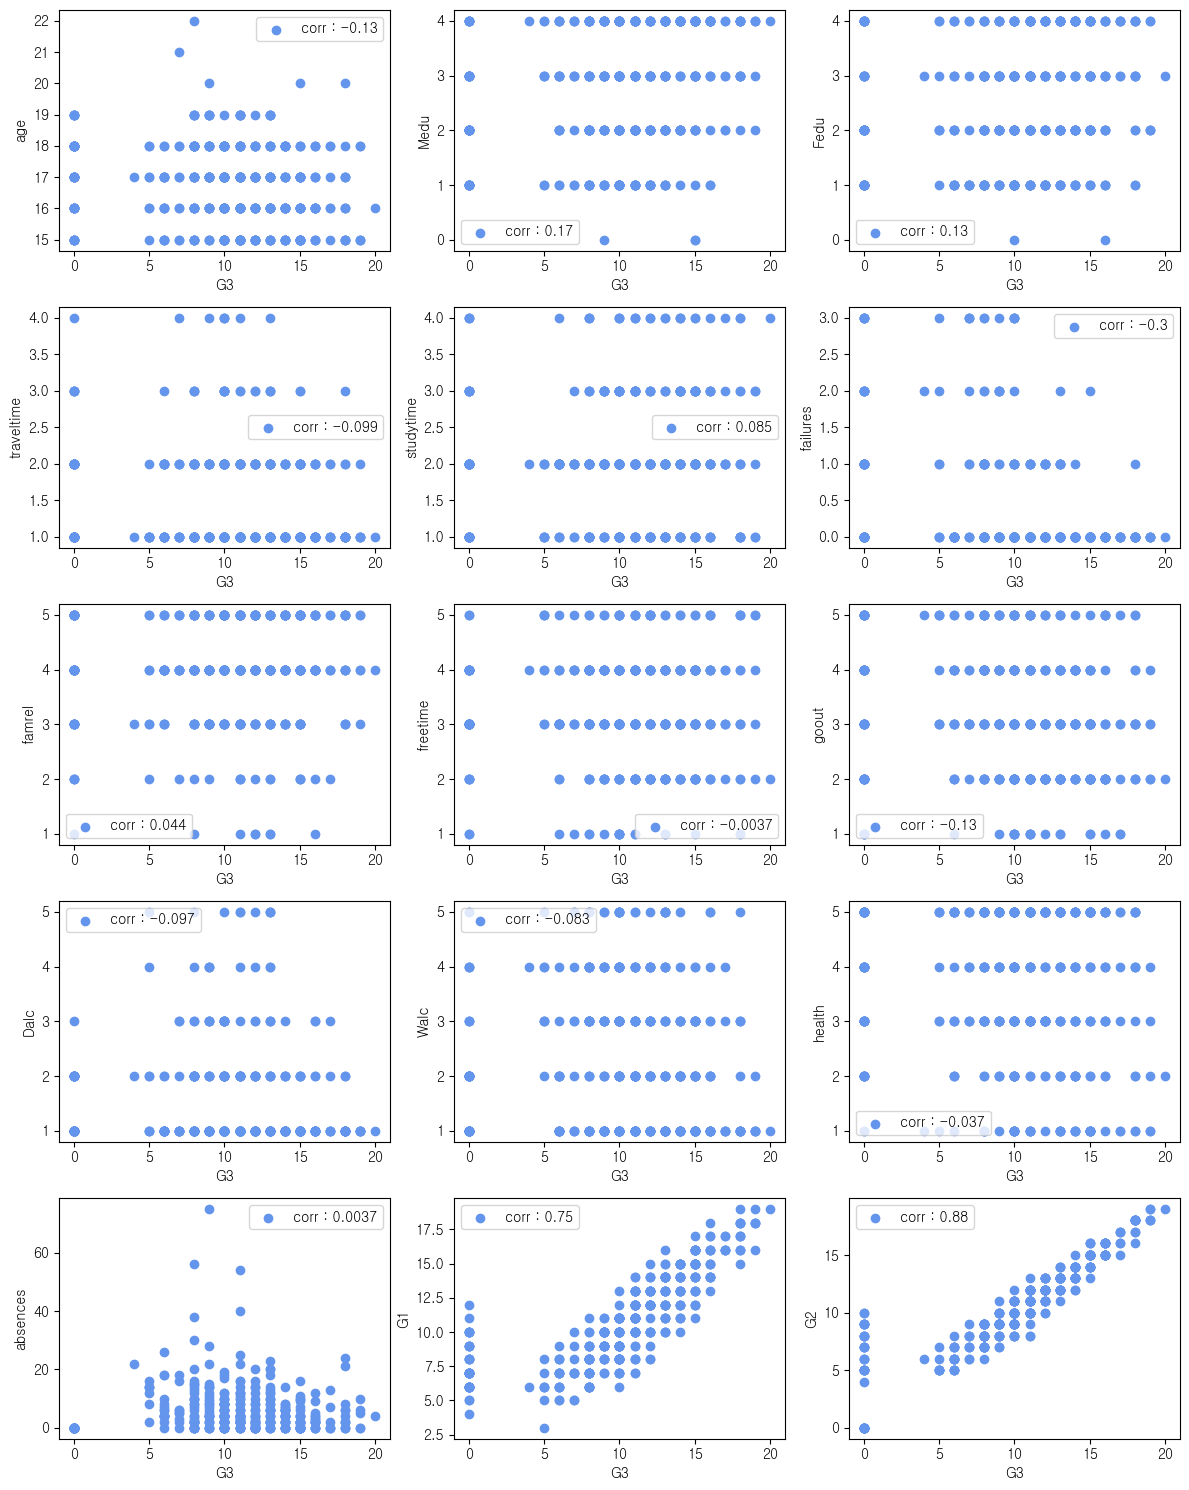

In [73]:
# 켄달 상관계수
corrs = student_mathDF.corr(method = 'kendall', numeric_only = True)['G3'].to_list()
plt.figure(figsize = (12, 15))
print_feature(5, 3, 'G3', student_mathDF.select_dtypes('int').columns[:-1], corrs[:-1])
plt.show()

In [74]:
categorical_dataDF = pd.concat([student_mathDF.select_dtypes('object'), student_mathDF.G3], axis = 1)
categorical_dataDF

school sex address famsize Pstatus      Mjob      Fjob  reason guardian  \
0       GP   F       U     GT3       A   at_home   teacher  course   mother   
1       GP   F       U     GT3       T   at_home     other  course   father   
2       GP   F       U     LE3       T   at_home     other   other   mother   
3       GP   F       U     GT3       T    health  services    home   mother   
4       GP   F       U     GT3       T     other     other    home   father   
..     ...  ..     ...     ...     ...       ...       ...     ...      ...   
390     MS   M       U     LE3       A  services  services  course    other   
391     MS   M       U     LE3       T  services  services  course   mother   
392     MS   M       R     GT3       T     other     other  course    other   
393     MS   M       R     LE3       T  services     other  course   mother   
394     MS   M       U     LE3       T     other   at_home  course   father   

    schoolsup famsup paid activities nursery higher internet romantic  G3  
0         yes     no   no         no     yes    yes       no       no   6  
1          no    yes   no         no      no    yes      yes       no   6  
2         yes     no  yes         no     yes    yes      yes       no  10  
3          no    yes  yes        yes     yes    yes      yes      yes  15  
4          no    yes  yes         no     yes    yes       no       no  10  
..        ...    ...  ...        ...     ...    ...      ...      ...  ..  
390        no    yes  yes         no     yes    yes       no       no   9  
391        no     no   no         no      no    yes      yes       no  16  
392        no     no   no         no      no    yes       no       no   7  
393        no     no   no         no      no    yes      yes       no  10  
394        no     no   no         no     yes    yes      yes       no   9  

[395 rows x 18 columns]

In [75]:
categorical_dataDF.nunique()

school         2
sex            2
address        2
famsize        2
Pstatus        2
Mjob           5
Fjob           5
reason         4
guardian       3
schoolsup      2
famsup         2
paid           2
activities     2
nursery        2
higher         2
internet       2
romantic       2
G3            18
dtype: int64

In [76]:
# 라벨 인코딩을 사용하여 범주형 데이터를 정수 데이터로 변환
for col in categorical_dataDF.columns[:-1]:
    le = LabelEncoder()
    new_data = le.fit_transform(categorical_dataDF[col])
    categorical_dataDF[col] = new_data

In [77]:
categorical_dataDF

school  sex  address  famsize  Pstatus  Mjob  Fjob  reason  guardian  \
0         0    0        1        0        0     0     4       0         1   
1         0    0        1        0        1     0     2       0         0   
2         0    0        1        1        1     0     2       2         1   
3         0    0        1        0        1     1     3       1         1   
4         0    0        1        0        1     2     2       1         0   
..      ...  ...      ...      ...      ...   ...   ...     ...       ...   
390       1    1        1        1        0     3     3       0         2   
391       1    1        1        1        1     3     3       0         1   
392       1    1        0        0        1     2     2       0         2   
393       1    1        0        1        1     3     2       0         1   
394       1    1        1        1        1     2     0       0         0   

     schoolsup  famsup  paid  activities  nursery  higher  internet  romantic  \
0            1       0     0           0        1       1         0         0   
1            0       1     0           0        0       1         1         0   
2            1       0     1           0        1       1         1         0   
3            0       1     1           1        1       1         1         1   
4            0       1     1           0        1       1         0         0   
..         ...     ...   ...         ...      ...     ...       ...       ...   
390          0       1     1           0        1       1         0         0   
391          0       0     0           0        0       1         1         0   
392          0       0     0           0        0       1         0         0   
393          0       0     0           0        0       1         1         0   
394          0       0     0           0        1       1         1         0   

     G3  
0     6  
1     6  
2    10  
3    15  
4    10  
..   ..  
390   9  
391  16  
392   7  
393  10  
394   9  

[395 rows x 18 columns]

In [78]:
stats.pointbiserialr(categorical_dataDF.school, categorical_dataDF.G3).statistic

-0.04501694311330676

In [79]:
coef_dict = {}
for col in categorical_dataDF.columns[:-1]:
    coef = stats.pointbiserialr(categorical_dataDF[col], categorical_dataDF.G3).statistic
    coef_dict[col] = coef
    print(f'{col}과 G3의 Biserial coef는 {coef}\n')

school과 G3의 Biserial coef는 -0.04501694311330676

sex과 G3의 Biserial coef는 0.10345564746639302

address과 G3의 Biserial coef는 0.10575606393084082

famsize과 G3의 Biserial coef는 0.0814071097725543

Pstatus과 G3의 Biserial coef는 -0.05800898495931131

Mjob과 G3의 Biserial coef는 0.10208179585171816

Fjob과 G3의 Biserial coef는 0.04228587254890655

reason과 G3의 Biserial coef는 0.1219941059181346

guardian과 G3의 Biserial coef는 -0.07010910043726755

schoolsup과 G3의 Biserial coef는 -0.08278821499316318

famsup과 G3의 Biserial coef는 -0.039157145237904645

paid과 G3의 Biserial coef는 0.10199624071669919

activities과 G3의 Biserial coef는 0.016099701295814367

nursery과 G3의 Biserial coef는 0.051567900910917584

higher과 G3의 Biserial coef는 0.18246461785815746

internet과 G3의 Biserial coef는 0.09848337126072924

romantic과 G3의 Biserial coef는 -0.12996995016345012



In [80]:
# 타겟과 각 특성의 스피어만 상관계수를 내림차순 정렬
np.sort(np.array(list(coef_dict.values())))[::-1]

array([ 0.18246462,  0.12199411,  0.10575606,  0.10345565,  0.1020818 ,
        0.10199624,  0.09848337,  0.08140711,  0.0515679 ,  0.04228587,
        0.0160997 , -0.03915715, -0.04501694, -0.05800898, -0.0701091 ,
       -0.08278821, -0.12996995])

#### 수치형 데이터만 추출하여 학습 <hr>

- LinearRegression으로 G1, G2를 활용한 학습

In [81]:
featureDF = student_mathDF.select_dtypes('int')[['G1', 'G2']]
#featureDF['G1G2mean'] = (featureDF['G1'] + featureDF['G2']*2) / 2
#featureDF['G1G2product'] = featureDF['G1'] * featureDF['G2']
targetSR = student_mathDF[student_mathDF.columns[-1]]
featureDF

G1  G2
0     5   6
1     5   5
2     7   8
3    15  14
4     6  10
..   ..  ..
390   9   9
391  14  16
392  10   8
393  11  12
394   8   9

[395 rows x 2 columns]

In [82]:
X_train, X_test, y_train, y_test = train_test_split(featureDF, targetSR, test_size = 0.2, random_state = 42)

# 피처 추가
poly = PolynomialFeatures(include_bias = False, degree = 2)
poly.fit(X_train)  # fit에 넣을 데이터는 2차원이어야 한다.
poly.transform(X_test)
poly_feature_names = poly.get_feature_names_out(['G1', 'G2'])
train_poly_data = poly.transform(X_train)
test_poly_data = poly.transform(X_test)
X_train = pd.DataFrame(train_poly_data, columns = poly_feature_names)
X_test = pd.DataFrame(test_poly_data, columns = poly_feature_names)

# 시험 두개의 점수는 스케일링 안하는게 나을수도?
scaler = StandardScaler()
scaler.fit(X_train)
scaled_X_train = scaler.transform(X_train)
scaled_X_test = scaler.transform(X_test)

model = LinearRegression()
model.fit(scaled_X_train, y_train)
model.score(scaled_X_train, y_train), model.score(scaled_X_test, y_test)

(0.8308888361502698, 0.789324680863324)

In [83]:
X_train, X_test, y_train, y_test = train_test_split(featureDF, targetSR, test_size = 0.2, random_state = 42)

# 피처 추가
poly = PolynomialFeatures(include_bias = False, degree = 2)
poly.fit(X_train)  # fit에 넣을 데이터는 2차원이어야 한다.
poly.transform(X_test)
poly_feature_names = poly.get_feature_names_out(['G1', 'G2'])
train_poly_data = poly.transform(X_train)
test_poly_data = poly.transform(X_test)
X_train = pd.DataFrame(train_poly_data, columns = poly_feature_names)
X_test = pd.DataFrame(test_poly_data, columns = poly_feature_names)

model = LinearRegression()
model.fit(scaled_X_train, y_train)
model.score(scaled_X_train, y_train), model.score(scaled_X_test, y_test)

(0.8308888361502698, 0.789324680863324)

In [84]:
X_train, X_test, y_train, y_test = train_test_split(featureDF, targetSR, test_size = 0.2, random_state = 42)

# 피처 추가 안하는게 결과가 더 좋다.
# 참고로 시험 두개('G1', 'G2')의 점수는 스케일링 안해도 결과는 같다.
scaler = StandardScaler()
scaler.fit(X_train)
scaled_X_train = scaler.transform(X_train)
scaled_X_test = scaler.transform(X_test)
model = LinearRegression()
model.fit(scaled_X_train, y_train)
model.score(scaled_X_train, y_train), model.score(scaled_X_test, y_test)

(0.8283189161444509, 0.7945936216805897)

- LinearRegression으로 G1, G2 그리고 그 외의 피처를 활용한 학습

In [85]:
student_mathDF.columns

Index(['school', 'sex', 'age', 'address', 'famsize', 'Pstatus', 'Medu', 'Fedu',
       'Mjob', 'Fjob', 'reason', 'guardian', 'traveltime', 'studytime',
       'failures', 'schoolsup', 'famsup', 'paid', 'activities', 'nursery',
       'higher', 'internet', 'romantic', 'famrel', 'freetime', 'goout', 'Dalc',
       'Walc', 'health', 'absences', 'G1', 'G2', 'G3'],
      dtype='object')

In [86]:
student_mathDF.age.nunique()

8

In [87]:
featureDF = student_mathDF.select_dtypes('int')[['failures', 'Medu', 'Fedu', 'G1', 'G2']]
targetSR = student_mathDF[student_mathDF.columns[-1]]
featureDF

failures  Medu  Fedu  G1  G2
0           0     4     4   5   6
1           0     1     1   5   5
2           3     1     1   7   8
3           0     4     2  15  14
4           0     3     3   6  10
..        ...   ...   ...  ..  ..
390         2     2     2   9   9
391         0     3     1  14  16
392         3     1     1  10   8
393         0     3     2  11  12
394         0     1     1   8   9

[395 rows x 5 columns]

In [88]:
X_train, X_test, y_train, y_test = train_test_split(featureDF, targetSR, test_size = 0.2, random_state = 42)

# 피처 추가
poly = PolynomialFeatures(include_bias = False, degree = 2)
poly.fit(X_train)  # fit에 넣을 데이터는 2차원이어야 한다.
poly.transform(X_test)
poly_feature_names = poly.get_feature_names_out(['failures', 'Medu', 'Fedu', 'G1', 'G2'])
train_poly_data = poly.transform(X_train)
test_poly_data = poly.transform(X_test)
X_train = pd.DataFrame(train_poly_data, columns = poly_feature_names)
X_test = pd.DataFrame(test_poly_data, columns = poly_feature_names)

scaler = StandardScaler()
scaler.fit(X_train)
scaled_X_train = scaler.transform(X_train)
scaled_X_test = scaler.transform(X_test)
model = LinearRegression()
model.fit(scaled_X_train, y_train)
model.score(scaled_X_train, y_train), model.score(scaled_X_test, y_test)

(0.8460100528279975, 0.767495221517076)

In [89]:
# 특정 피처에 10을 더하여 점수 데이터 값과 비슷하게 한다.
featureDF['Fedu'] = featureDF['failures'] + 10
featureDF['Fedu'] = featureDF['Medu'] + 10
featureDF['Fedu'] = featureDF['Fedu'] + 10
X_train, X_test, y_train, y_test = train_test_split(featureDF, targetSR, test_size = 0.2, random_state = 42)

scaler = StandardScaler()
scaler.fit(X_train)
scaled_X_train = scaler.transform(X_train)
scaled_X_test = scaler.transform(X_test)
model = LinearRegression()
model.fit(scaled_X_train, y_train)
model.score(scaled_X_train, y_train), model.score(scaled_X_test, y_test)

(0.8327410193486652, 0.7787721591918746)

In [90]:
featureDF = student_mathDF.select_dtypes('int')[['failures', 'Medu', 'Fedu', 'G1', 'G2']]
targetSR = student_mathDF[student_mathDF.columns[-1]]
featureDF

X_train, X_test, y_train, y_test = train_test_split(featureDF, targetSR, test_size = 0.2, random_state = 42)

scaler = StandardScaler()
scaler.fit(X_train)
scaled_X_train = scaler.transform(X_train)
scaled_X_test = scaler.transform(X_test)
model = LinearRegression()
model.fit(scaled_X_train, y_train)
model.score(scaled_X_train, y_train), model.score(scaled_X_test, y_test)

(0.8338928042855999, 0.7759174061850449)

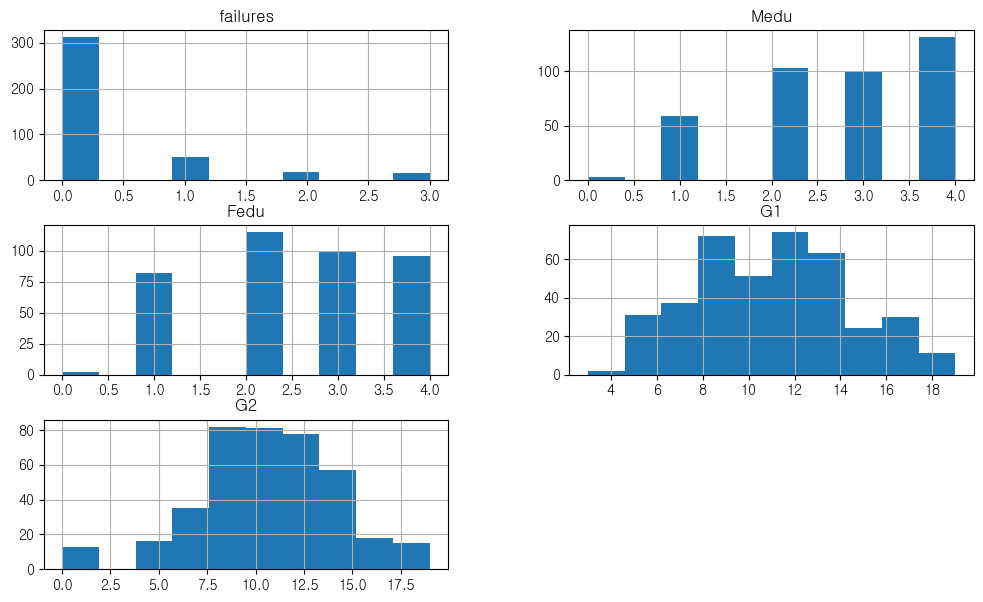

In [91]:
featureDF.hist(figsize = (12, 7))
plt.show()

In [92]:
featureDF = student_mathDF.select_dtypes('int')[['Fedu', 'G1', 'G2']]
targetSR = student_mathDF[student_mathDF.columns[-1]]
X_train, X_test, y_train, y_test = train_test_split(featureDF, targetSR, test_size = 0.2, random_state = 42)

# 피처 추가
poly = PolynomialFeatures(include_bias = False, degree = 2)
poly.fit(X_train)  # fit에 넣을 데이터는 2차원이어야 한다.
poly.transform(X_test)
poly_feature_names = poly.get_feature_names_out(['Fedu', 'G1', 'G2'])
train_poly_data = poly.transform(X_train)
test_poly_data = poly.transform(X_test)
X_train = pd.DataFrame(train_poly_data, columns = poly_feature_names)
X_test = pd.DataFrame(test_poly_data, columns = poly_feature_names)

scaler = StandardScaler()
scaler.fit(X_train)
scaled_X_train = scaler.transform(X_train)
scaled_X_test = scaler.transform(X_test)
model = LinearRegression()
model.fit(scaled_X_train, y_train)
model.score(scaled_X_train, y_train), model.score(scaled_X_test, y_test)

(0.8321114221977726, 0.7867061627727312)

In [93]:
featureDF = student_mathDF.select_dtypes('int')[['Fedu', 'G1', 'G2']]
targetSR = student_mathDF[student_mathDF.columns[-1]]

# 특정 피처에 10을 더하여 점수 데이터 값과 비슷하게 한다.
featureDF['Fedu'] = featureDF['Fedu'] + 10

X_train, X_test, y_train, y_test = train_test_split(featureDF, targetSR, test_size = 0.2, random_state = 42)

scaler = StandardScaler()
scaler.fit(X_train)
scaled_X_train = scaler.transform(X_train)
scaled_X_test = scaler.transform(X_test)
model = LinearRegression()
model.fit(scaled_X_train, y_train)
model.score(scaled_X_train, y_train), model.score(scaled_X_test, y_test)

(0.8283673746821071, 0.794322154501693)

In [94]:
featureDF = student_mathDF.select_dtypes('int')[['failures', 'G1', 'G2']]
targetSR = student_mathDF[student_mathDF.columns[-1]]

# 특정 피처에 10을 더하여 점수 데이터 값과 비슷하게 한다.
featureDF['failures'] = featureDF['failures'] + 10

X_train, X_test, y_train, y_test = train_test_split(featureDF, targetSR, test_size = 0.2, random_state = 42)

scaler = StandardScaler()
scaler.fit(X_train)
scaled_X_train = scaler.transform(X_train)
scaled_X_test = scaler.transform(X_test)
model = LinearRegression()
model.fit(scaled_X_train, y_train)
model.score(scaled_X_train, y_train), model.score(scaled_X_test, y_test)

(0.8326443459579528, 0.7781593468996446)

In [95]:
numerical_dataDF = student_mathDF.select_dtypes('int')
featureDF = numerical_dataDF[['failures', 'Medu', 'Fedu', 'G1', 'G2']]
targetSR = student_mathDF[student_mathDF.columns[-1]]
X_train, X_test, y_train, y_test = train_test_split(featureDF, targetSR, test_size = 0.2, random_state = 42)

# 피처 추가
poly = PolynomialFeatures(include_bias = False, degree = 2)
poly.fit(X_train)  # fit에 넣을 데이터는 2차원이어야 한다.
poly.transform(X_test)
poly_feature_names = poly.get_feature_names_out(['failures', 'Medu', 'Fedu', 'G1', 'G2'])
train_poly_data = poly.transform(X_train)
test_poly_data = poly.transform(X_test)
X_train = pd.DataFrame(train_poly_data, columns = poly_feature_names)
X_test = pd.DataFrame(test_poly_data, columns = poly_feature_names)

X_train

failures  Medu  Fedu    G1    G2  failures^2  failures Medu  \
0         0.0   3.0   3.0  12.0  13.0         0.0            0.0   
1         0.0   2.0   3.0  13.0  14.0         0.0            0.0   
2         3.0   1.0   3.0   8.0   7.0         9.0            3.0   
3         0.0   4.0   3.0  10.0   9.0         0.0            0.0   
4         0.0   2.0   1.0   8.0   9.0         0.0            0.0   
..        ...   ...   ...   ...   ...         ...            ...   
311       0.0   4.0   2.0  10.0  10.0         0.0            0.0   
312       0.0   2.0   2.0   7.0   8.0         0.0            0.0   
313       2.0   3.0   3.0   9.0   9.0         4.0            6.0   
314       0.0   4.0   3.0  13.0  15.0         0.0            0.0   
315       0.0   4.0   4.0  10.0  13.0         0.0            0.0   

     failures Fedu  failures G1  failures G2  Medu^2  Medu Fedu  Medu G1  \
0              0.0          0.0          0.0     9.0        9.0     36.0   
1              0.0          0.0          0.0     4.0        6.0     26.0   
2              9.0         24.0         21.0     1.0        3.0      8.0   
3              0.0          0.0          0.0    16.0       12.0     40.0   
4              0.0          0.0          0.0     4.0        2.0     16.0   
..             ...          ...          ...     ...        ...      ...   
311            0.0          0.0          0.0    16.0        8.0     40.0   
312            0.0          0.0          0.0     4.0        4.0     14.0   
313            6.0         18.0         18.0     9.0        9.0     27.0   
314            0.0          0.0          0.0    16.0       12.0     52.0   
315            0.0          0.0          0.0    16.0       16.0     40.0   

     Medu G2  Fedu^2  Fedu G1  Fedu G2   G1^2  G1 G2   G2^2  
0       39.0     9.0     36.0     39.0  144.0  156.0  169.0  
1       28.0     9.0     39.0     42.0  169.0  182.0  196.0  
2        7.0     9.0     24.0     21.0   64.0   56.0   49.0  
3       36.0     9.0     30.0     27.0  100.0   90.0   81.0  
4       18.0     1.0      8.0      9.0   64.0   72.0   81.0  
..       ...     ...      ...      ...    ...    ...    ...  
311     40.0     4.0     20.0     20.0  100.0  100.0  100.0  
312     16.0     4.0     14.0     16.0   49.0   56.0   64.0  
313     27.0     9.0     27.0     27.0   81.0   81.0   81.0  
314     60.0     9.0     39.0     45.0  169.0  195.0  225.0  
315     52.0    16.0     40.0     52.0  100.0  130.0  169.0  

[316 rows x 20 columns]

In [120]:
# scaler에 따른 점수 반환 함수
def score_return(feature, target, my_scaler, degree, my_model = LinearRegression(), test_size = 0.2, random_state = 42, df = student_mathDF):
    
    numerical_dataDF = df.select_dtypes('int')
    featureDF = numerical_dataDF[feature]
    targetSR = student_mathDF[target]
    X_train, X_test, y_train, y_test = train_test_split(featureDF, targetSR, test_size = test_size, random_state = random_state)
    
    # 피처 추가
    poly = PolynomialFeatures(include_bias = False, degree = degree)
    poly.fit(X_train)  # fit에 넣을 데이터는 2차원이어야 한다.
    poly.transform(X_test)
    poly_feature_names = poly.get_feature_names_out(feature)
    train_poly_data = poly.transform(X_train)
    test_poly_data = poly.transform(X_test)
    X_train = pd.DataFrame(train_poly_data, columns = poly_feature_names)
    X_test = pd.DataFrame(test_poly_data, columns = poly_feature_names)

    ct = ColumnTransformer([('scaling', my_scaler, X_train.columns[3:])], remainder = 'passthrough')
    ct.fit(X_train)
    scaled_X_train = ct.transform(X_train)
    scaled_X_test = ct.transform(X_test)
    
    my_model.fit(scaled_X_train, y_train)
    return round(my_model.score(scaled_X_train, y_train), 2), round(my_model.score(scaled_X_test, y_test), 2)

    # poly = PolynomialFeatures(include_bias = False, degree = degree)
    # poly.fit(df[feature])  # fit에 넣을 데이터는 2차원이어야 한다.
    # poly_data = poly.transform(df[feature])
    # poly_feature_names = poly.get_feature_names_out(feature)
    # new_df = pd.DataFrame(poly_data, columns = poly_feature_names)
    # new_df = pd.concat([new_df, df[['cylinders', 'model year', 'origin']]], axis = 1)
    # new_df = pd.concat([new_df, df[target]], axis = 1)
    # featureDF = new_df[new_df.columns[:-1]]
    # targetDF = new_df[target] 

In [121]:
score_return(['failures', 'Medu', 'Fedu', 'G1', 'G2'], 'G3', RobustScaler(), 2)

(0.85, 0.77)

In [122]:
# LinearRegression 학습
def main(start_degree, end_degree):
    degree_list = list(range(start_degree, end_degree + 1))
    for scaler in [StandardScaler(), MinMaxScaler(), RobustScaler()]:
        for degree in degree_list:
            train_score = score_return(['failures', 'Medu', 'Fedu', 'G1', 'G2'], 'G3', scaler, degree)[0]
            test_score = score_return(['failures', 'Medu', 'Fedu', 'G1', 'G2'], 'G3', scaler, degree)[1]
            print(f'degree가 {degree}일 때 ===>\n')
            print(f'{scaler} => Train Score : {train_score} --- Test Score : {test_score}\n')

main(2, 4)

degree가 2일 때 ===>

StandardScaler() => Train Score : 0.85 --- Test Score : 0.77

degree가 3일 때 ===>

StandardScaler() => Train Score : 0.87 --- Test Score : 0.75

degree가 4일 때 ===>

StandardScaler() => Train Score : 0.92 --- Test Score : -9.19

degree가 2일 때 ===>

MinMaxScaler() => Train Score : 0.85 --- Test Score : 0.77

degree가 3일 때 ===>

MinMaxScaler() => Train Score : 0.87 --- Test Score : 0.75

degree가 4일 때 ===>

MinMaxScaler() => Train Score : 0.92 --- Test Score : -9.19

degree가 2일 때 ===>

RobustScaler() => Train Score : 0.85 --- Test Score : 0.77

degree가 3일 때 ===>

RobustScaler() => Train Score : 0.87 --- Test Score : 0.75

degree가 4일 때 ===>

RobustScaler() => Train Score : 0.92 --- Test Score : -9.19



- KneighborsRegressor로 피처 'G1', 'G2'를 활용한 학습

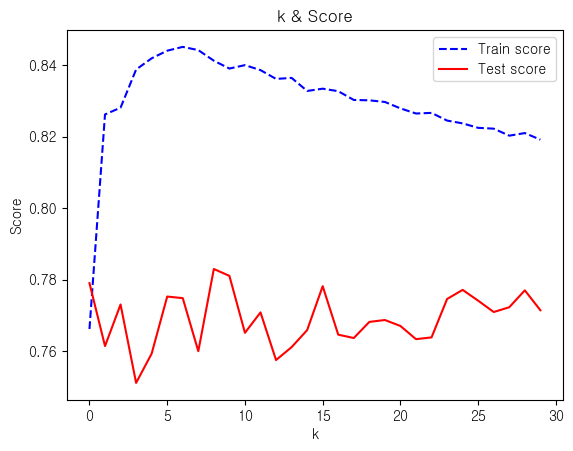

최적의 이웃 개수 k = 9


In [99]:
numerical_dataDF = student_mathDF.select_dtypes('int')
featureDF = numerical_dataDF[['G1', 'G2']]
targetSR = student_mathDF[student_mathDF.columns[-1]]

X_train, X_test, y_train, y_test = train_test_split(featureDF, targetSR, test_size = 0.2, random_state = 42)
max_k = 30
train_scoreList = []
test_scoreList = []
for k in range(1, max_k + 1):
    model = KNeighborsRegressor(n_neighbors = k)
    model.fit(X_train, y_train)
    train_scoreList.append(model.score(X_train, y_train))
    test_scoreList.append(model.score(X_test, y_test))

# k에 따른 학습용/테스트용 점수 시각화
plt.plot(train_scoreList, 'b--', label = 'Train score')
plt.plot(test_scoreList, 'r', label = 'Test score')
plt.title('k & Score')
plt.xlabel('k')
plt.ylabel('Score')
plt.legend()
plt.show()

print(f'최적의 이웃 개수 k = {test_scoreList.index(max(test_scoreList))+1}')

In [100]:
model = KNeighborsRegressor(n_neighbors = 9)
model.fit(scaled_X_train, y_train)
model.score(scaled_X_train, y_train), model.score(scaled_X_test, y_test)

(0.8329618287690725, 0.7702645601873559)

- KneighborsRegressor로 피처 'G1', 'G2'와 다른 피처를 추가하여 활용한 학습

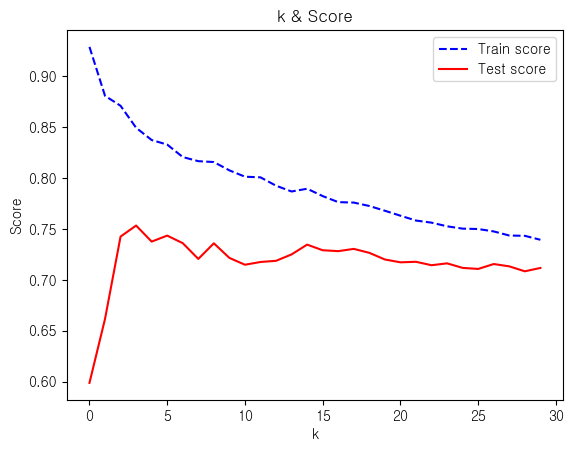

최적의 이웃 개수 k = 4


(0.7822822170926569, 0.7290701591461414)

In [101]:
numerical_dataDF = student_mathDF.select_dtypes('int')
featureDF = numerical_dataDF[['failures', 'Medu', 'Fedu', 'G1', 'G2']]
targetSR = student_mathDF[student_mathDF.columns[-1]]

X_train, X_test, y_train, y_test = train_test_split(featureDF, targetSR, test_size = 0.2, random_state = 42)

# 수치형 데이터는 표준 정규화, 범주형 데이터는 라벨 인코딩 처리
ct = ColumnTransformer([('scaling', StandardScaler(), ['G1', 'G2'])], remainder = 'passthrough')
ct.fit(X_train)
scaled_X_train = ct.transform(X_train)
scaled_X_test = ct.transform(X_test)

max_k = 30
train_scoreList = []
test_scoreList = []
for k in range(1, max_k + 1):
    model = KNeighborsRegressor(n_neighbors = k)
    model.fit(scaled_X_train, y_train)
    train_scoreList.append(model.score(scaled_X_train, y_train))
    test_scoreList.append(model.score(scaled_X_test, y_test))

# k에 따른 학습용/테스트용 점수 시각화
plt.plot(train_scoreList, 'b--', label = 'Train score')
plt.plot(test_scoreList, 'r', label = 'Test score')
plt.title('k & Score')
plt.xlabel('k')
plt.ylabel('Score')
plt.legend()
plt.show()

print(f'최적의 이웃 개수 k = {test_scoreList.index(max(test_scoreList))+1}')

model = KNeighborsRegressor(n_neighbors = 16)
model.fit(scaled_X_train, y_train)
model.score(scaled_X_train, y_train), model.score(scaled_X_test, y_test)

In [102]:
# scaler에 따른 점수 반환 함수
def score_return(feature, target, my_scaler, max_k, weights = 'uniform', metric = 'minkowski', my_model = KNeighborsRegressor(),
                 test_size = 0.2, random_state = 42, df = student_mathDF):
    
    numerical_dataDF = df.select_dtypes('int')
    featureDF = numerical_dataDF[feature]
    targetSR = student_mathDF[target]
    
    X_train, X_test, y_train, y_test = train_test_split(featureDF, targetSR, test_size = test_size, random_state = random_state)

    # 수치형 데이터는 표준 정규화, 범주형 데이터는 라벨 인코딩 처리
    ct = ColumnTransformer([('scaling', my_scaler, ['G1', 'G2'])], remainder = 'passthrough')
    ct.fit(X_train)
    scaled_X_train = ct.transform(X_train)
    scaled_X_test = ct.transform(X_test)

    if my_model.__class__ == KNeighborsRegressor:
        train_scoreList = []
        test_scoreList = []
        for k in range(1, max_k + 1):
            model = KNeighborsRegressor(n_neighbors = k)
            model.fit(scaled_X_train, y_train)
            train_scoreList.append(model.score(scaled_X_train, y_train))
            test_scoreList.append(model.score(scaled_X_test, y_test))
        
        # k에 따른 학습용/테스트용 점수 시각화
        plt.plot(train_scoreList, 'b--', label = 'Train score')
        plt.plot(test_scoreList, 'r', label = 'Test score')
        plt.title('k & Score')
        plt.xlabel('k')
        plt.ylabel('Score')
        plt.legend()
        plt.show()

        print(f'최적의 이웃 개수 k = {test_scoreList.index(max(test_scoreList))+1}')
        model = KNeighborsRegressor(n_neighbors = test_scoreList.index(max(test_scoreList))+1, weights = weights, metric = metric)
        model.fit(scaled_X_train, y_train)
        return round(model.score(scaled_X_train, y_train), 2), round(model.score(scaled_X_test, y_test), 2)

    else:
        my_model.fit(scaled_X_train, y_train)
        return round(my_model.score(scaled_X_train, y_train), 2), round(my_model.score(scaled_X_test, y_test), 2)

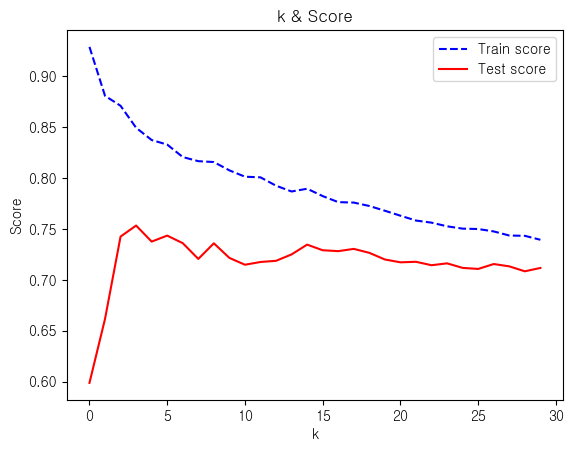

최적의 이웃 개수 k = 4


(0.96, 0.77)

In [103]:
score_return(['failures', 'Medu', 'Fedu', 'G1', 'G2'], 'G3',
             StandardScaler(), 30, weights = 'distance', metric = 'minkowski', my_model = KNeighborsRegressor())

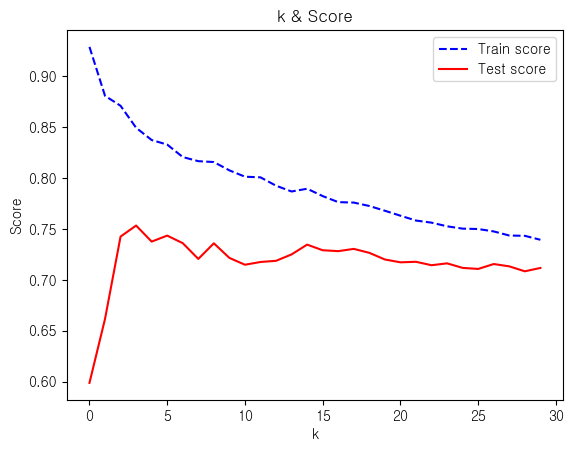

최적의 이웃 개수 k = 4


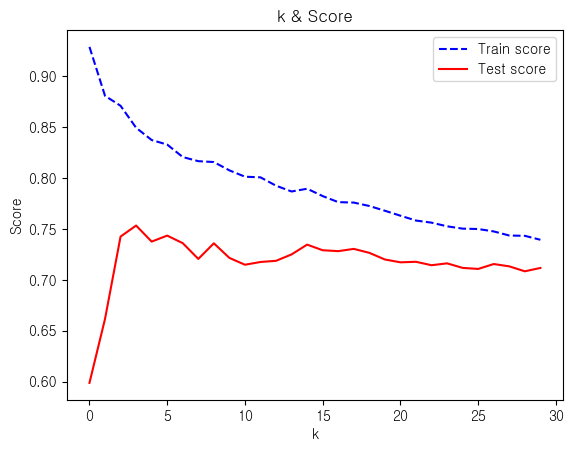

최적의 이웃 개수 k = 4
weight : uniform, metric : cityblock일 때 ===>

StandardScaler() => Train Score : 0.86 --- Test Score : 0.75



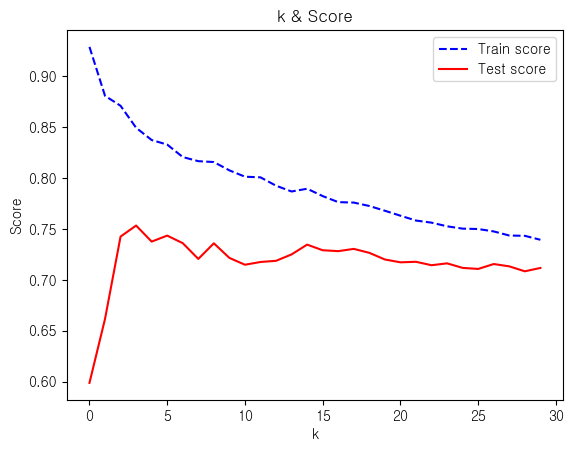

최적의 이웃 개수 k = 4


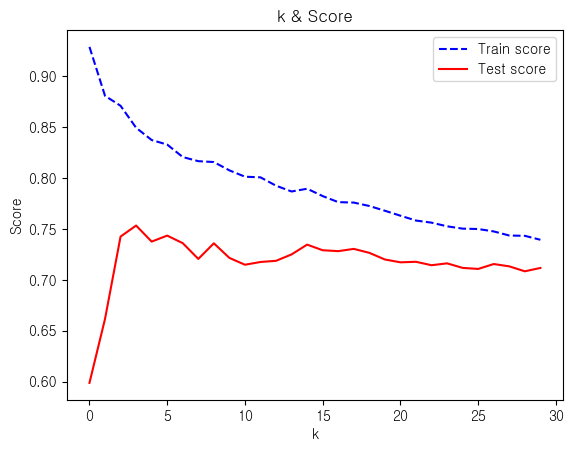

최적의 이웃 개수 k = 4
weight : uniform, metric : cosine일 때 ===>

StandardScaler() => Train Score : 0.84 --- Test Score : 0.66



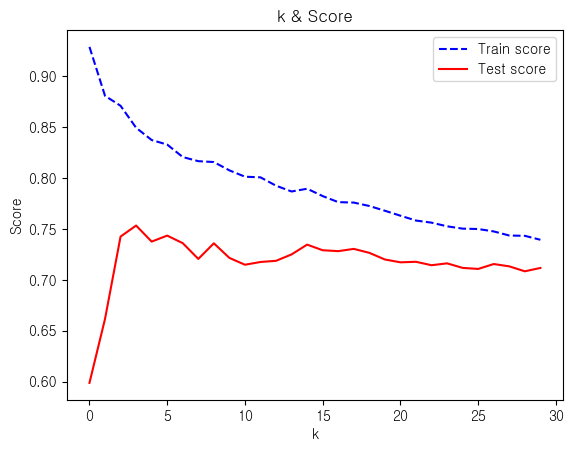

최적의 이웃 개수 k = 4


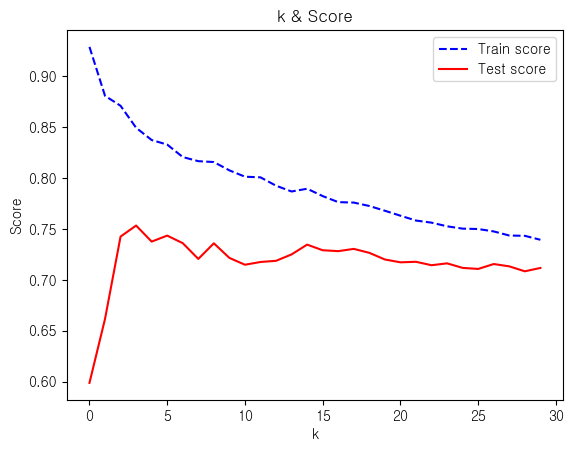

최적의 이웃 개수 k = 4
weight : uniform, metric : euclidean일 때 ===>

StandardScaler() => Train Score : 0.85 --- Test Score : 0.75



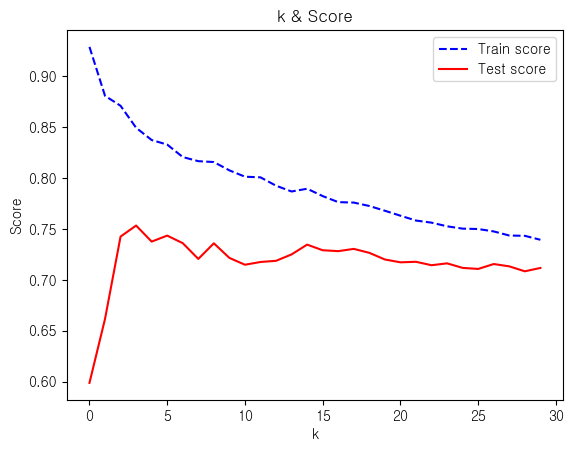

최적의 이웃 개수 k = 4


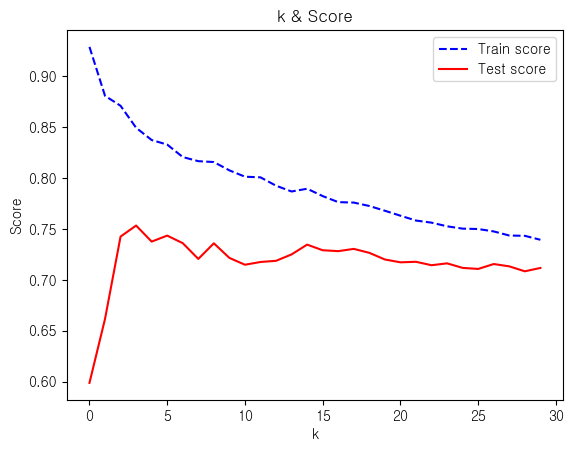

최적의 이웃 개수 k = 4
weight : uniform, metric : l1일 때 ===>

StandardScaler() => Train Score : 0.86 --- Test Score : 0.75



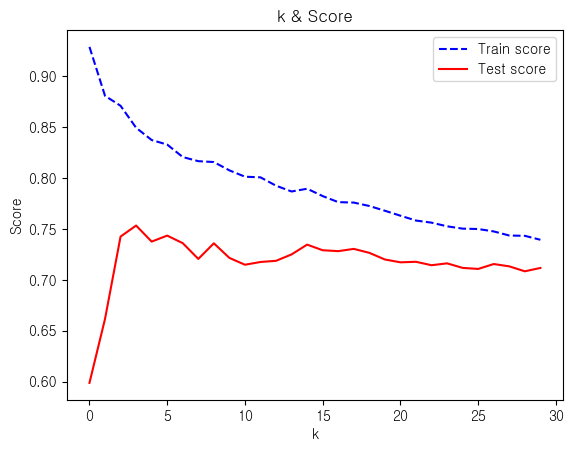

최적의 이웃 개수 k = 4


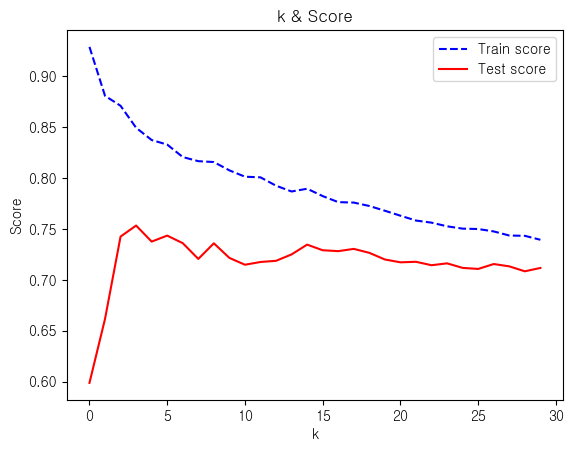

최적의 이웃 개수 k = 4
weight : uniform, metric : l2일 때 ===>

StandardScaler() => Train Score : 0.85 --- Test Score : 0.75



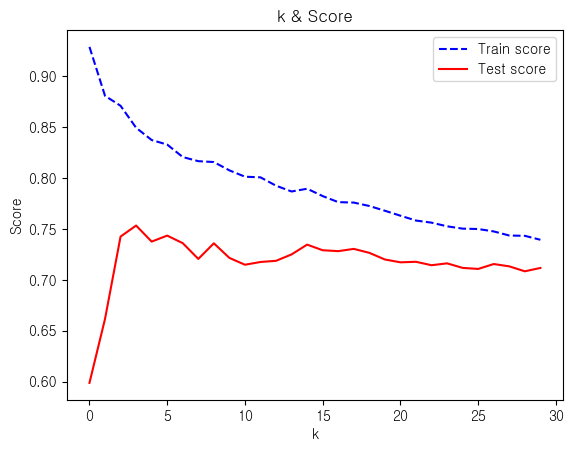

최적의 이웃 개수 k = 4


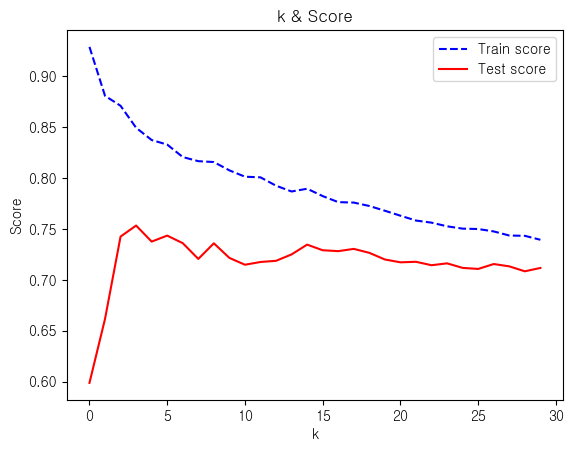

최적의 이웃 개수 k = 4
weight : uniform, metric : manhattan일 때 ===>

StandardScaler() => Train Score : 0.86 --- Test Score : 0.75



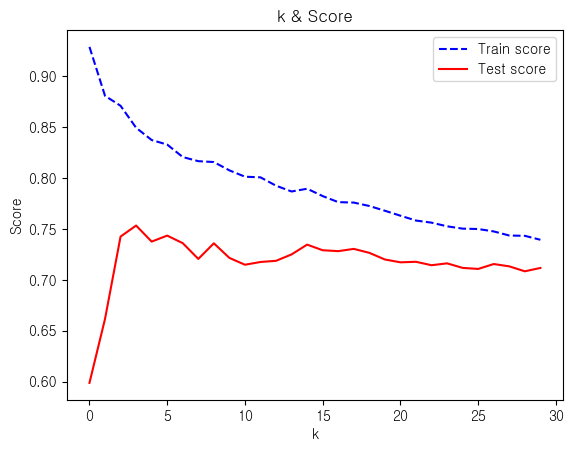

최적의 이웃 개수 k = 4


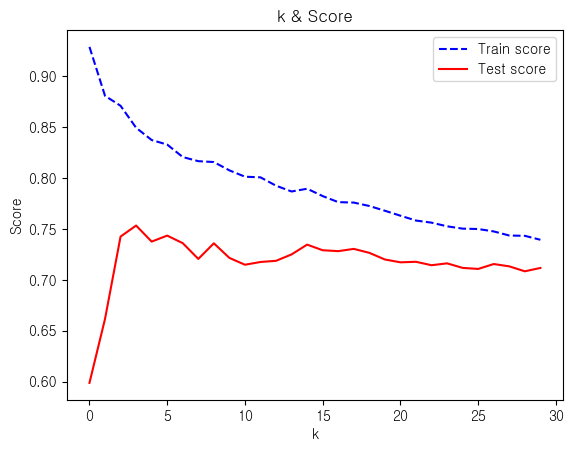

최적의 이웃 개수 k = 4
weight : uniform, metric : nan_euclidean일 때 ===>

StandardScaler() => Train Score : 0.85 --- Test Score : 0.73



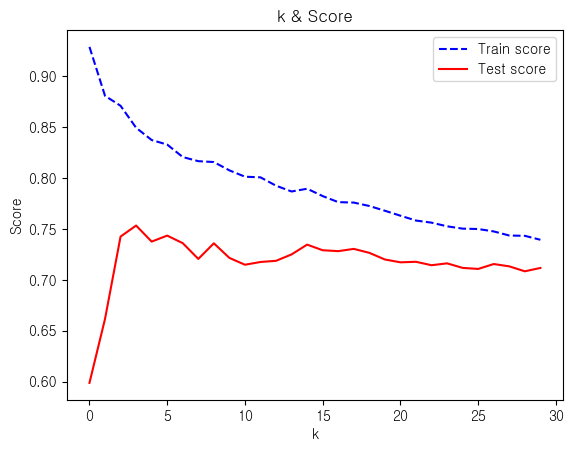

최적의 이웃 개수 k = 4


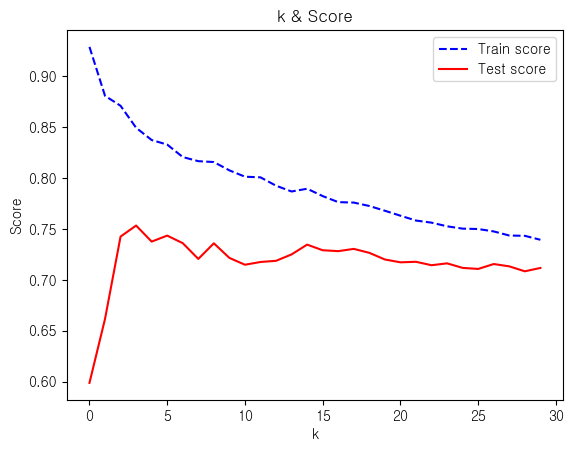

최적의 이웃 개수 k = 4
weight : distance, metric : cityblock일 때 ===>

StandardScaler() => Train Score : 0.96 --- Test Score : 0.77



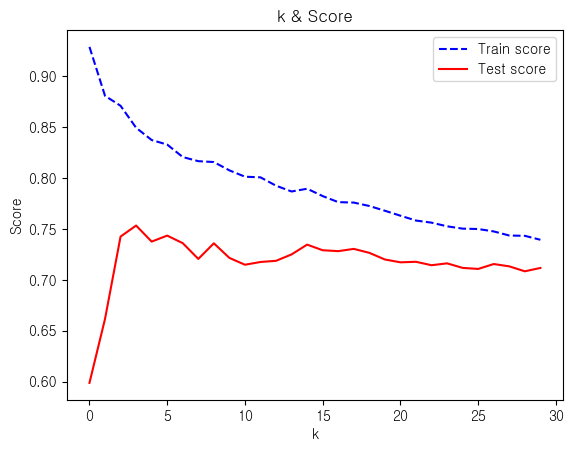

최적의 이웃 개수 k = 4


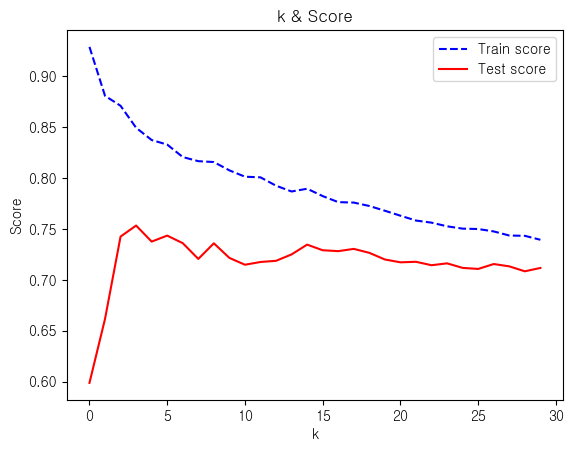

최적의 이웃 개수 k = 4
weight : distance, metric : cosine일 때 ===>

StandardScaler() => Train Score : 0.96 --- Test Score : 0.69



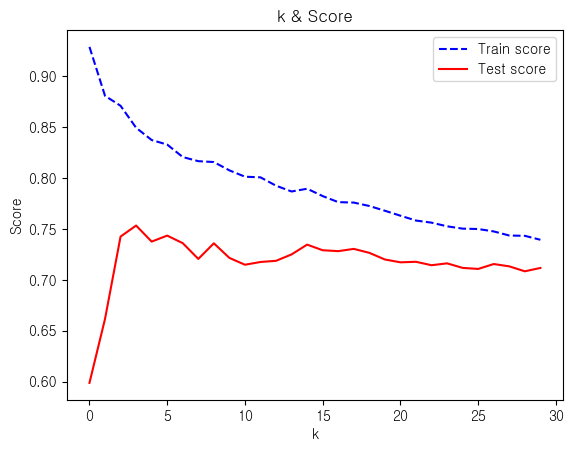

최적의 이웃 개수 k = 4


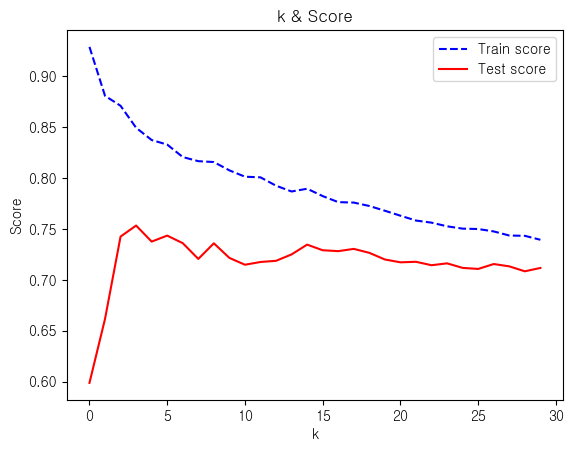

최적의 이웃 개수 k = 4
weight : distance, metric : euclidean일 때 ===>

StandardScaler() => Train Score : 0.96 --- Test Score : 0.77



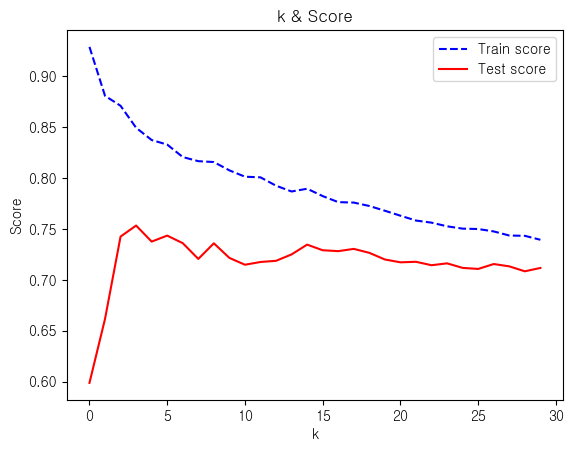

최적의 이웃 개수 k = 4


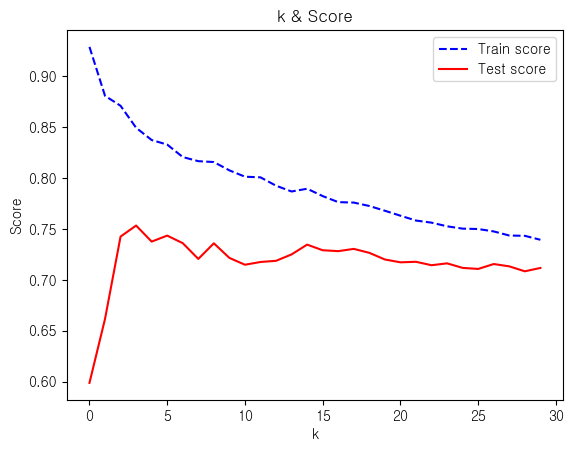

최적의 이웃 개수 k = 4
weight : distance, metric : l1일 때 ===>

StandardScaler() => Train Score : 0.96 --- Test Score : 0.77



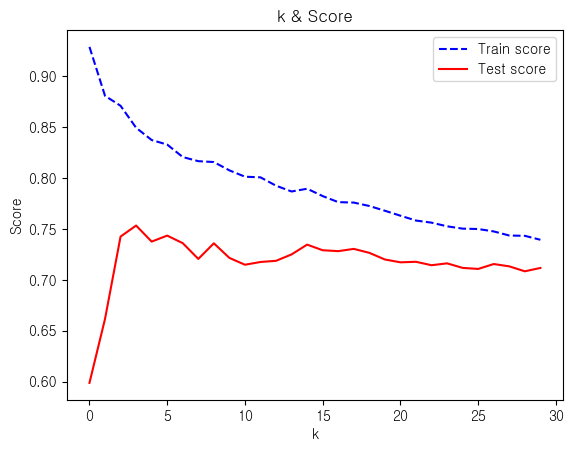

최적의 이웃 개수 k = 4


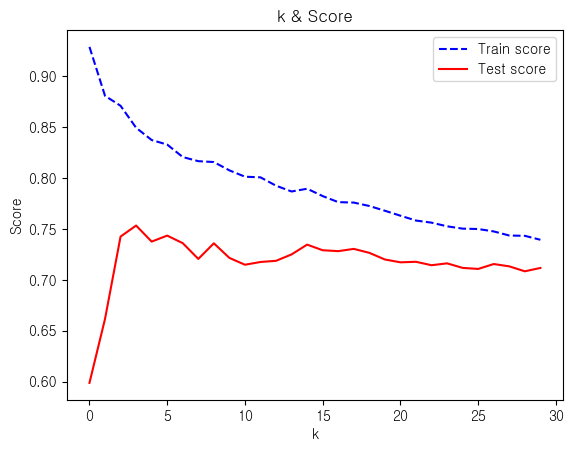

최적의 이웃 개수 k = 4
weight : distance, metric : l2일 때 ===>

StandardScaler() => Train Score : 0.96 --- Test Score : 0.77



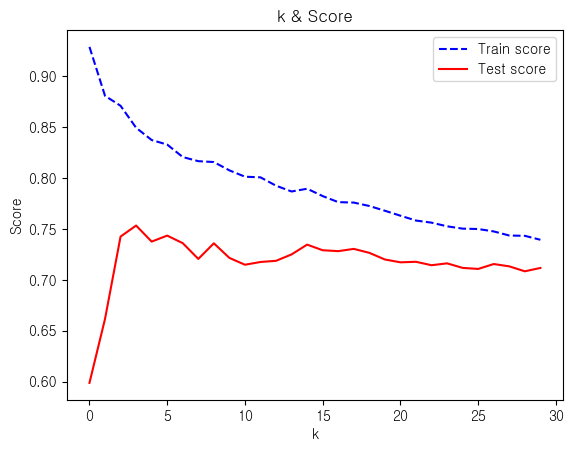

최적의 이웃 개수 k = 4


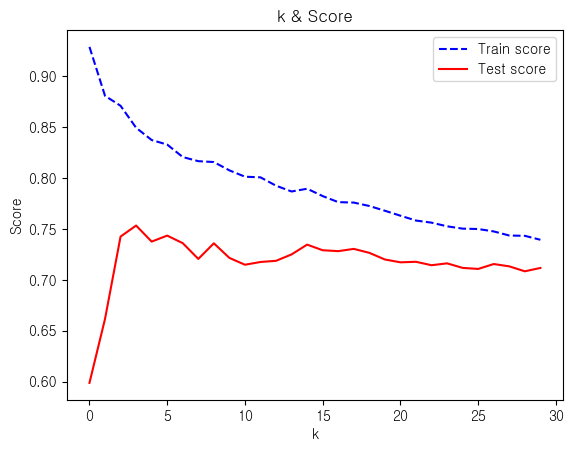

최적의 이웃 개수 k = 4
weight : distance, metric : manhattan일 때 ===>

StandardScaler() => Train Score : 0.96 --- Test Score : 0.77



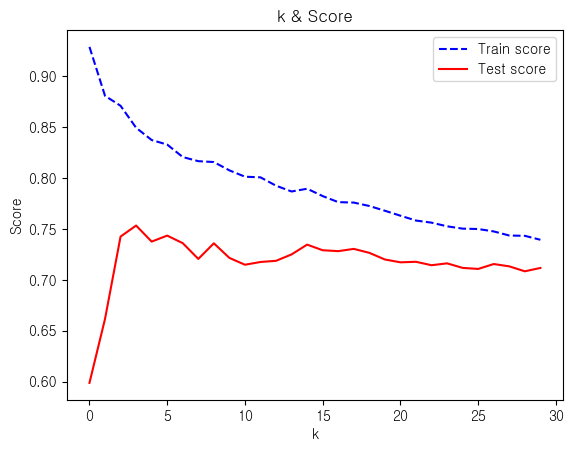

최적의 이웃 개수 k = 4


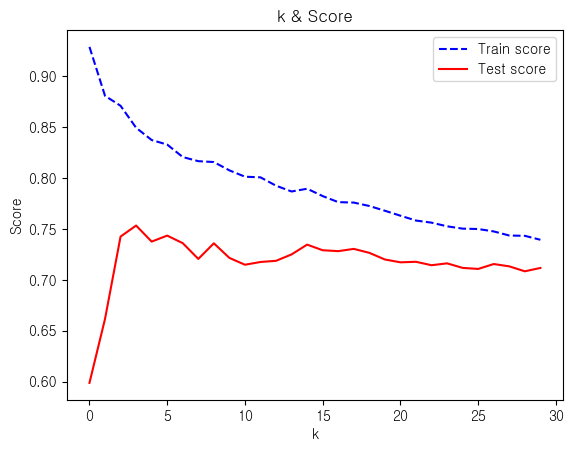

최적의 이웃 개수 k = 4
weight : distance, metric : nan_euclidean일 때 ===>

StandardScaler() => Train Score : 0.96 --- Test Score : 0.76



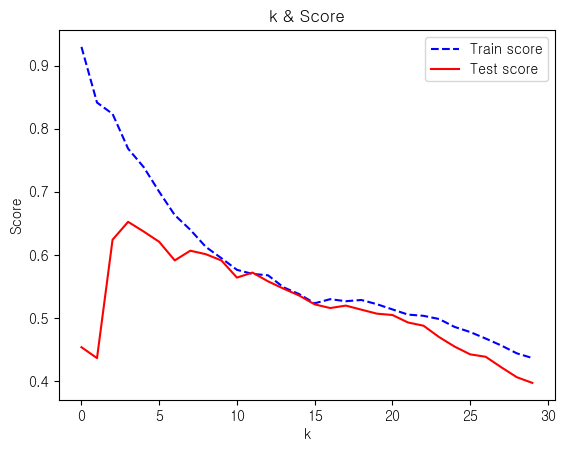

최적의 이웃 개수 k = 4


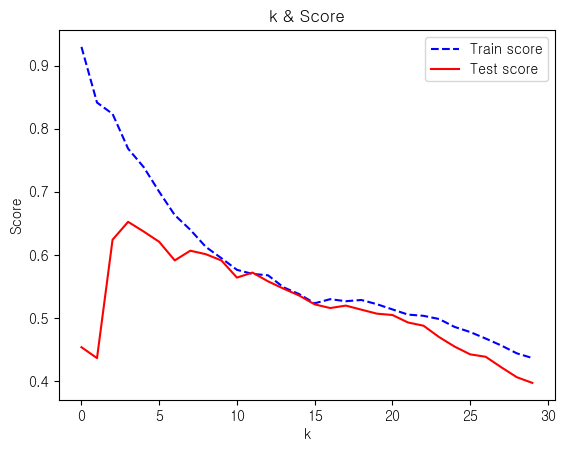

최적의 이웃 개수 k = 4
weight : uniform, metric : cityblock일 때 ===>

MinMaxScaler() => Train Score : 0.78 --- Test Score : 0.66



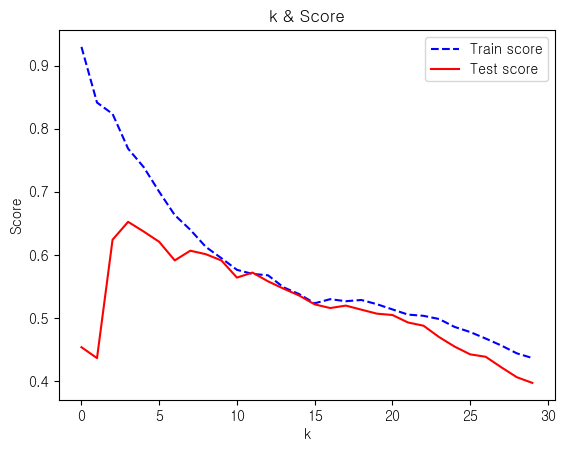

최적의 이웃 개수 k = 4


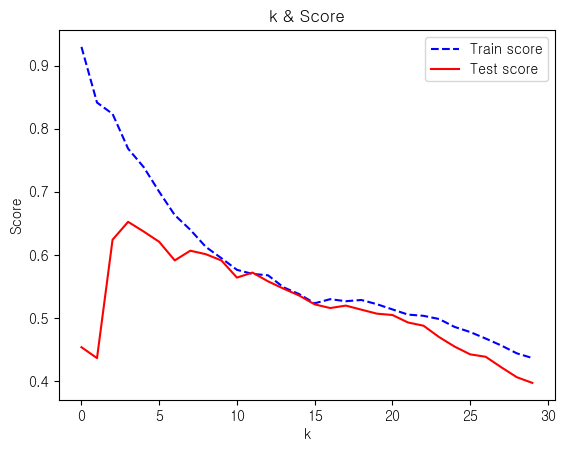

최적의 이웃 개수 k = 4
weight : uniform, metric : cosine일 때 ===>

MinMaxScaler() => Train Score : 0.73 --- Test Score : 0.35



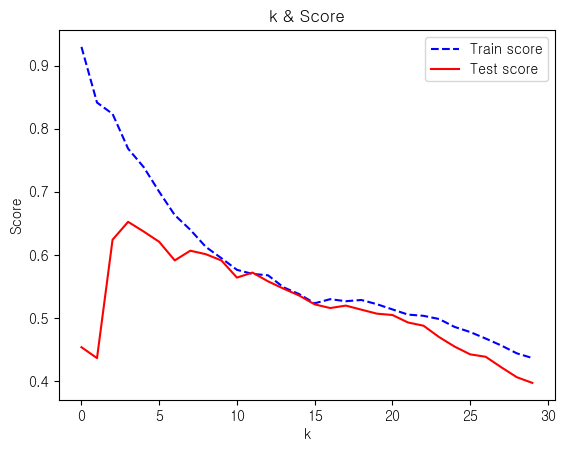

최적의 이웃 개수 k = 4


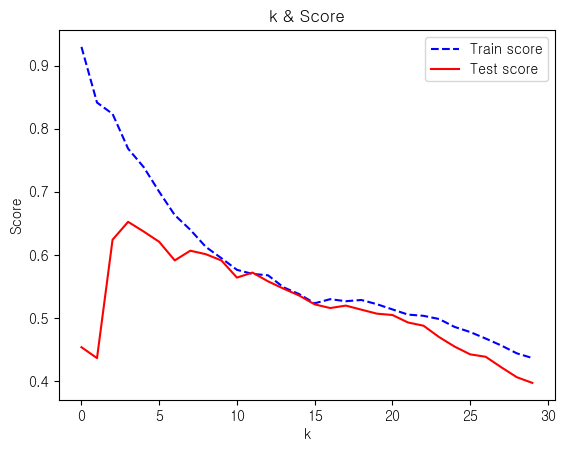

최적의 이웃 개수 k = 4
weight : uniform, metric : euclidean일 때 ===>

MinMaxScaler() => Train Score : 0.77 --- Test Score : 0.65



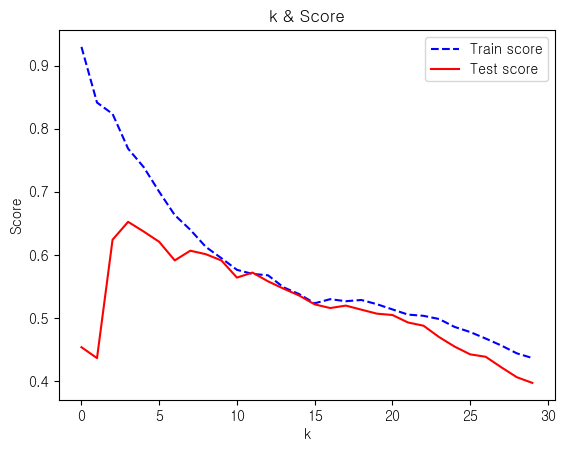

최적의 이웃 개수 k = 4


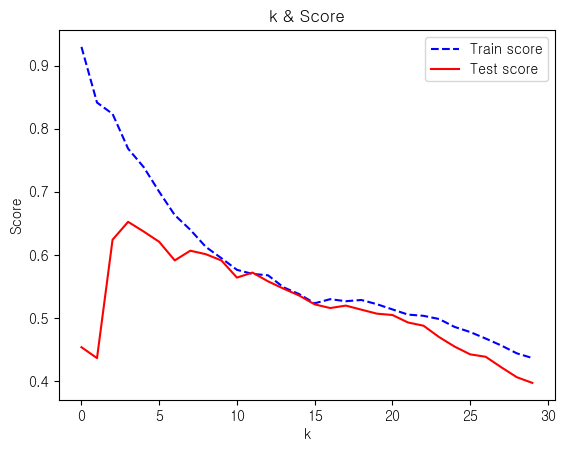

최적의 이웃 개수 k = 4
weight : uniform, metric : l1일 때 ===>

MinMaxScaler() => Train Score : 0.78 --- Test Score : 0.66



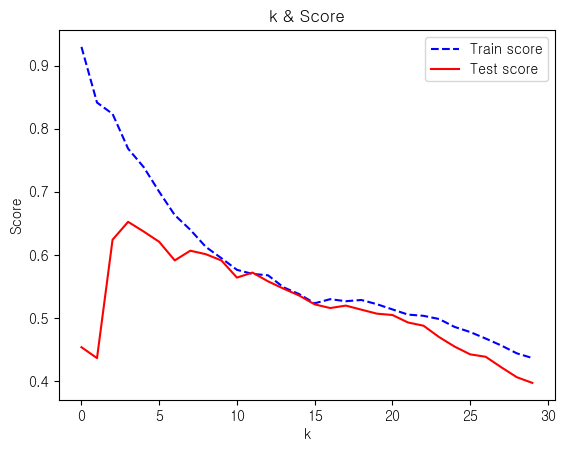

최적의 이웃 개수 k = 4


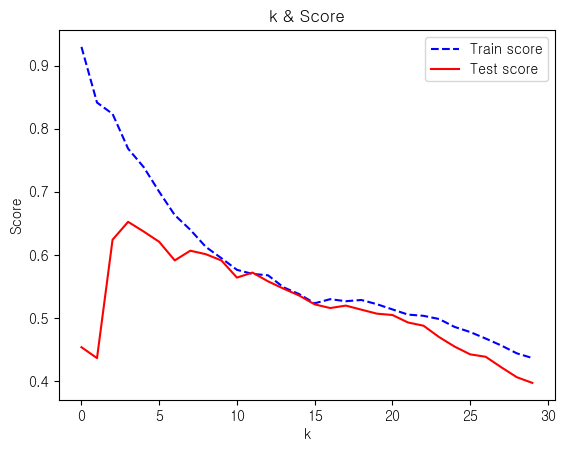

최적의 이웃 개수 k = 4
weight : uniform, metric : l2일 때 ===>

MinMaxScaler() => Train Score : 0.77 --- Test Score : 0.65



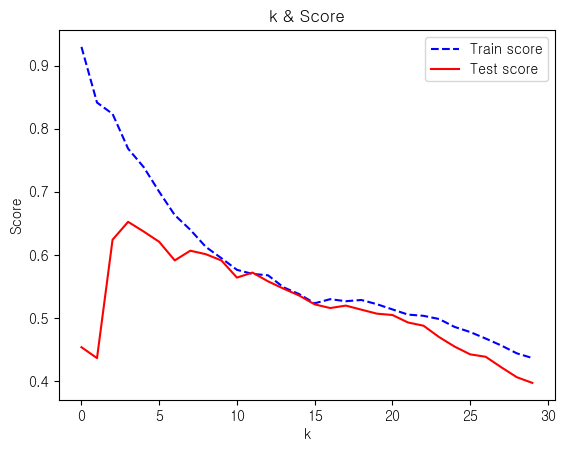

최적의 이웃 개수 k = 4


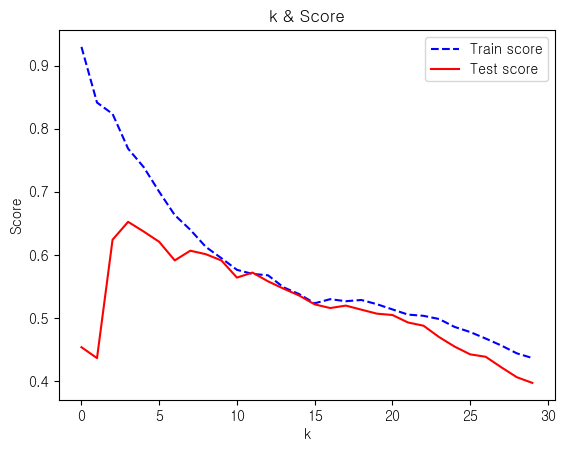

최적의 이웃 개수 k = 4
weight : uniform, metric : manhattan일 때 ===>

MinMaxScaler() => Train Score : 0.78 --- Test Score : 0.66



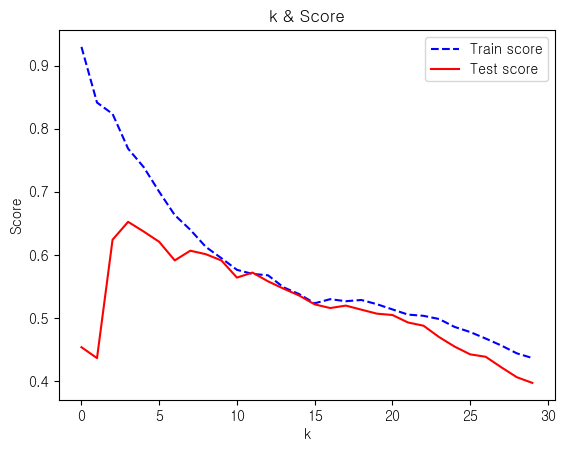

최적의 이웃 개수 k = 4


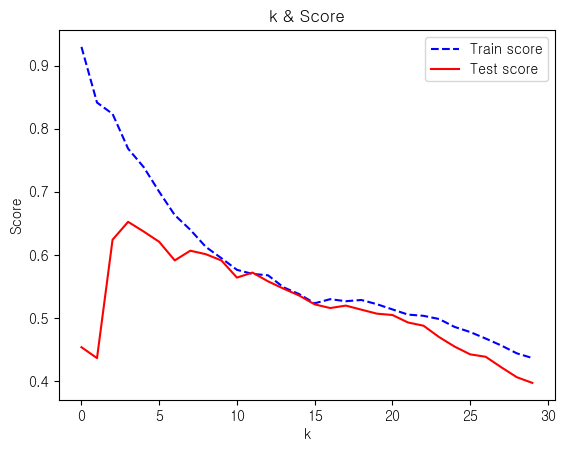

최적의 이웃 개수 k = 4
weight : uniform, metric : nan_euclidean일 때 ===>

MinMaxScaler() => Train Score : 0.77 --- Test Score : 0.65



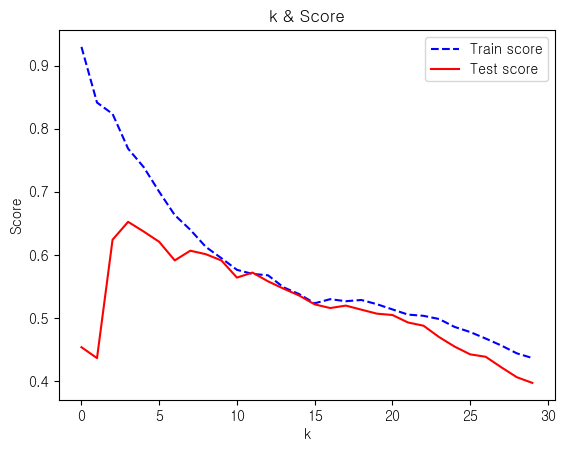

최적의 이웃 개수 k = 4


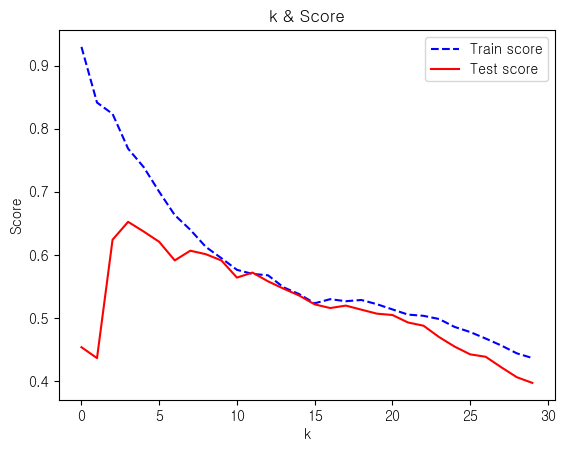

최적의 이웃 개수 k = 4
weight : distance, metric : cityblock일 때 ===>

MinMaxScaler() => Train Score : 0.96 --- Test Score : 0.67



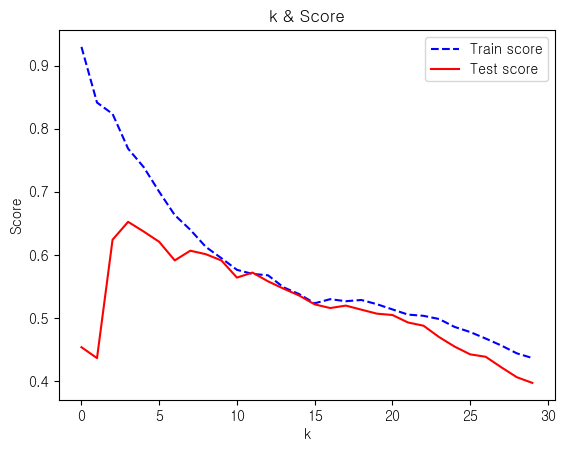

최적의 이웃 개수 k = 4


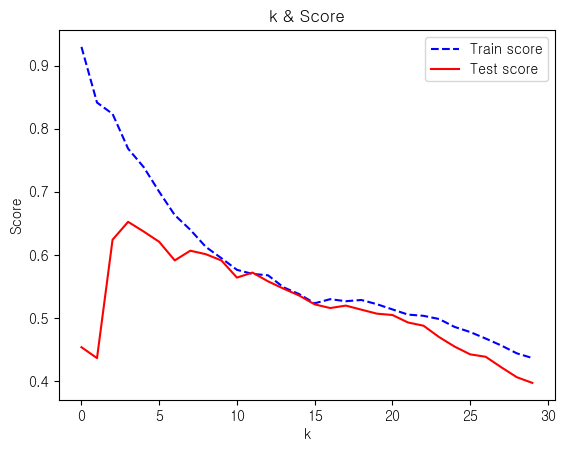

최적의 이웃 개수 k = 4
weight : distance, metric : cosine일 때 ===>

MinMaxScaler() => Train Score : 0.94 --- Test Score : 0.39



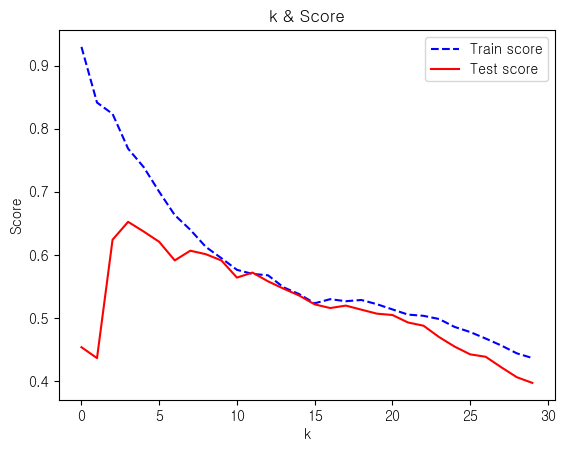

최적의 이웃 개수 k = 4


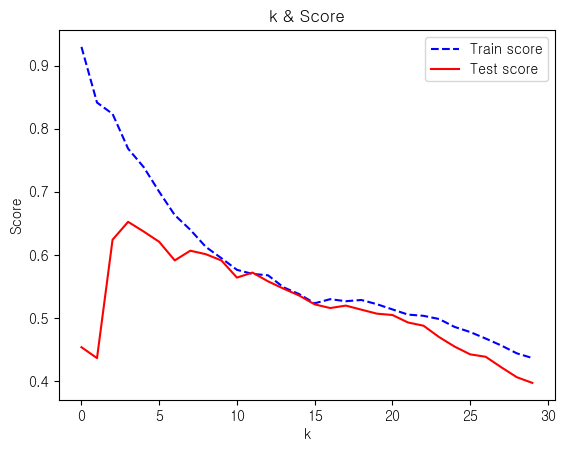

최적의 이웃 개수 k = 4
weight : distance, metric : euclidean일 때 ===>

MinMaxScaler() => Train Score : 0.96 --- Test Score : 0.66



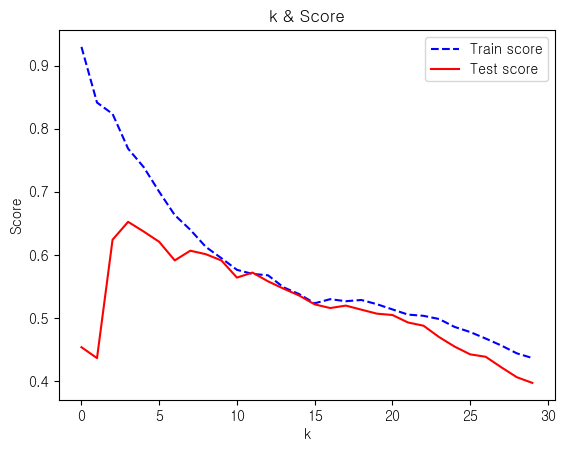

최적의 이웃 개수 k = 4


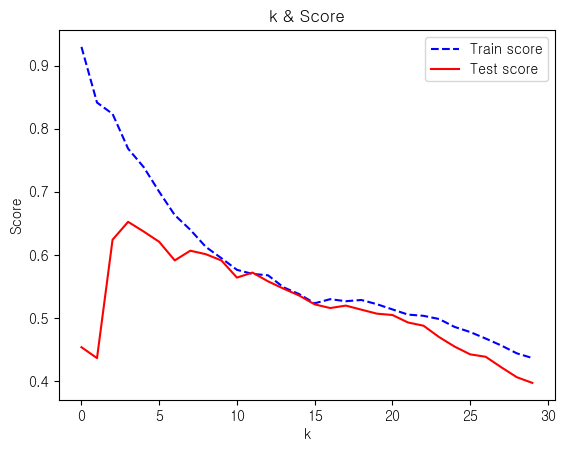

최적의 이웃 개수 k = 4
weight : distance, metric : l1일 때 ===>

MinMaxScaler() => Train Score : 0.96 --- Test Score : 0.67



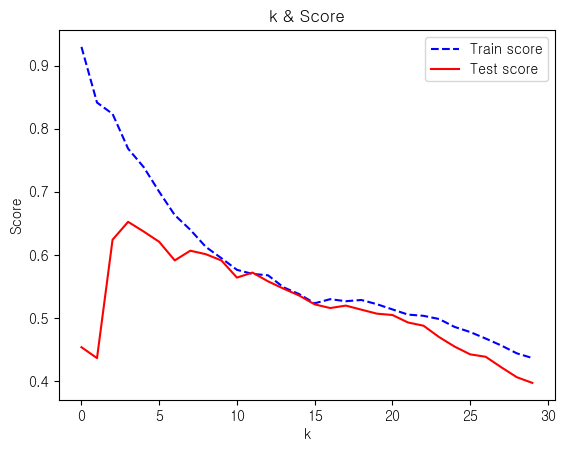

최적의 이웃 개수 k = 4


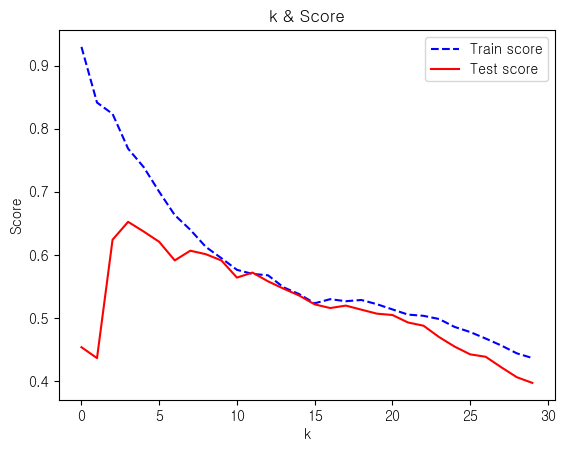

최적의 이웃 개수 k = 4
weight : distance, metric : l2일 때 ===>

MinMaxScaler() => Train Score : 0.96 --- Test Score : 0.66



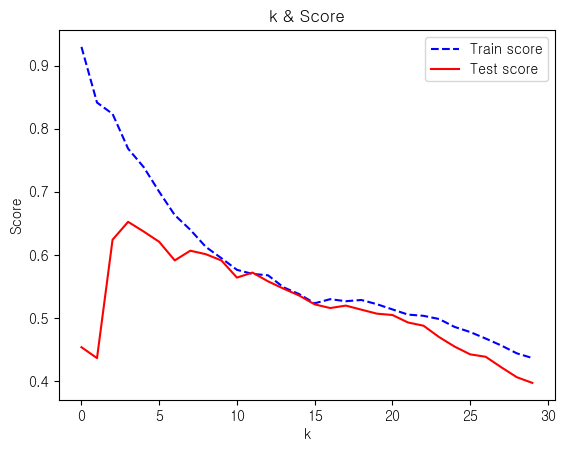

최적의 이웃 개수 k = 4


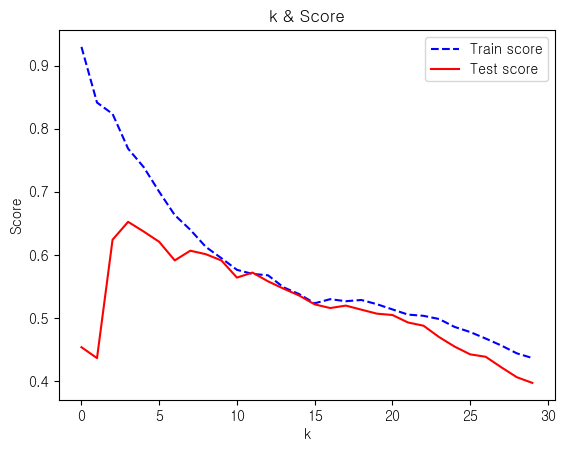

최적의 이웃 개수 k = 4
weight : distance, metric : manhattan일 때 ===>

MinMaxScaler() => Train Score : 0.96 --- Test Score : 0.67



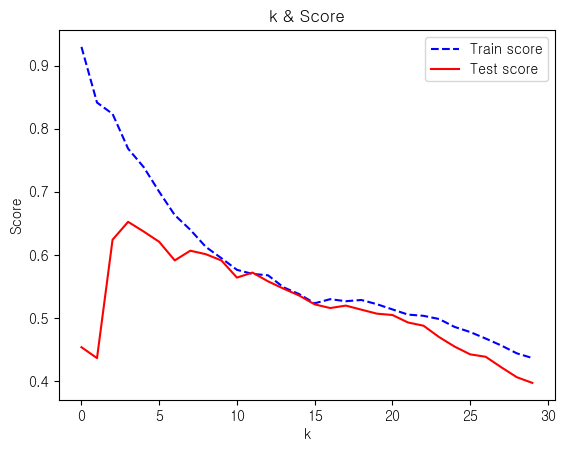

최적의 이웃 개수 k = 4


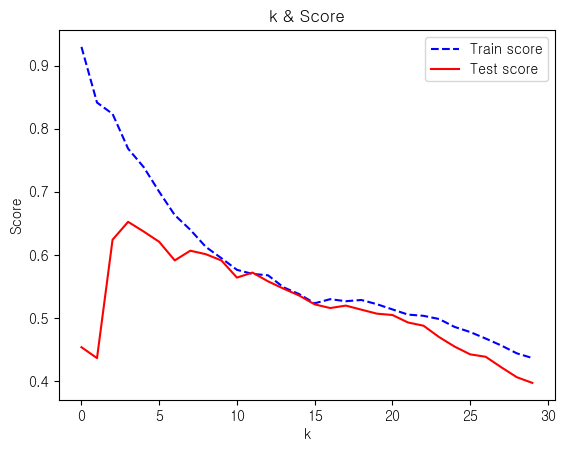

최적의 이웃 개수 k = 4
weight : distance, metric : nan_euclidean일 때 ===>

MinMaxScaler() => Train Score : 0.96 --- Test Score : 0.65



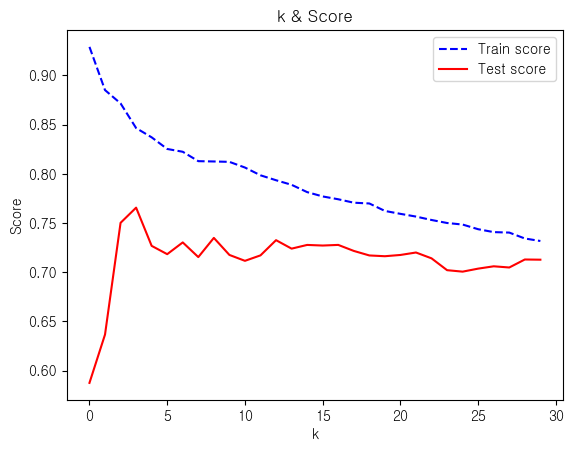

최적의 이웃 개수 k = 4


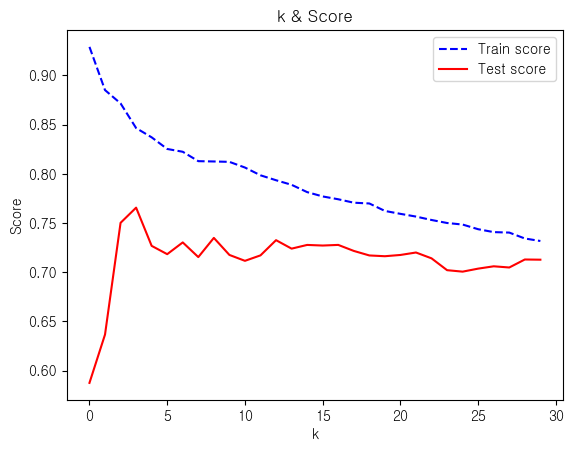

최적의 이웃 개수 k = 4
weight : uniform, metric : cityblock일 때 ===>

RobustScaler() => Train Score : 0.85 --- Test Score : 0.76



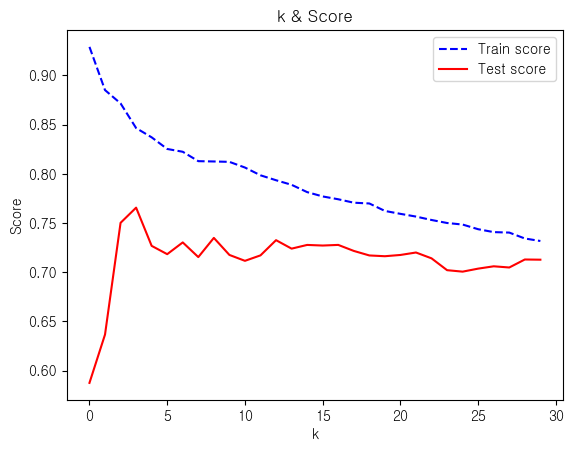

최적의 이웃 개수 k = 4


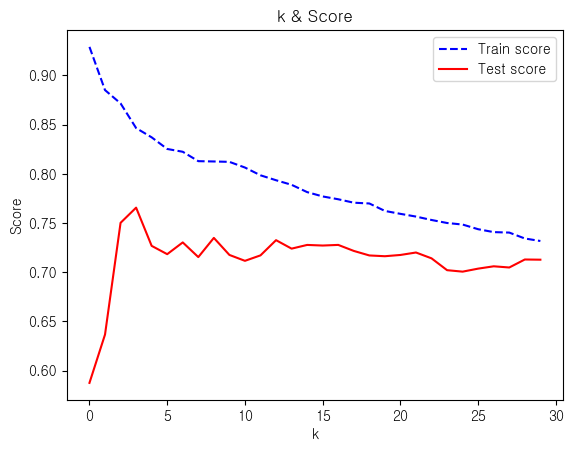

최적의 이웃 개수 k = 4
weight : uniform, metric : cosine일 때 ===>

RobustScaler() => Train Score : 0.83 --- Test Score : 0.66



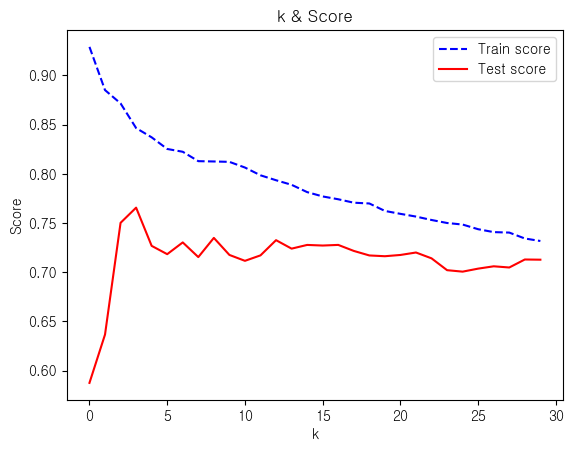

최적의 이웃 개수 k = 4


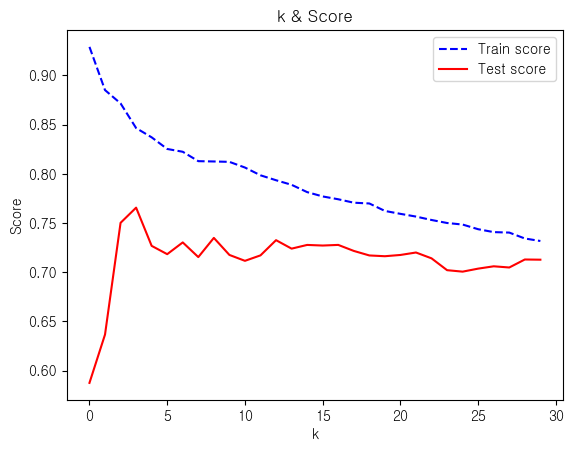

최적의 이웃 개수 k = 4
weight : uniform, metric : euclidean일 때 ===>

RobustScaler() => Train Score : 0.85 --- Test Score : 0.77



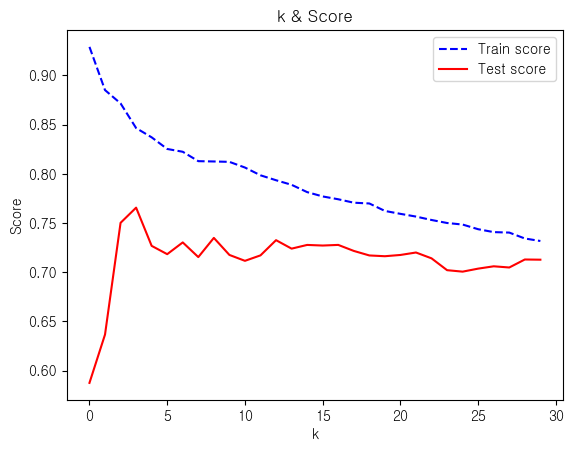

최적의 이웃 개수 k = 4


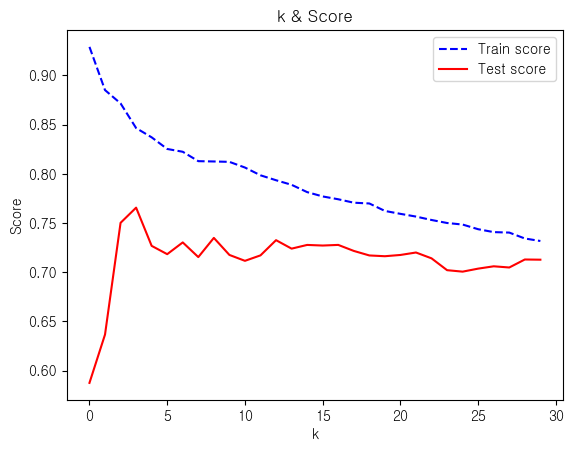

최적의 이웃 개수 k = 4
weight : uniform, metric : l1일 때 ===>

RobustScaler() => Train Score : 0.85 --- Test Score : 0.76



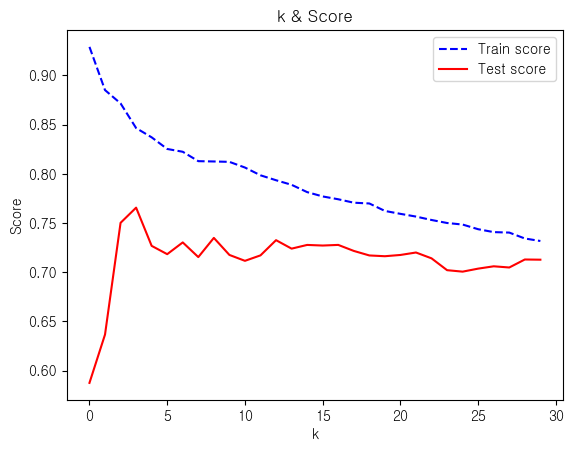

최적의 이웃 개수 k = 4


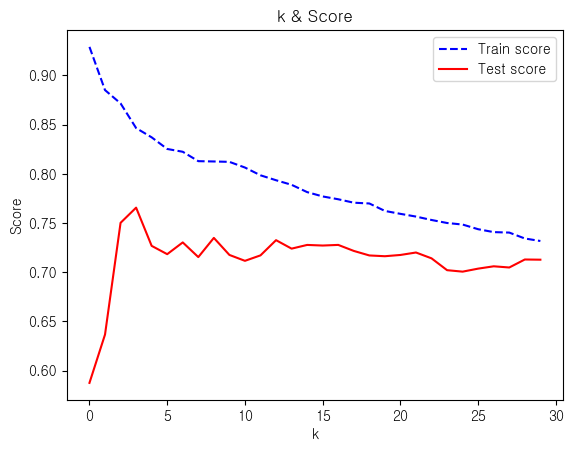

최적의 이웃 개수 k = 4
weight : uniform, metric : l2일 때 ===>

RobustScaler() => Train Score : 0.85 --- Test Score : 0.77



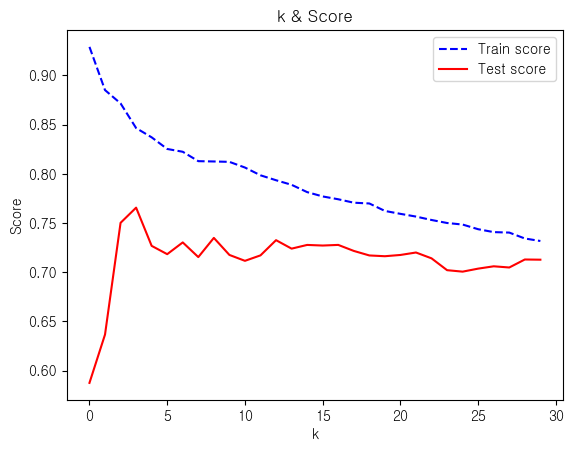

최적의 이웃 개수 k = 4


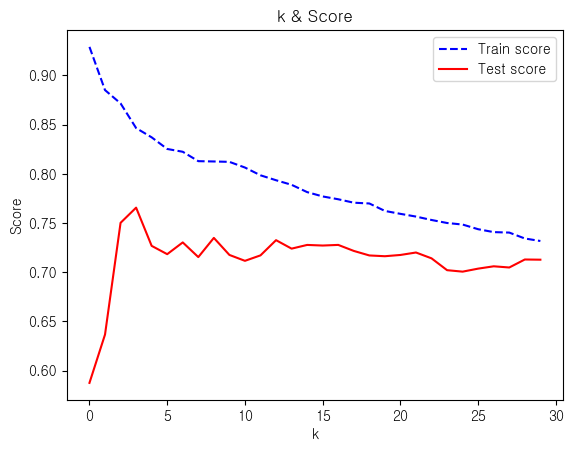

최적의 이웃 개수 k = 4
weight : uniform, metric : manhattan일 때 ===>

RobustScaler() => Train Score : 0.85 --- Test Score : 0.76



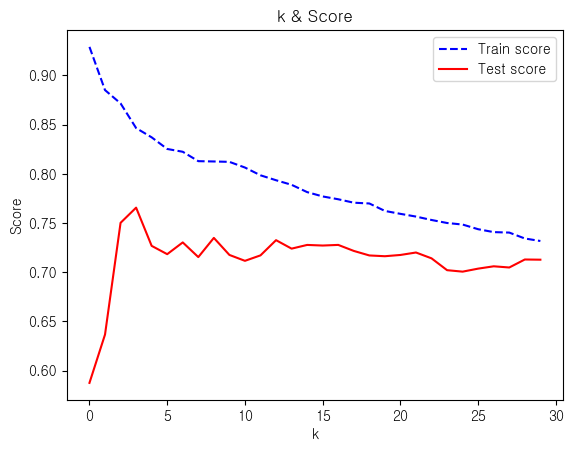

최적의 이웃 개수 k = 4


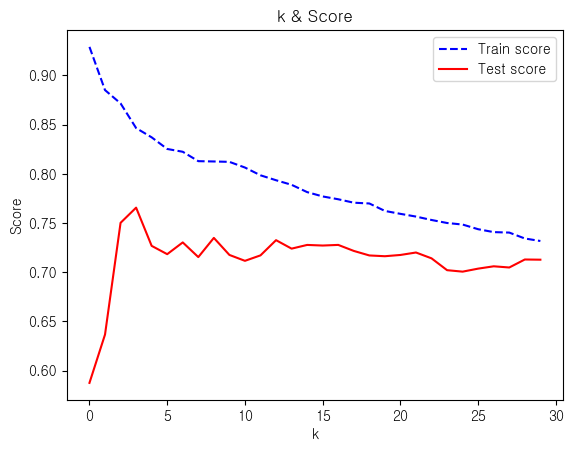

최적의 이웃 개수 k = 4
weight : uniform, metric : nan_euclidean일 때 ===>

RobustScaler() => Train Score : 0.85 --- Test Score : 0.77



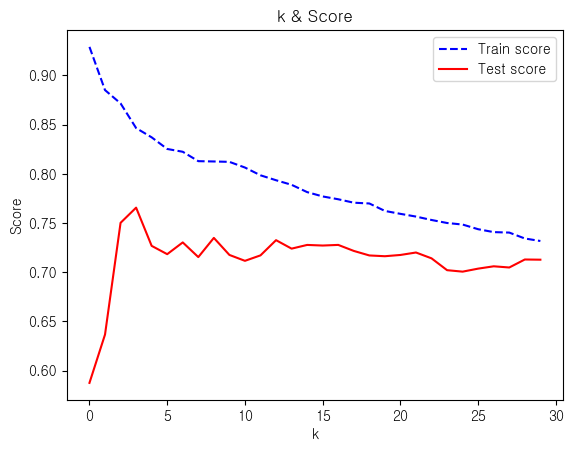

최적의 이웃 개수 k = 4


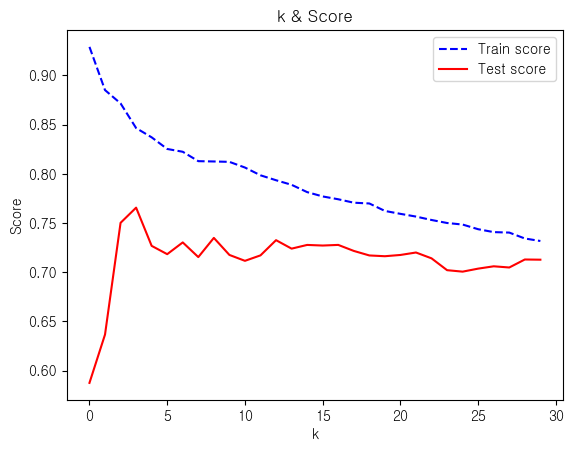

최적의 이웃 개수 k = 4
weight : distance, metric : cityblock일 때 ===>

RobustScaler() => Train Score : 0.96 --- Test Score : 0.77



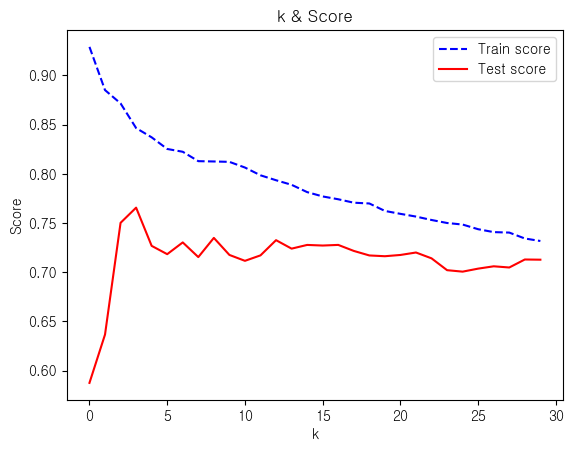

최적의 이웃 개수 k = 4


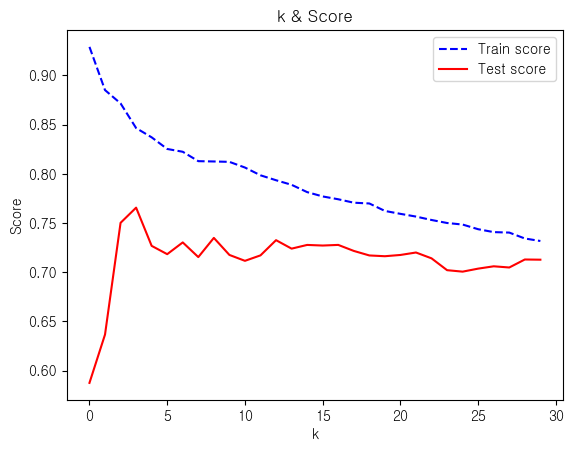

최적의 이웃 개수 k = 4
weight : distance, metric : cosine일 때 ===>

RobustScaler() => Train Score : 0.96 --- Test Score : 0.68



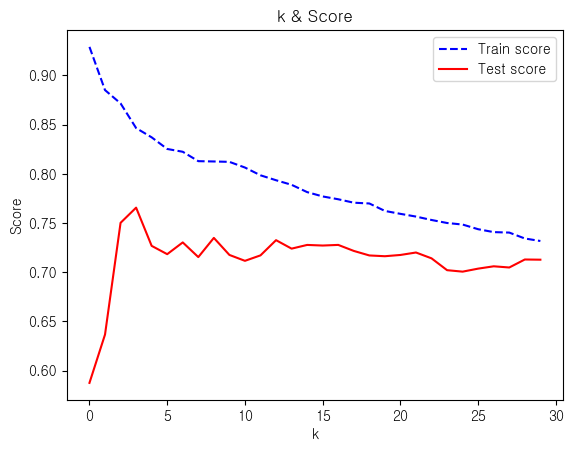

최적의 이웃 개수 k = 4


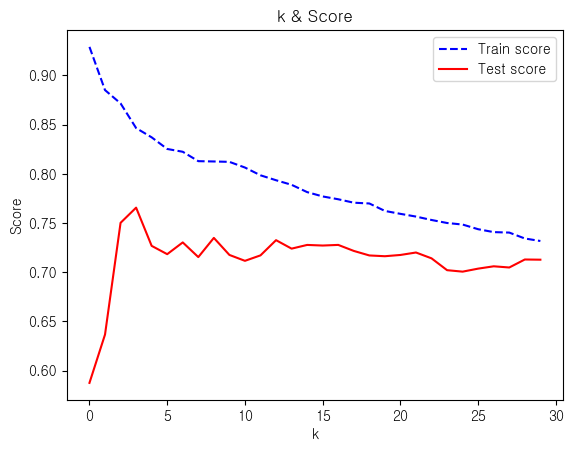

최적의 이웃 개수 k = 4
weight : distance, metric : euclidean일 때 ===>

RobustScaler() => Train Score : 0.96 --- Test Score : 0.78



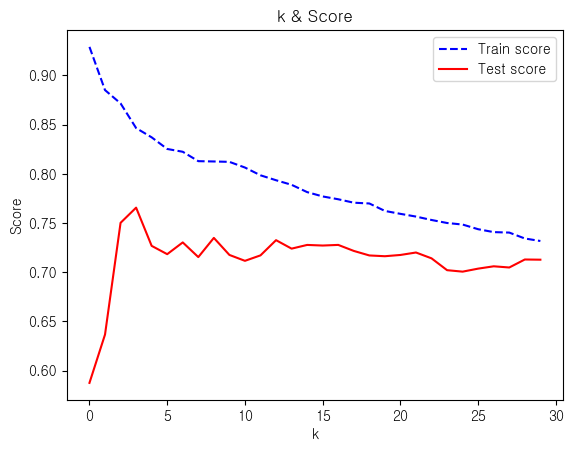

최적의 이웃 개수 k = 4


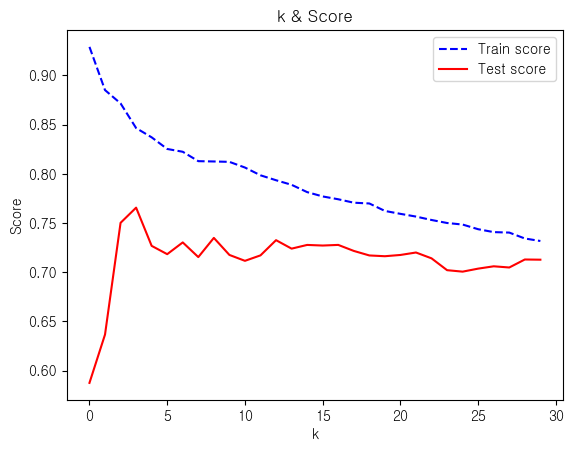

최적의 이웃 개수 k = 4
weight : distance, metric : l1일 때 ===>

RobustScaler() => Train Score : 0.96 --- Test Score : 0.77



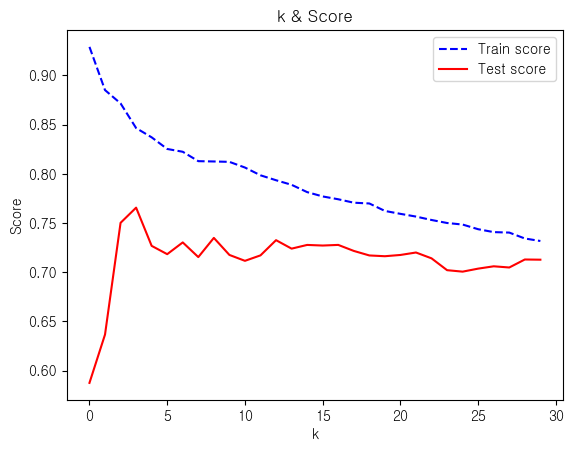

최적의 이웃 개수 k = 4


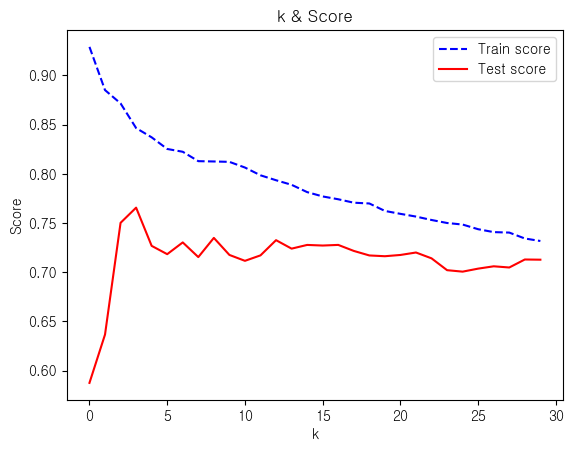

최적의 이웃 개수 k = 4
weight : distance, metric : l2일 때 ===>

RobustScaler() => Train Score : 0.96 --- Test Score : 0.78



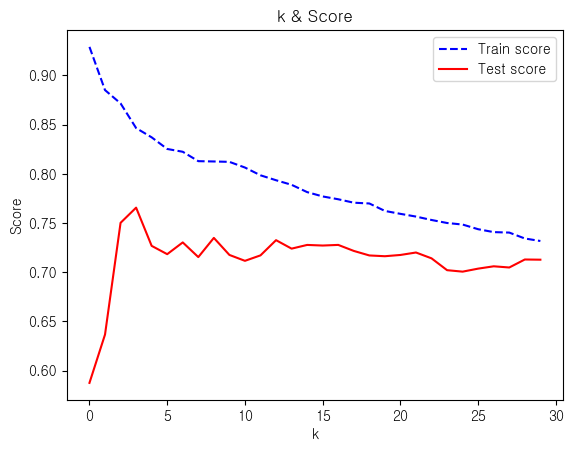

최적의 이웃 개수 k = 4


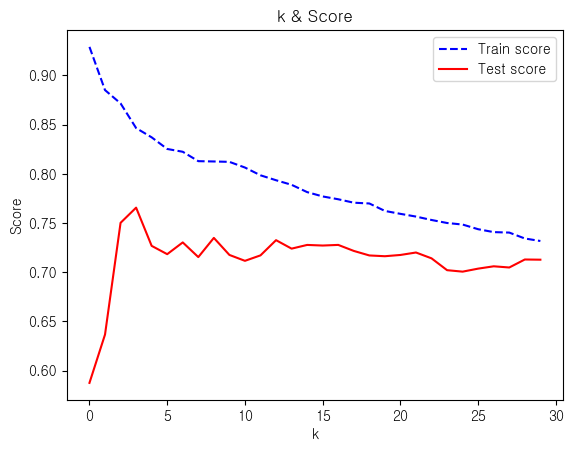

최적의 이웃 개수 k = 4
weight : distance, metric : manhattan일 때 ===>

RobustScaler() => Train Score : 0.96 --- Test Score : 0.77



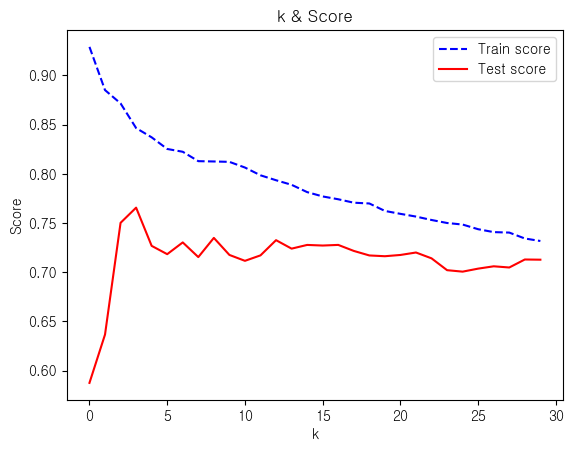

최적의 이웃 개수 k = 4


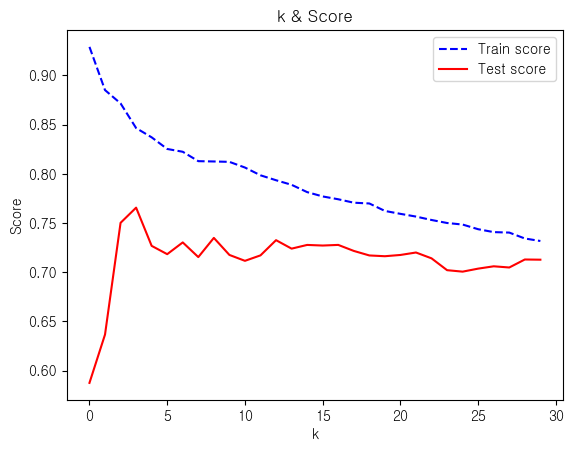

최적의 이웃 개수 k = 4
weight : distance, metric : nan_euclidean일 때 ===>

RobustScaler() => Train Score : 0.96 --- Test Score : 0.78



In [104]:
# KNeighborsRegressor 학습
def main():
    weight_list = ['uniform', 'distance']
    metric_list = ['cityblock', 'cosine', 'euclidean', 'l1', 'l2', 'manhattan', 'nan_euclidean']
    for scaler in [StandardScaler(), MinMaxScaler(), RobustScaler()]:
        for weight in weight_list:
            for metric in metric_list:
                train_score = score_return(['failures', 'Medu', 'Fedu', 'G1', 'G2'], 'G3',
                                        scaler, 30, weights = weight, metric = metric, my_model = KNeighborsRegressor())[0]
                test_score = score_return(['failures', 'Medu', 'Fedu', 'G1', 'G2'], 'G3',
                                        scaler, 30, weights = weight, metric = metric, my_model = KNeighborsRegressor())[1]
                print(f'weight : {weight}, metric : {metric}일 때 ===>\n')
                print(f'{scaler} => Train Score : {train_score} --- Test Score : {test_score}\n')

main()

In [105]:
student_mathDF['G3'].value_counts()

G3
10    56
11    47
0     38
15    33
8     32
13    31
12    31
9     28
14    27
16    16
6     15
18    12
7      9
5      7
17     6
19     5
20     1
4      1
Name: count, dtype: int64

- KneighborsClassifier로 피처 'G1', 'G2'와 다른 피처를 추가하여 활용한 학습

In [106]:
# scaler에 따른 점수 반환 함수
def score_return(feature, target, my_scaler, max_k, stratify, weights = 'uniform', metric = 'minkowski', my_model = KNeighborsClassifier(),
                 test_size = 0.2, random_state = 42, df = student_mathDF):
    
    numerical_dataDF = df.select_dtypes('int')
    numerical_dataDF = numerical_dataDF[(numerical_dataDF['G3'] != 4) & (numerical_dataDF['G3'] != 20)] # stratify를 쓰려면 각 클래스에 적어도 두개의 샘플은 있어야 한다.
    featureDF = numerical_dataDF[feature]
    targetSR = numerical_dataDF[target]
    
    X_train, X_test, y_train, y_test = train_test_split(featureDF, targetSR, test_size = test_size, random_state = random_state,
                                                        stratify = stratify)

    # 수치형 데이터는 표준 정규화, 범주형 데이터는 라벨 인코딩 처리
    ct = ColumnTransformer([('scaling', my_scaler, ['G1', 'G2'])], remainder = 'passthrough')
    ct.fit(X_train)
    scaled_X_train = ct.transform(X_train)
    scaled_X_test = ct.transform(X_test)

    if my_model.__class__ == KNeighborsRegressor or my_model.__class__ == KNeighborsClassifier:
        train_scoreList = []
        test_scoreList = []
        for k in range(1, max_k + 1):
            model = KNeighborsRegressor(n_neighbors = k)
            model.fit(scaled_X_train, y_train)
            train_scoreList.append(model.score(scaled_X_train, y_train))
            test_scoreList.append(model.score(scaled_X_test, y_test))
        
        # k에 따른 학습용/테스트용 점수 시각화
        plt.plot(train_scoreList, 'b--', label = 'Train score')
        plt.plot(test_scoreList, 'r', label = 'Test score')
        plt.title('k & Score')
        plt.xlabel('k')
        plt.ylabel('Score')
        plt.legend()
        plt.show()

        print(f'최적의 이웃 개수 k = {test_scoreList.index(max(test_scoreList))+1}')
        model = KNeighborsRegressor(n_neighbors = test_scoreList.index(max(test_scoreList))+1, weights = weights, metric = metric)
        model.fit(scaled_X_train, y_train)
        return round(model.score(scaled_X_train, y_train), 2), round(model.score(scaled_X_test, y_test), 2)

    else:
        my_model.fit(scaled_X_train, y_train)
        return round(my_model.score(scaled_X_train, y_train), 2), round(my_model.score(scaled_X_test, y_test), 2)

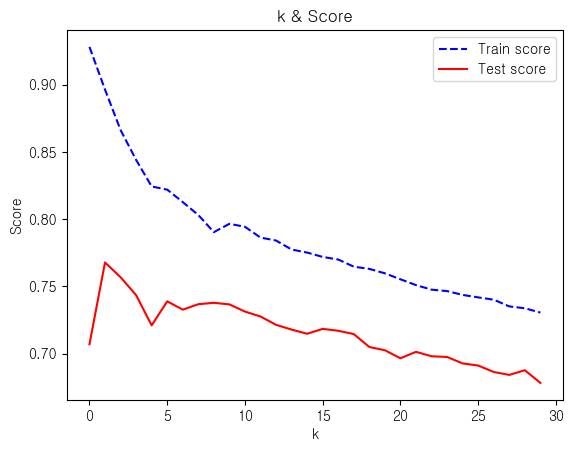

최적의 이웃 개수 k = 2


(0.9, 0.77)

In [107]:
numerical_dataDF = student_mathDF.select_dtypes('int')
numerical_dataDF = numerical_dataDF[(numerical_dataDF['G3'] != 4) & (numerical_dataDF['G3'] != 20)] # stratify를 쓰려면 각 클래스에 적어도 두개의 샘플은 있어야 한다.
featureDF = numerical_dataDF[['failures', 'Medu', 'Fedu', 'G1', 'G2']]
targetSR = numerical_dataDF['G3']

score_return(['failures', 'Medu', 'Fedu', 'G1', 'G2'], 'G3', RobustScaler(), 30, targetSR)

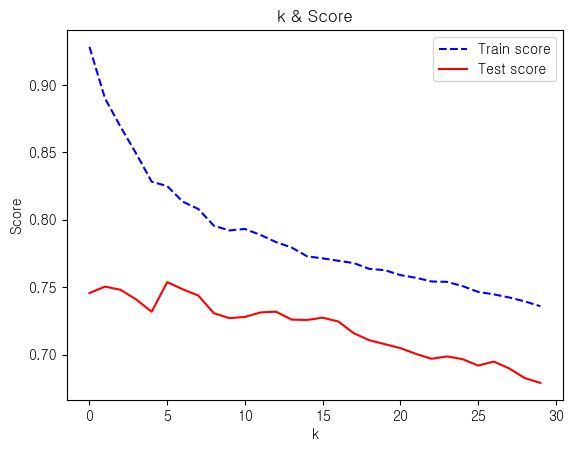

최적의 이웃 개수 k = 6


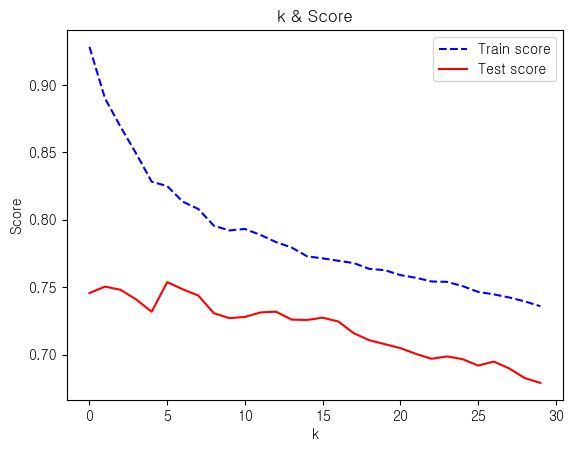

최적의 이웃 개수 k = 6
weight : uniform, metric : cityblock일 때 ===>

StandardScaler() => Train Score : 0.82 --- Test Score : 0.73



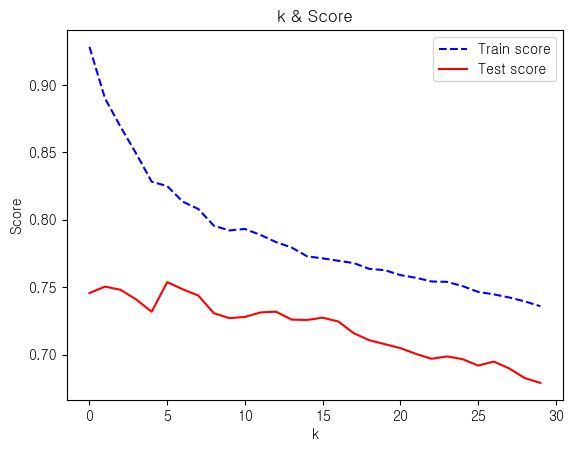

최적의 이웃 개수 k = 6


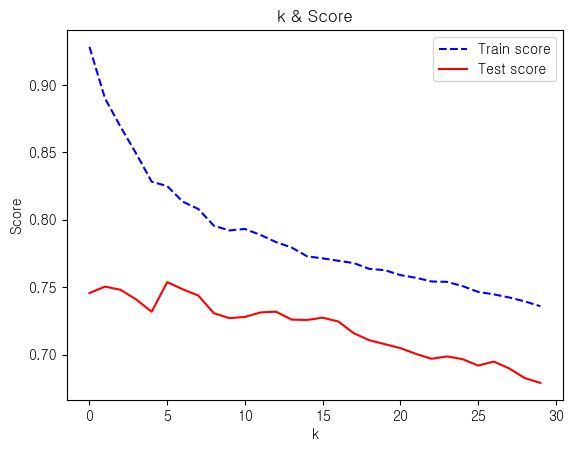

최적의 이웃 개수 k = 6
weight : uniform, metric : cosine일 때 ===>

StandardScaler() => Train Score : 0.81 --- Test Score : 0.65



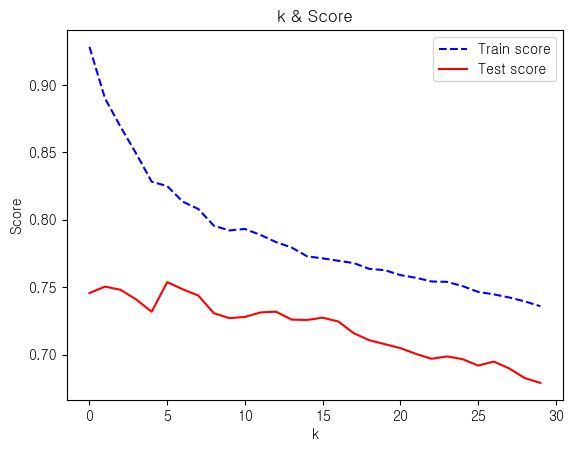

최적의 이웃 개수 k = 6


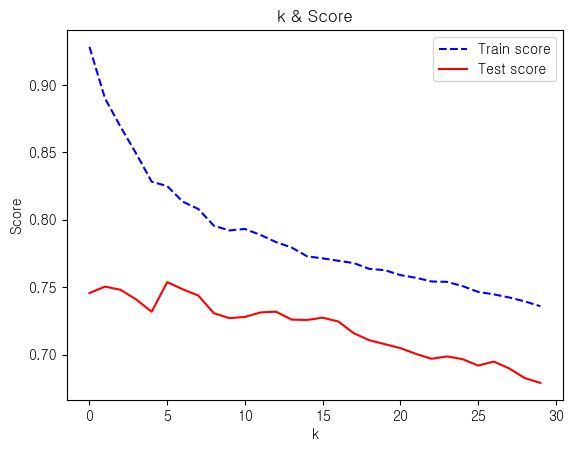

최적의 이웃 개수 k = 6
weight : uniform, metric : euclidean일 때 ===>

StandardScaler() => Train Score : 0.82 --- Test Score : 0.75



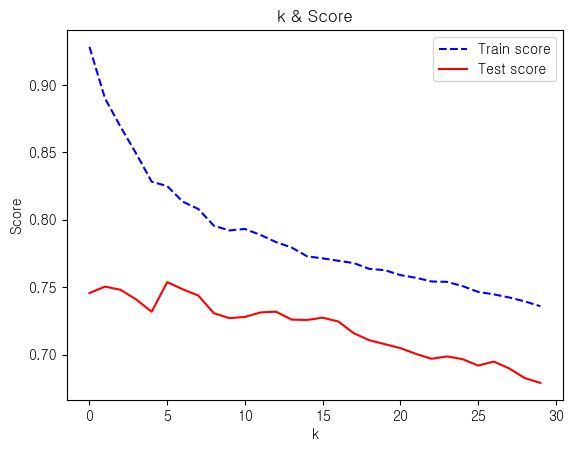

최적의 이웃 개수 k = 6


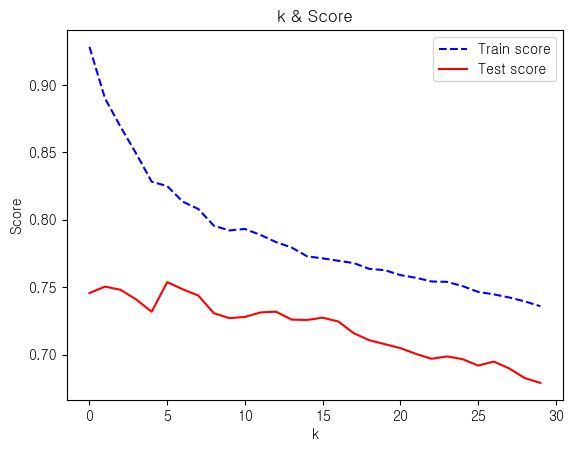

최적의 이웃 개수 k = 6
weight : uniform, metric : l1일 때 ===>

StandardScaler() => Train Score : 0.82 --- Test Score : 0.73



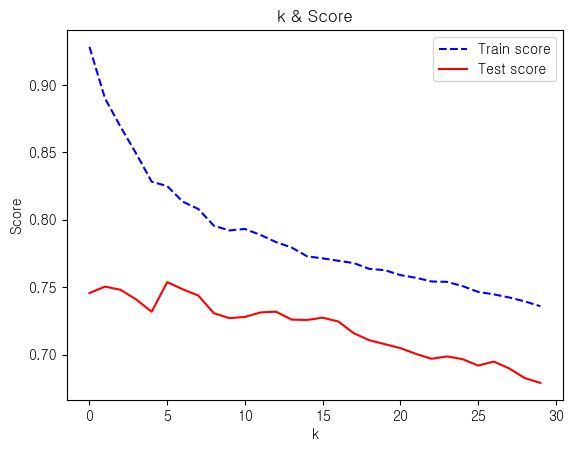

최적의 이웃 개수 k = 6


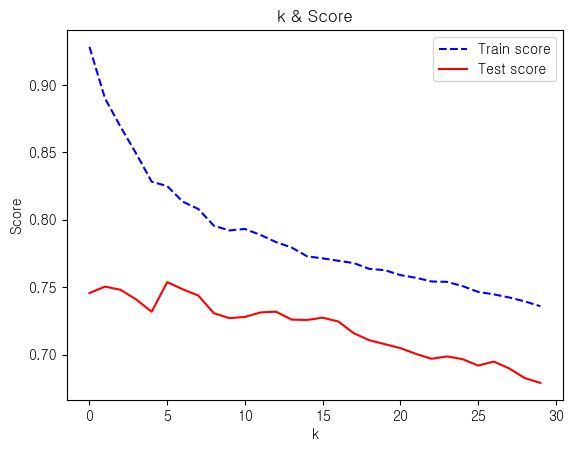

최적의 이웃 개수 k = 6
weight : uniform, metric : l2일 때 ===>

StandardScaler() => Train Score : 0.82 --- Test Score : 0.75



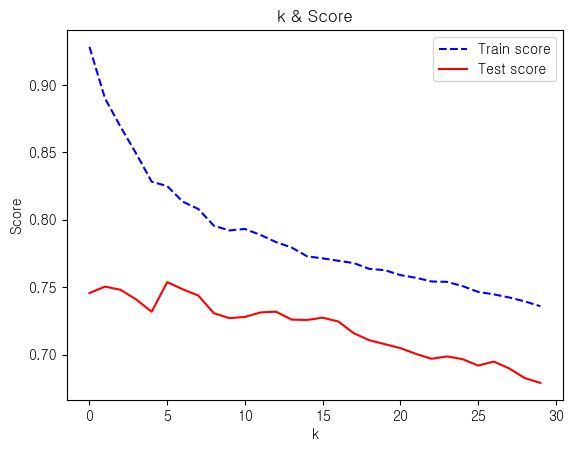

최적의 이웃 개수 k = 6


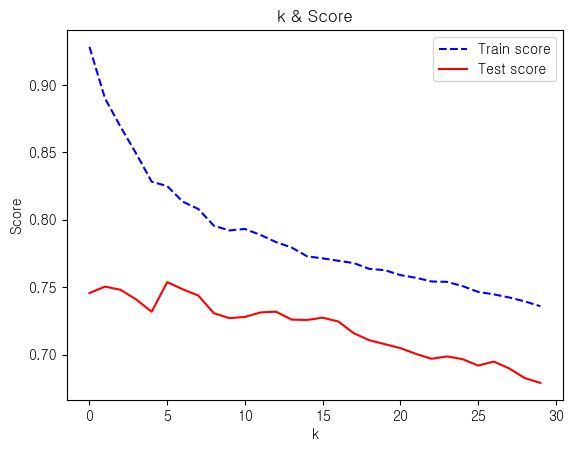

최적의 이웃 개수 k = 6
weight : uniform, metric : manhattan일 때 ===>

StandardScaler() => Train Score : 0.82 --- Test Score : 0.73



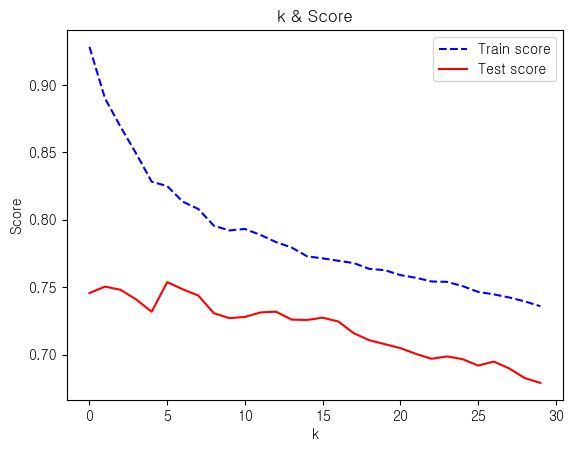

최적의 이웃 개수 k = 6


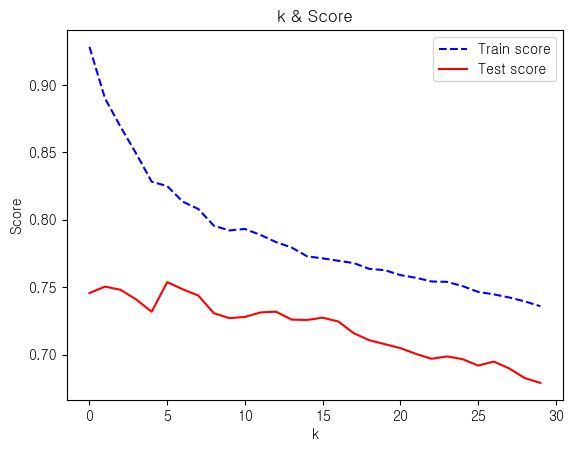

최적의 이웃 개수 k = 6
weight : uniform, metric : nan_euclidean일 때 ===>

StandardScaler() => Train Score : 0.82 --- Test Score : 0.75



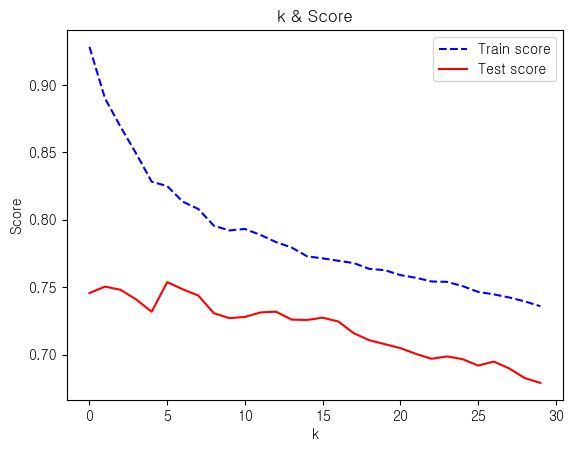

최적의 이웃 개수 k = 6


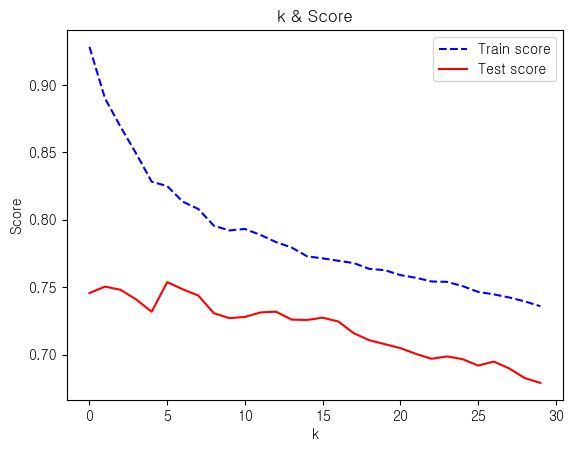

최적의 이웃 개수 k = 6
weight : distance, metric : cityblock일 때 ===>

StandardScaler() => Train Score : 0.96 --- Test Score : 0.77



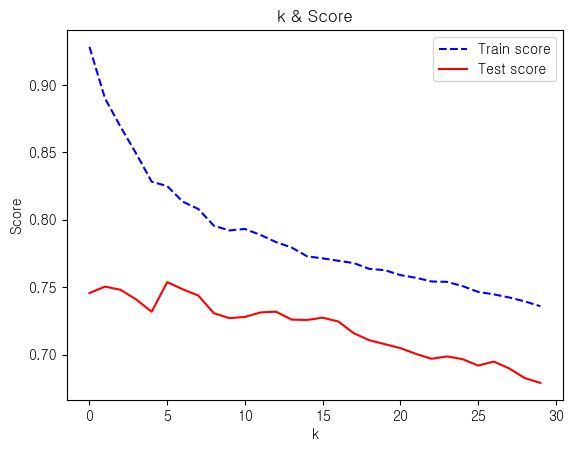

최적의 이웃 개수 k = 6


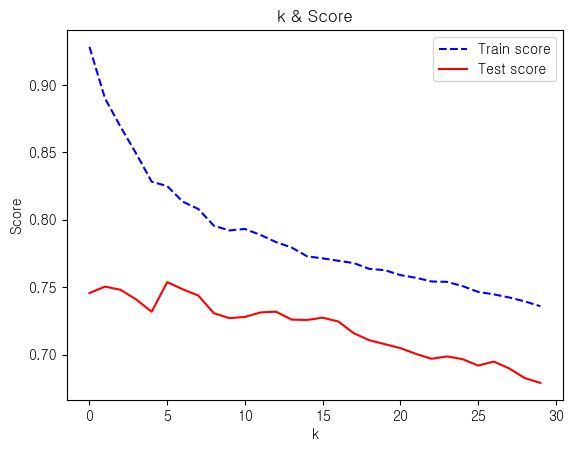

최적의 이웃 개수 k = 6
weight : distance, metric : cosine일 때 ===>

StandardScaler() => Train Score : 0.96 --- Test Score : 0.66



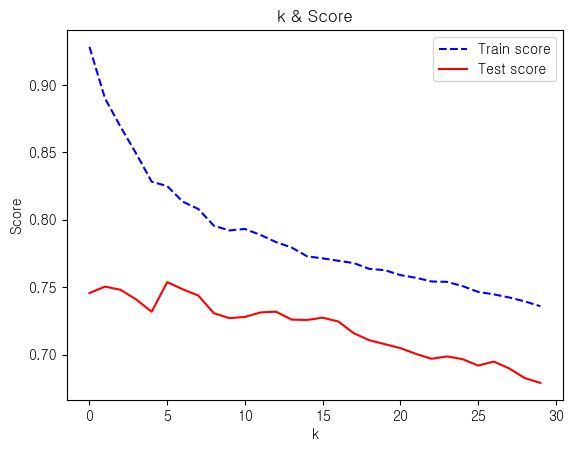

최적의 이웃 개수 k = 6


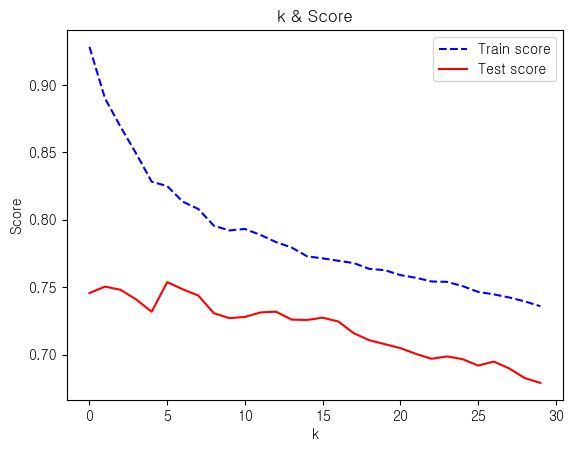

최적의 이웃 개수 k = 6
weight : distance, metric : euclidean일 때 ===>

StandardScaler() => Train Score : 0.96 --- Test Score : 0.78



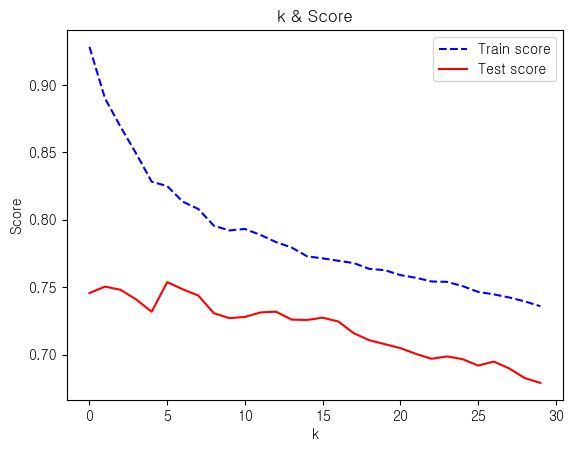

최적의 이웃 개수 k = 6


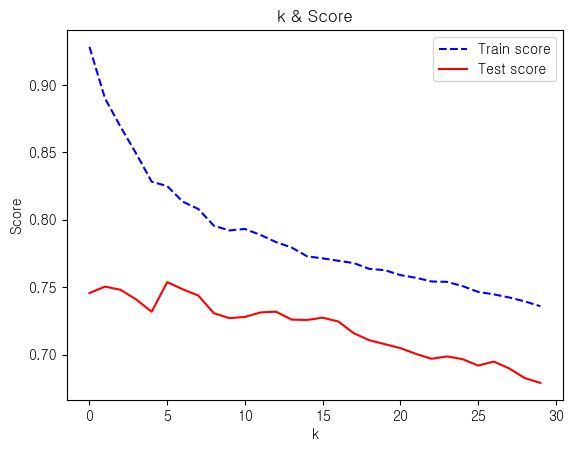

최적의 이웃 개수 k = 6
weight : distance, metric : l1일 때 ===>

StandardScaler() => Train Score : 0.96 --- Test Score : 0.77



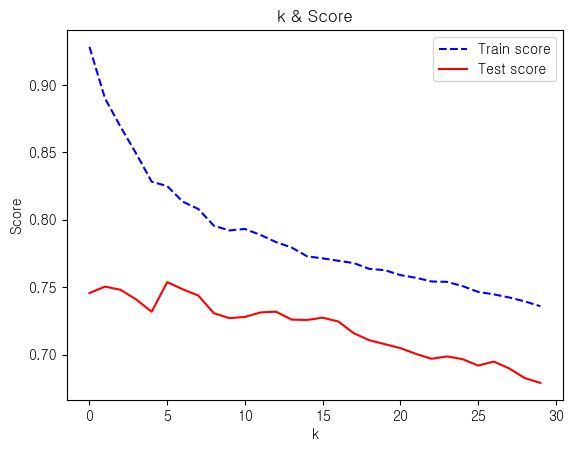

최적의 이웃 개수 k = 6


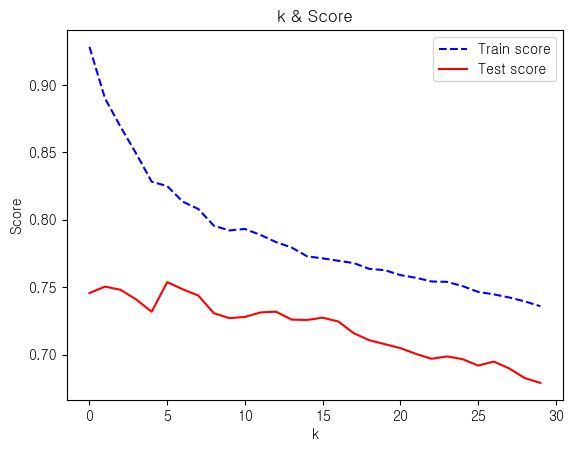

최적의 이웃 개수 k = 6
weight : distance, metric : l2일 때 ===>

StandardScaler() => Train Score : 0.96 --- Test Score : 0.78



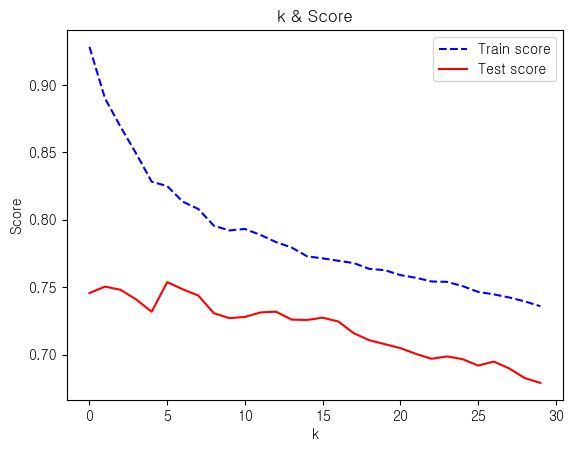

최적의 이웃 개수 k = 6


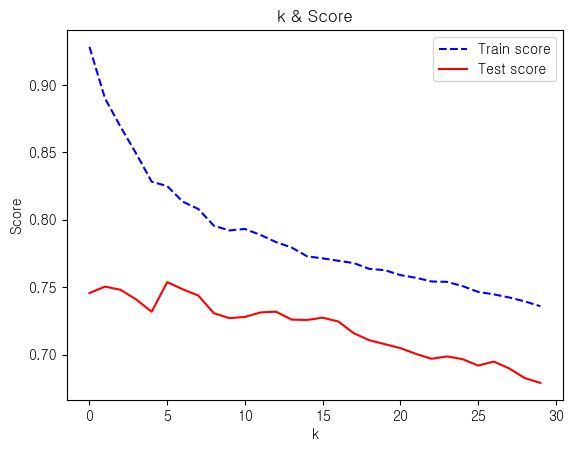

최적의 이웃 개수 k = 6
weight : distance, metric : manhattan일 때 ===>

StandardScaler() => Train Score : 0.96 --- Test Score : 0.77



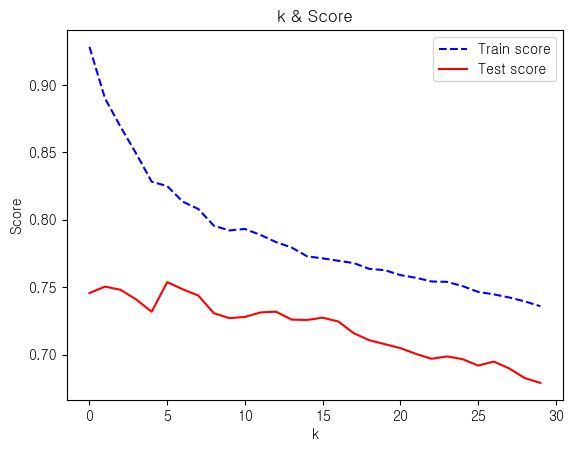

최적의 이웃 개수 k = 6


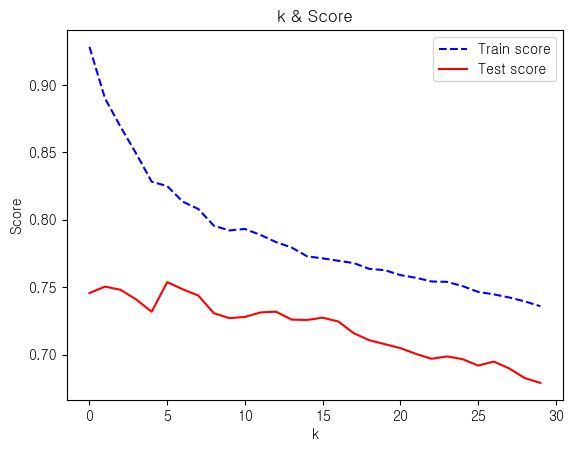

최적의 이웃 개수 k = 6
weight : distance, metric : nan_euclidean일 때 ===>

StandardScaler() => Train Score : 0.96 --- Test Score : 0.78



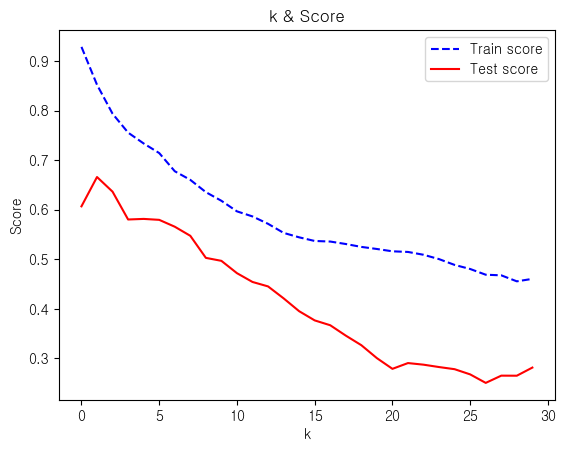

최적의 이웃 개수 k = 2


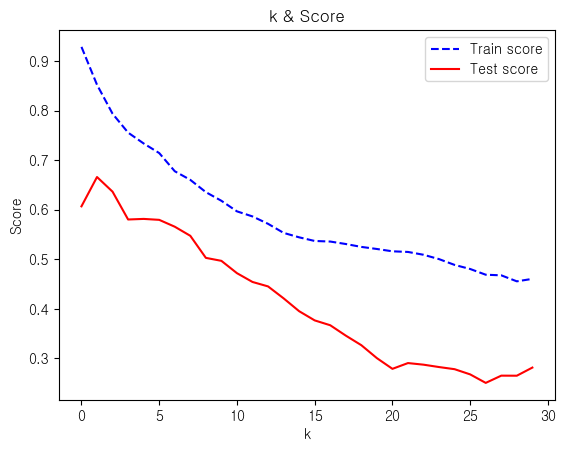

최적의 이웃 개수 k = 2
weight : uniform, metric : cityblock일 때 ===>

MinMaxScaler() => Train Score : 0.85 --- Test Score : 0.67



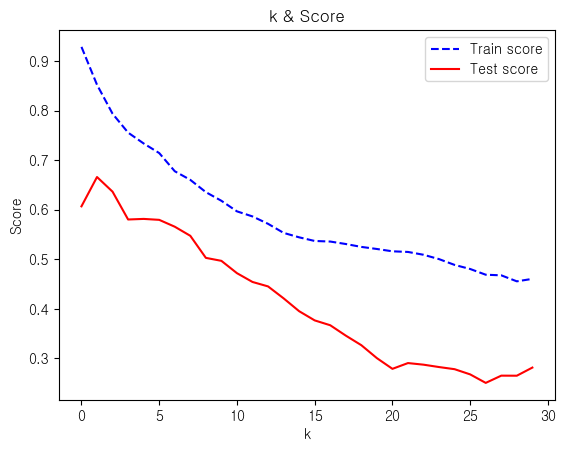

최적의 이웃 개수 k = 2


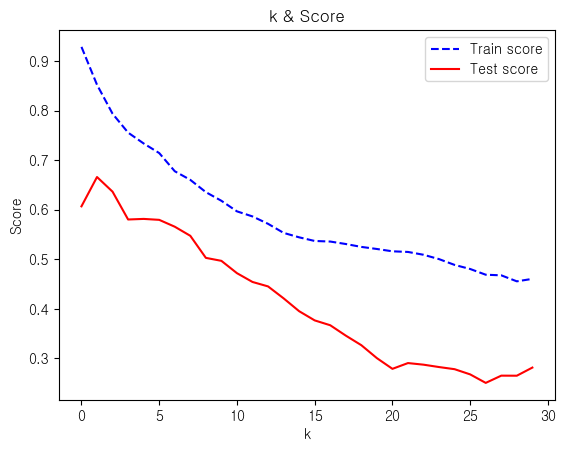

최적의 이웃 개수 k = 2
weight : uniform, metric : cosine일 때 ===>

MinMaxScaler() => Train Score : 0.82 --- Test Score : 0.5



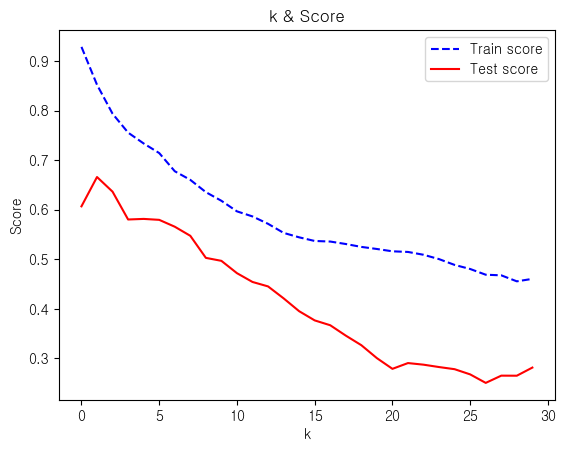

최적의 이웃 개수 k = 2


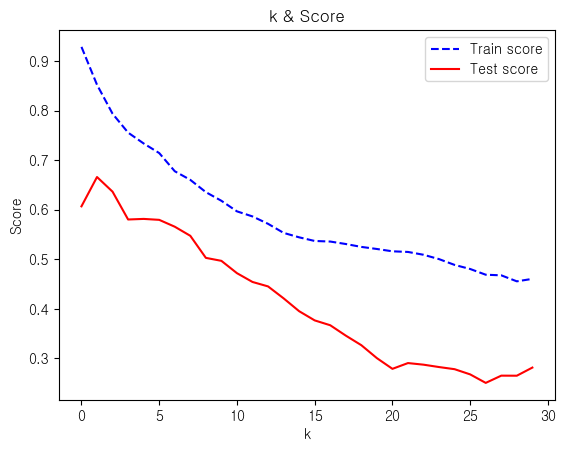

최적의 이웃 개수 k = 2
weight : uniform, metric : euclidean일 때 ===>

MinMaxScaler() => Train Score : 0.85 --- Test Score : 0.67



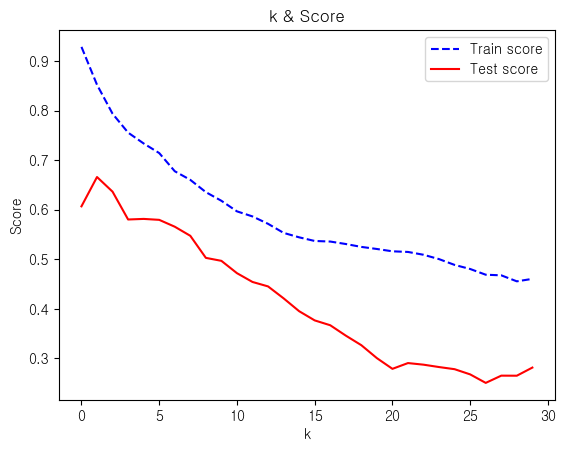

최적의 이웃 개수 k = 2


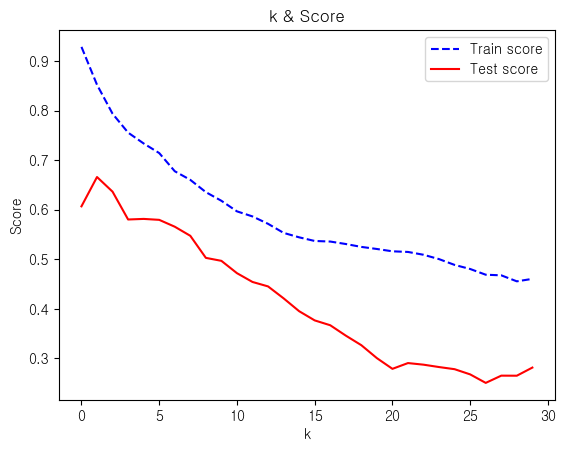

최적의 이웃 개수 k = 2
weight : uniform, metric : l1일 때 ===>

MinMaxScaler() => Train Score : 0.85 --- Test Score : 0.67



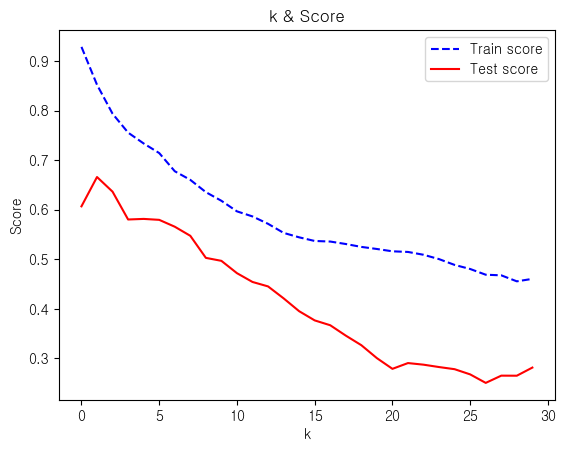

최적의 이웃 개수 k = 2


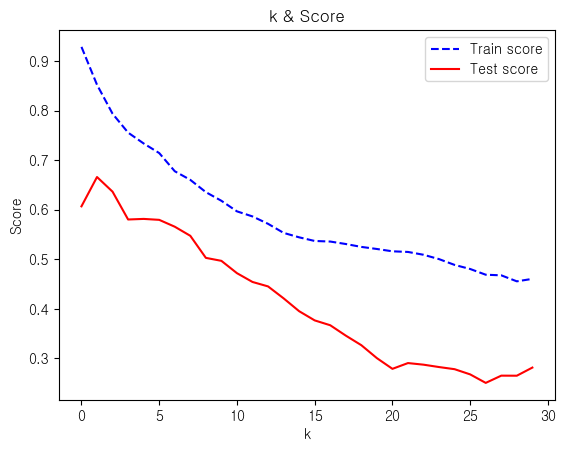

최적의 이웃 개수 k = 2
weight : uniform, metric : l2일 때 ===>

MinMaxScaler() => Train Score : 0.85 --- Test Score : 0.67



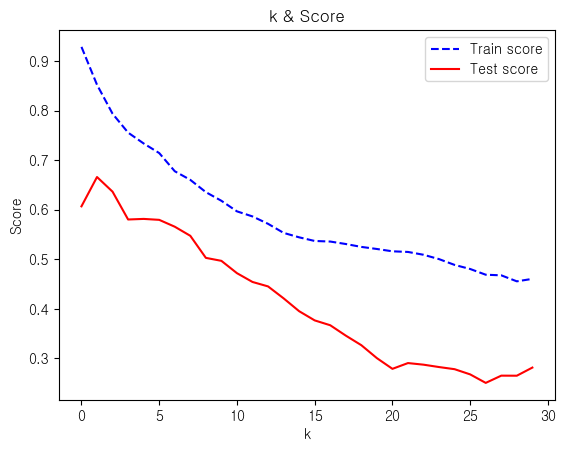

최적의 이웃 개수 k = 2


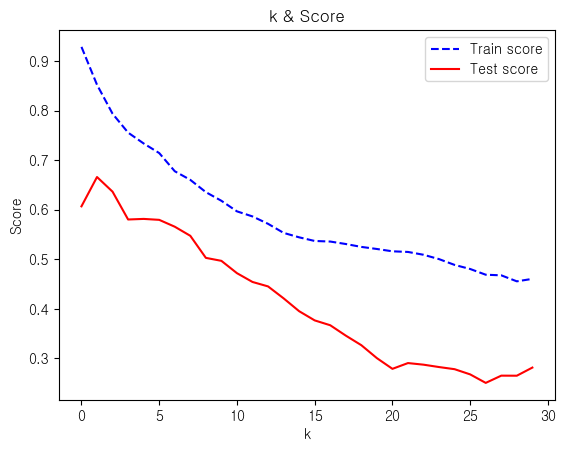

최적의 이웃 개수 k = 2
weight : uniform, metric : manhattan일 때 ===>

MinMaxScaler() => Train Score : 0.85 --- Test Score : 0.67



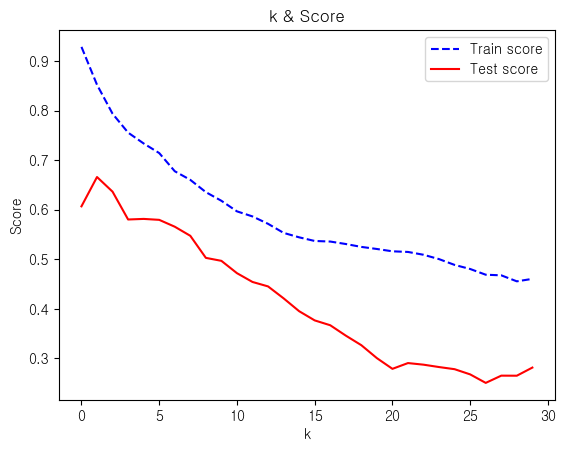

최적의 이웃 개수 k = 2


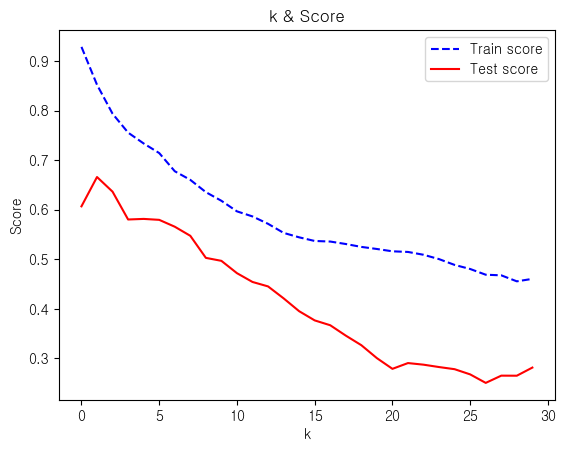

최적의 이웃 개수 k = 2
weight : uniform, metric : nan_euclidean일 때 ===>

MinMaxScaler() => Train Score : 0.85 --- Test Score : 0.66



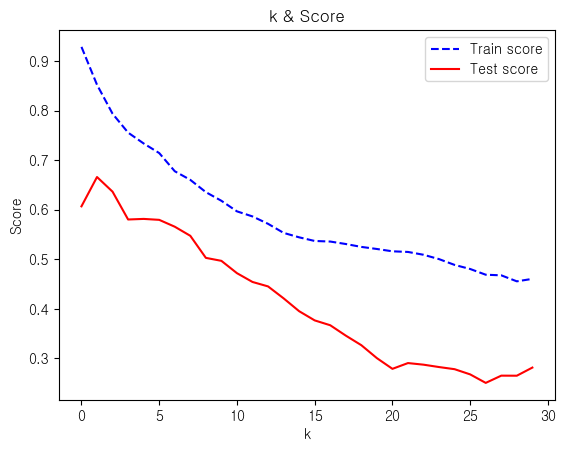

최적의 이웃 개수 k = 2


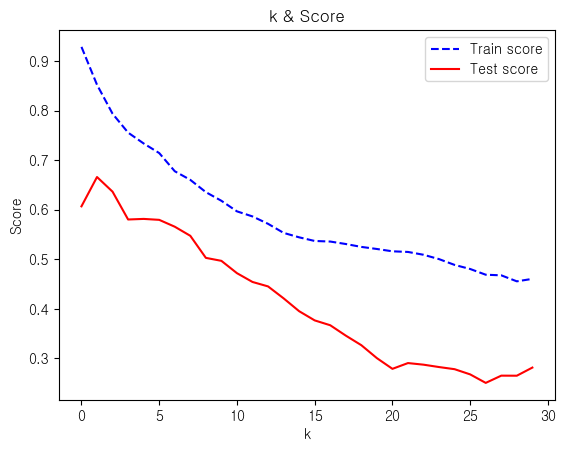

최적의 이웃 개수 k = 2
weight : distance, metric : cityblock일 때 ===>

MinMaxScaler() => Train Score : 0.96 --- Test Score : 0.69



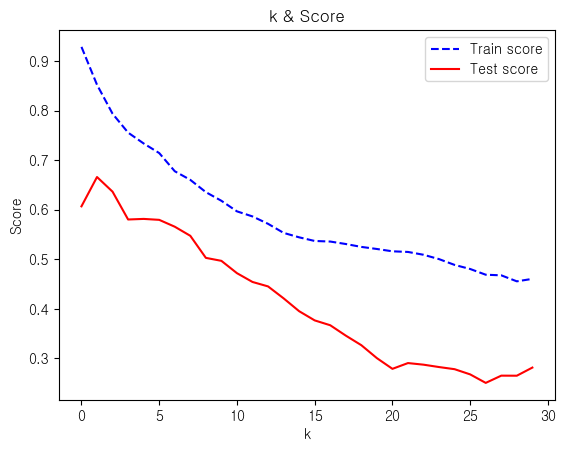

최적의 이웃 개수 k = 2


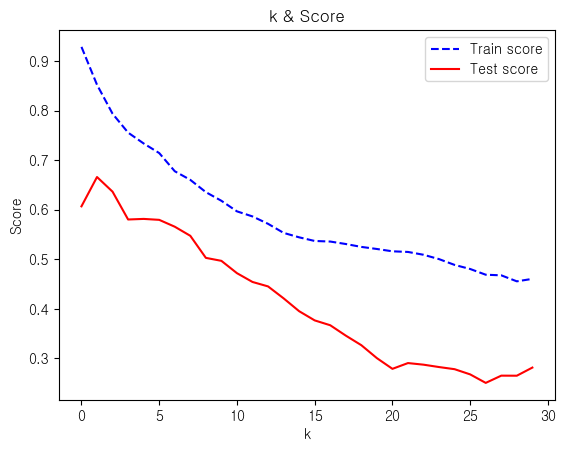

최적의 이웃 개수 k = 2
weight : distance, metric : cosine일 때 ===>

MinMaxScaler() => Train Score : 0.95 --- Test Score : 0.54



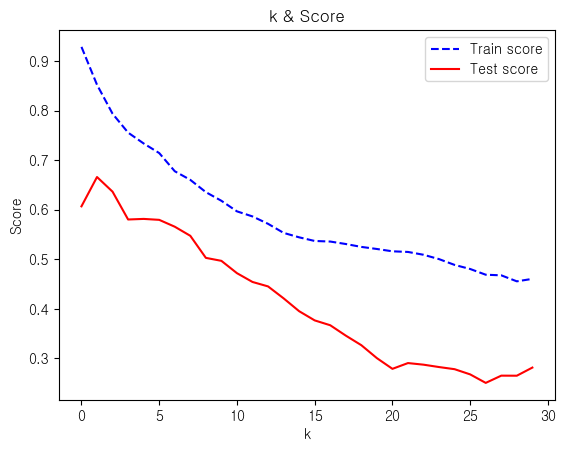

최적의 이웃 개수 k = 2


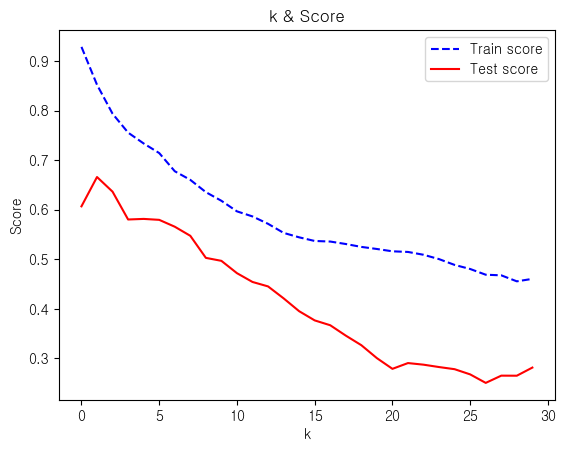

최적의 이웃 개수 k = 2
weight : distance, metric : euclidean일 때 ===>

MinMaxScaler() => Train Score : 0.96 --- Test Score : 0.68



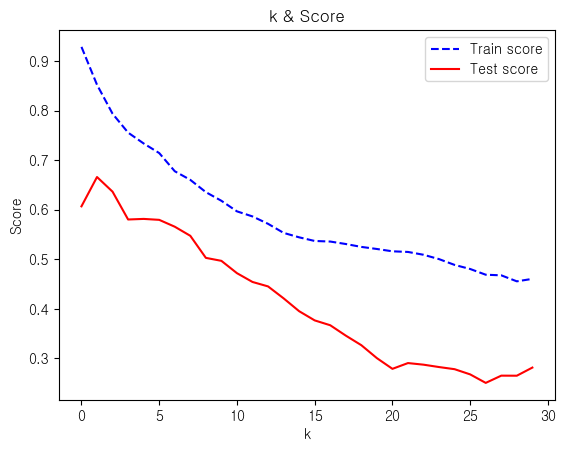

최적의 이웃 개수 k = 2


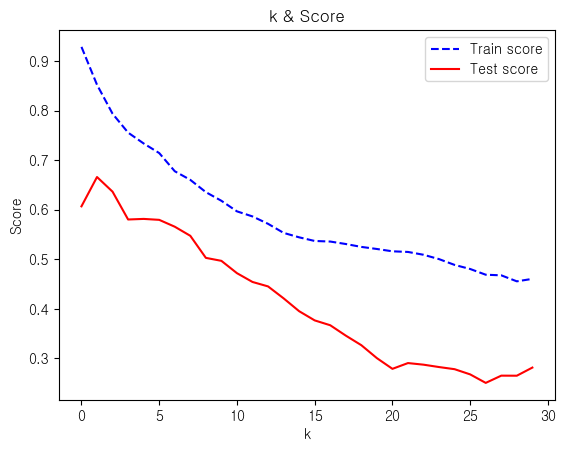

최적의 이웃 개수 k = 2
weight : distance, metric : l1일 때 ===>

MinMaxScaler() => Train Score : 0.96 --- Test Score : 0.69



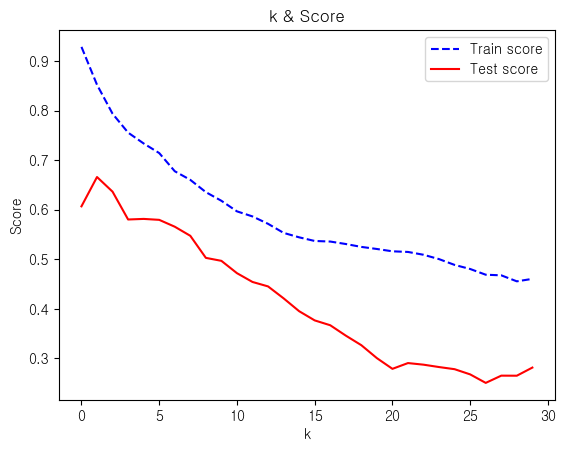

최적의 이웃 개수 k = 2


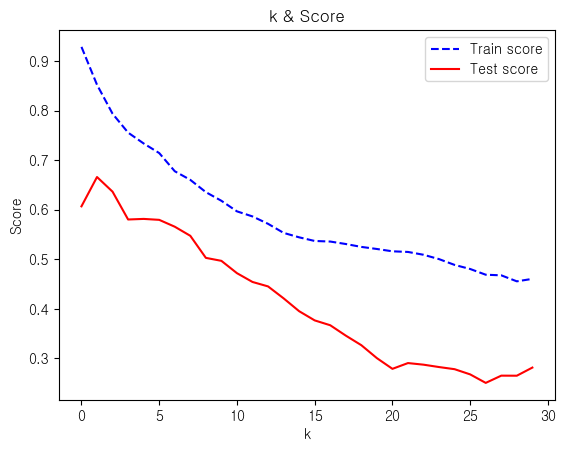

최적의 이웃 개수 k = 2
weight : distance, metric : l2일 때 ===>

MinMaxScaler() => Train Score : 0.96 --- Test Score : 0.68



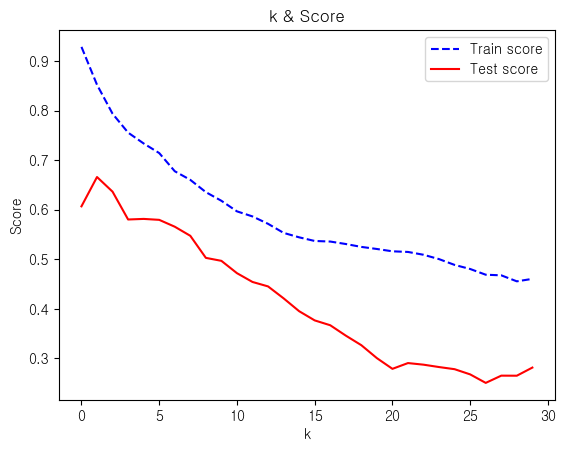

최적의 이웃 개수 k = 2


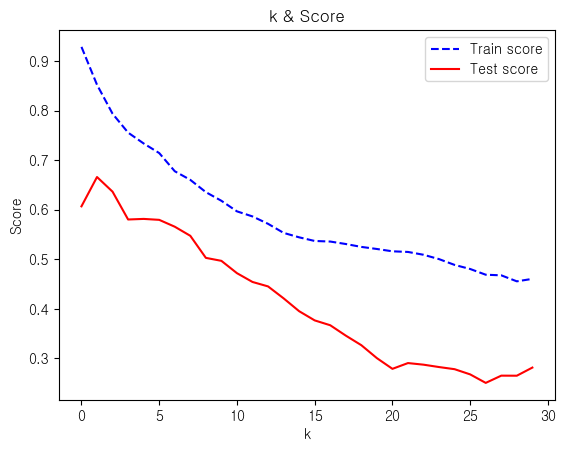

최적의 이웃 개수 k = 2
weight : distance, metric : manhattan일 때 ===>

MinMaxScaler() => Train Score : 0.96 --- Test Score : 0.69



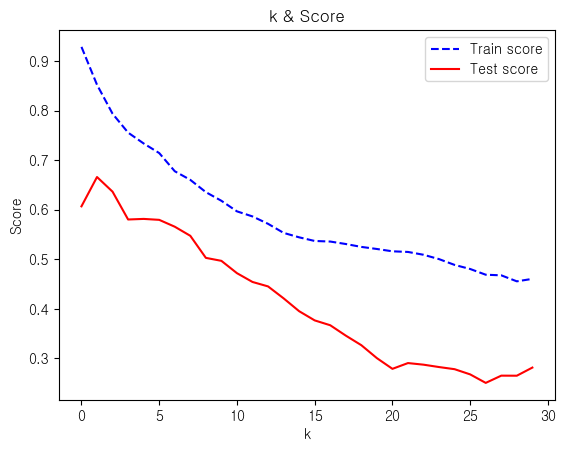

최적의 이웃 개수 k = 2


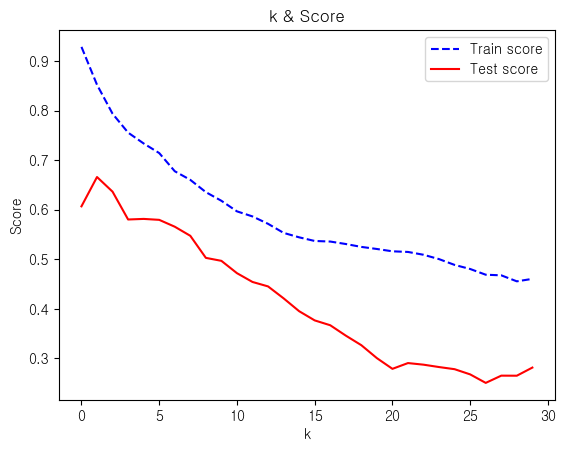

최적의 이웃 개수 k = 2
weight : distance, metric : nan_euclidean일 때 ===>

MinMaxScaler() => Train Score : 0.96 --- Test Score : 0.68



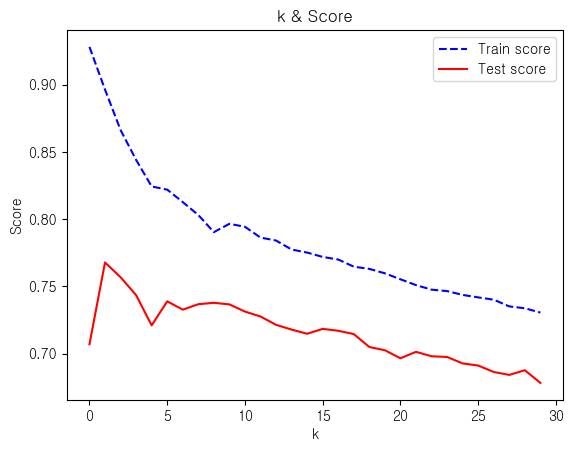

최적의 이웃 개수 k = 2


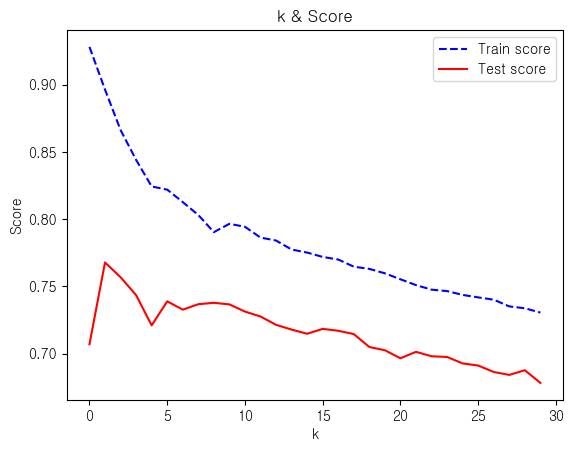

최적의 이웃 개수 k = 2
weight : uniform, metric : cityblock일 때 ===>

RobustScaler() => Train Score : 0.91 --- Test Score : 0.76



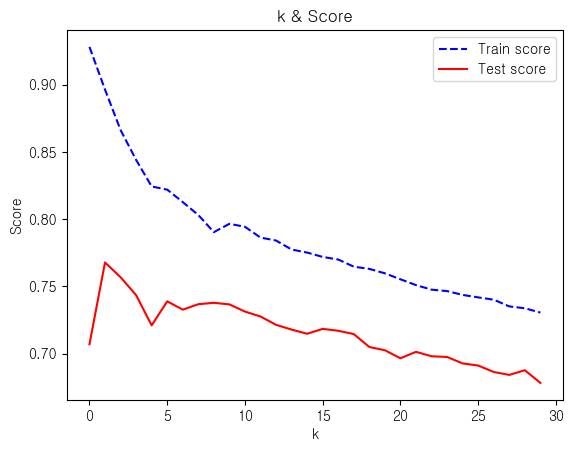

최적의 이웃 개수 k = 2


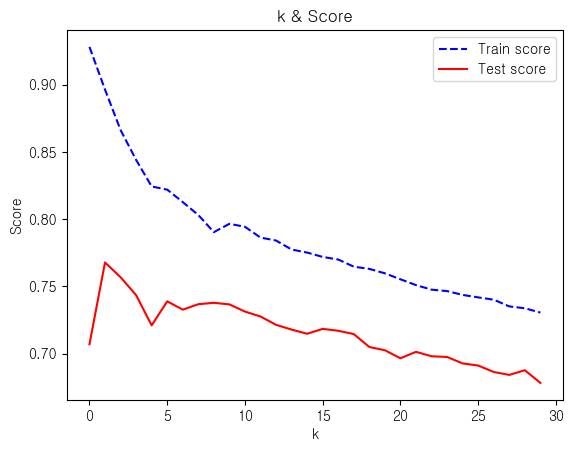

최적의 이웃 개수 k = 2
weight : uniform, metric : cosine일 때 ===>

RobustScaler() => Train Score : 0.89 --- Test Score : 0.61



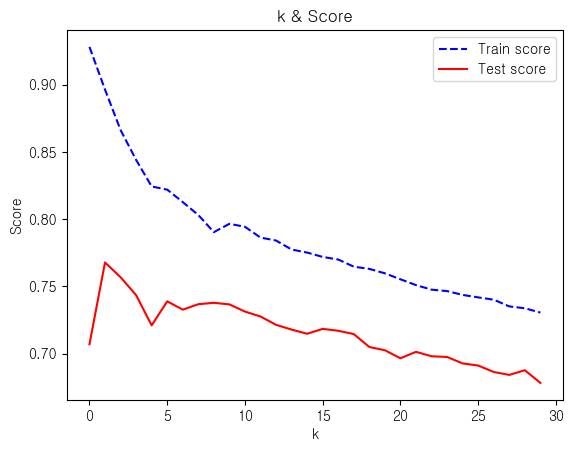

최적의 이웃 개수 k = 2


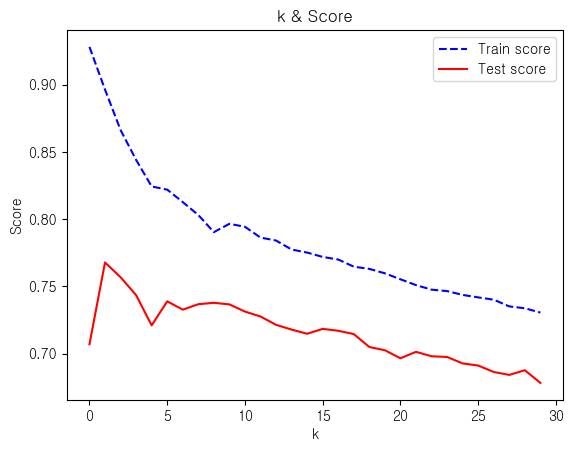

최적의 이웃 개수 k = 2
weight : uniform, metric : euclidean일 때 ===>

RobustScaler() => Train Score : 0.9 --- Test Score : 0.77



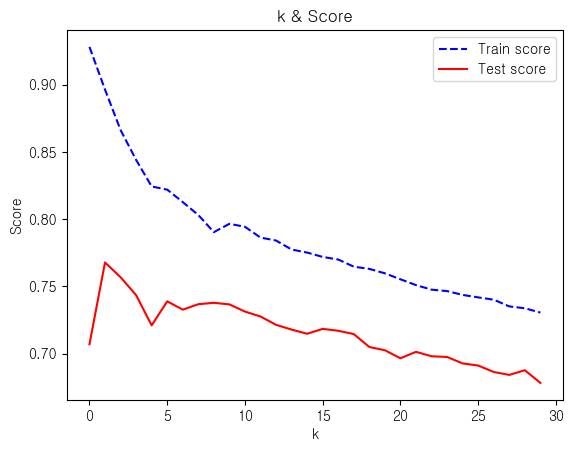

최적의 이웃 개수 k = 2


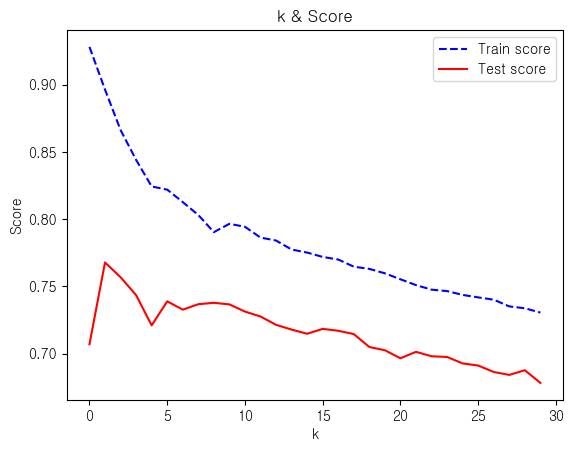

최적의 이웃 개수 k = 2
weight : uniform, metric : l1일 때 ===>

RobustScaler() => Train Score : 0.91 --- Test Score : 0.76



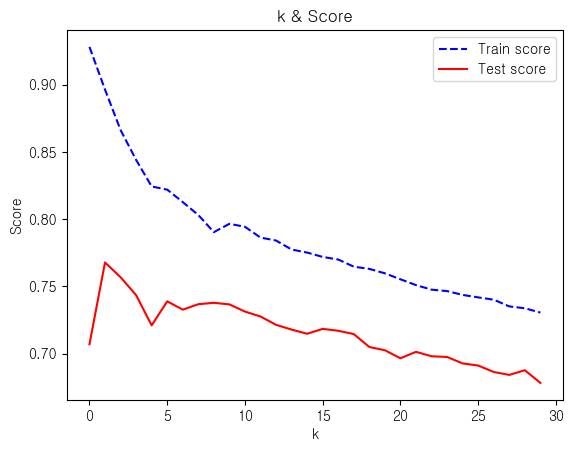

최적의 이웃 개수 k = 2


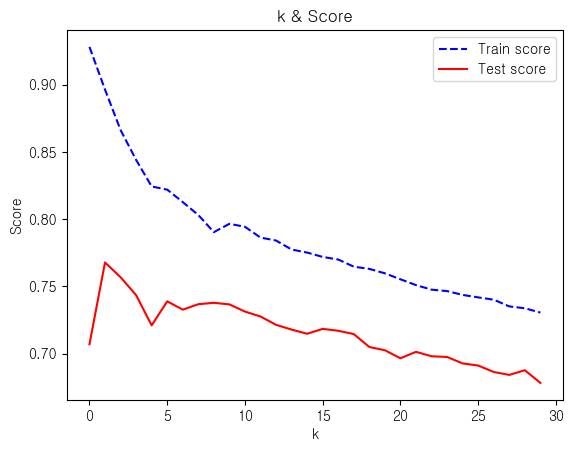

최적의 이웃 개수 k = 2
weight : uniform, metric : l2일 때 ===>

RobustScaler() => Train Score : 0.9 --- Test Score : 0.77



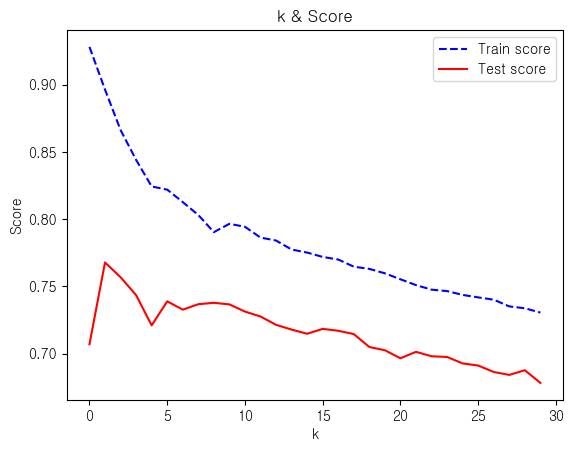

최적의 이웃 개수 k = 2


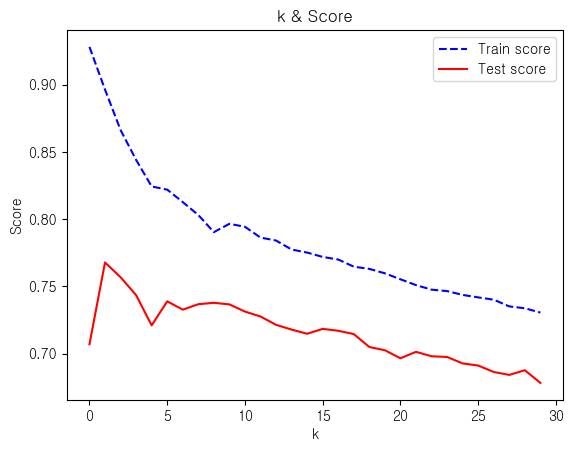

최적의 이웃 개수 k = 2
weight : uniform, metric : manhattan일 때 ===>

RobustScaler() => Train Score : 0.91 --- Test Score : 0.76



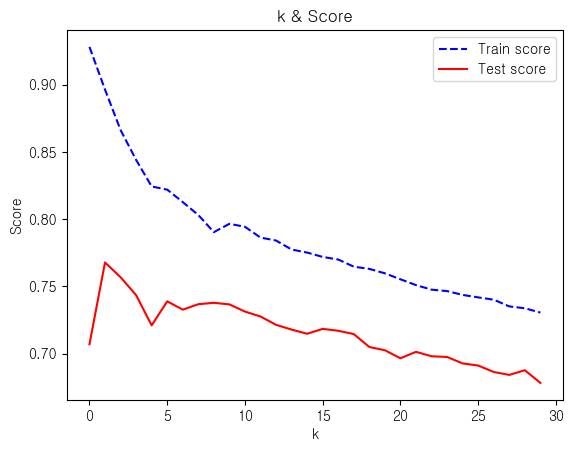

최적의 이웃 개수 k = 2


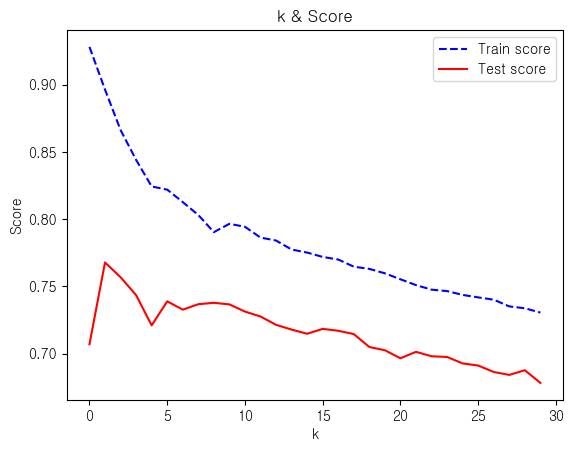

최적의 이웃 개수 k = 2
weight : uniform, metric : nan_euclidean일 때 ===>

RobustScaler() => Train Score : 0.9 --- Test Score : 0.78



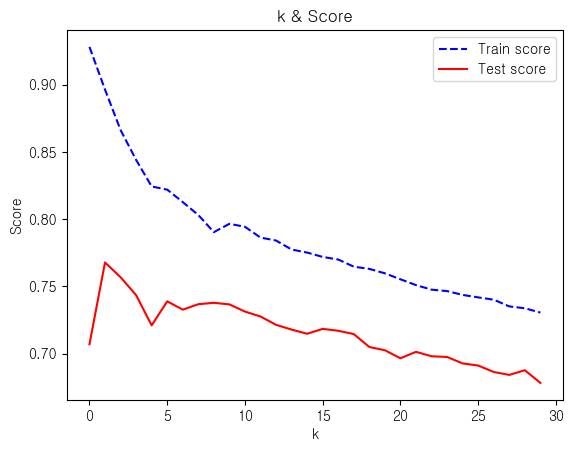

최적의 이웃 개수 k = 2


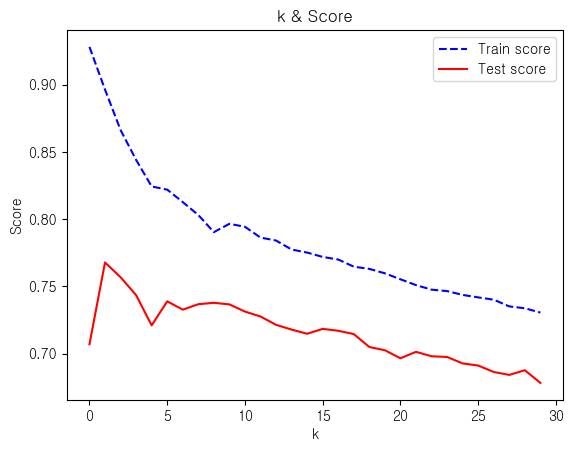

최적의 이웃 개수 k = 2
weight : distance, metric : cityblock일 때 ===>

RobustScaler() => Train Score : 0.96 --- Test Score : 0.78



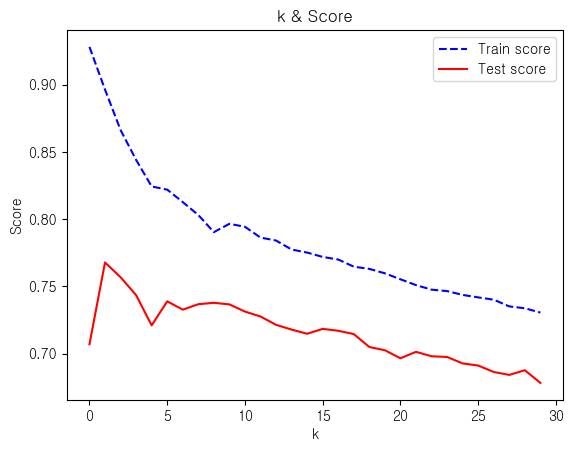

최적의 이웃 개수 k = 2


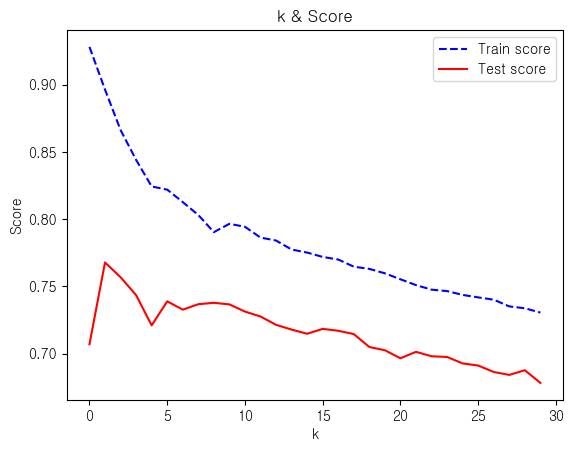

최적의 이웃 개수 k = 2
weight : distance, metric : cosine일 때 ===>

RobustScaler() => Train Score : 0.96 --- Test Score : 0.6



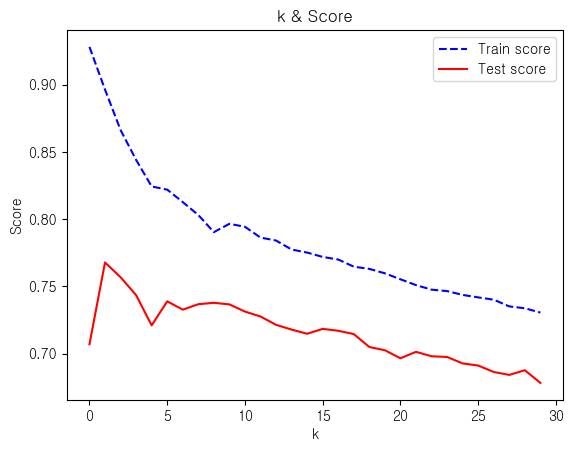

최적의 이웃 개수 k = 2


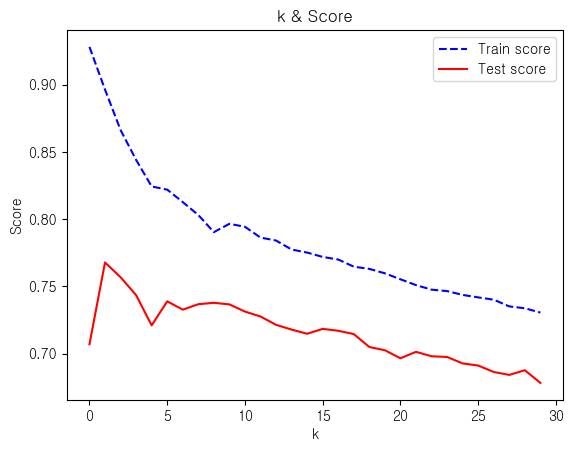

최적의 이웃 개수 k = 2
weight : distance, metric : euclidean일 때 ===>

RobustScaler() => Train Score : 0.96 --- Test Score : 0.79



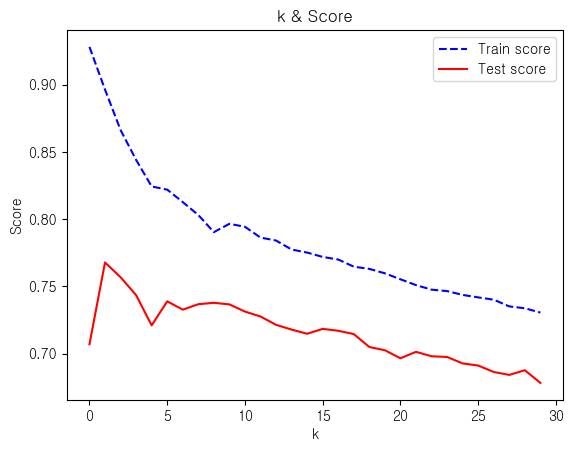

최적의 이웃 개수 k = 2


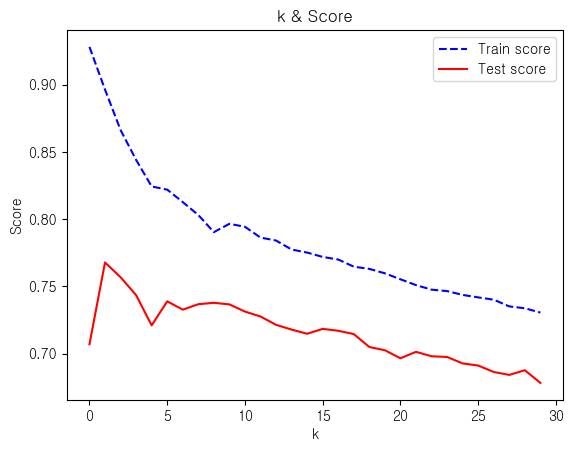

최적의 이웃 개수 k = 2
weight : distance, metric : l1일 때 ===>

RobustScaler() => Train Score : 0.96 --- Test Score : 0.78



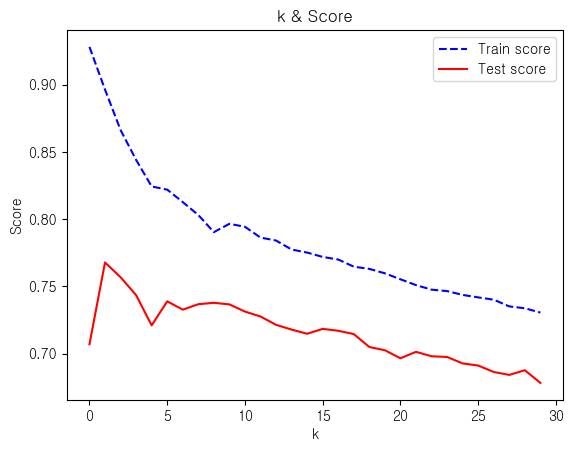

최적의 이웃 개수 k = 2


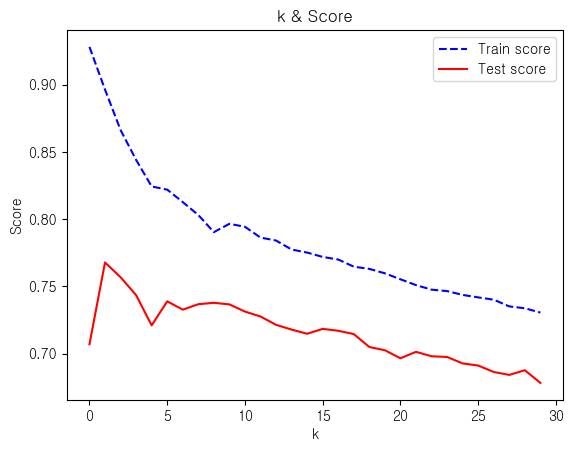

최적의 이웃 개수 k = 2
weight : distance, metric : l2일 때 ===>

RobustScaler() => Train Score : 0.96 --- Test Score : 0.79



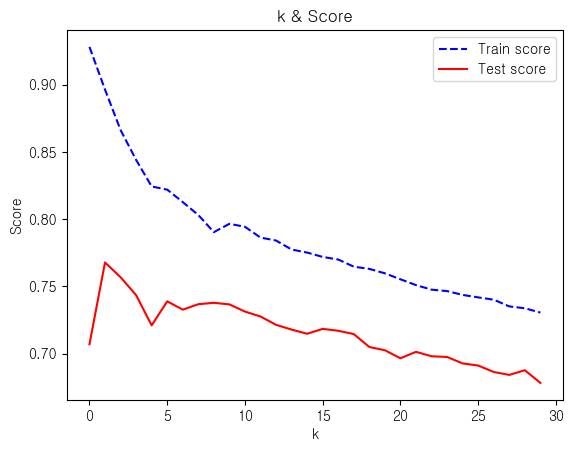

최적의 이웃 개수 k = 2


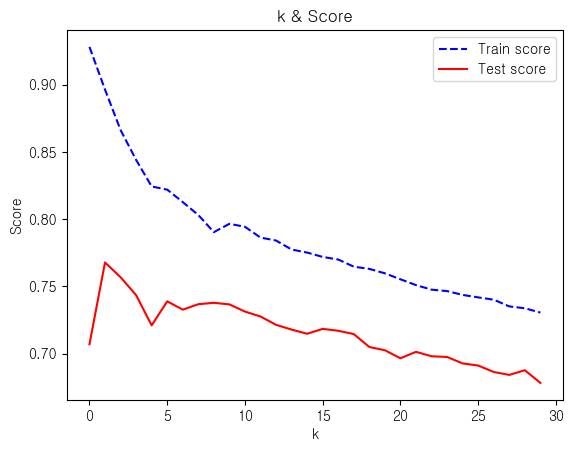

최적의 이웃 개수 k = 2
weight : distance, metric : manhattan일 때 ===>

RobustScaler() => Train Score : 0.96 --- Test Score : 0.78



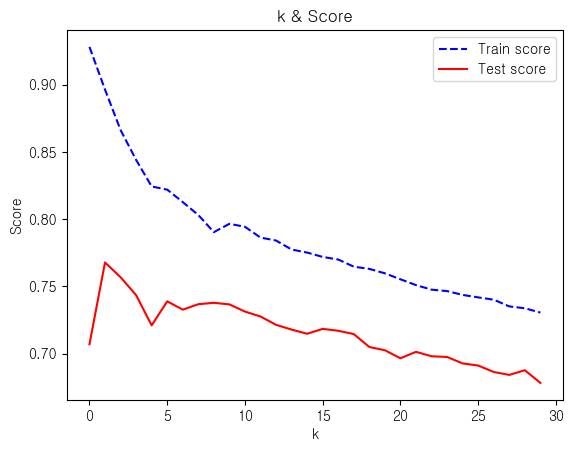

최적의 이웃 개수 k = 2


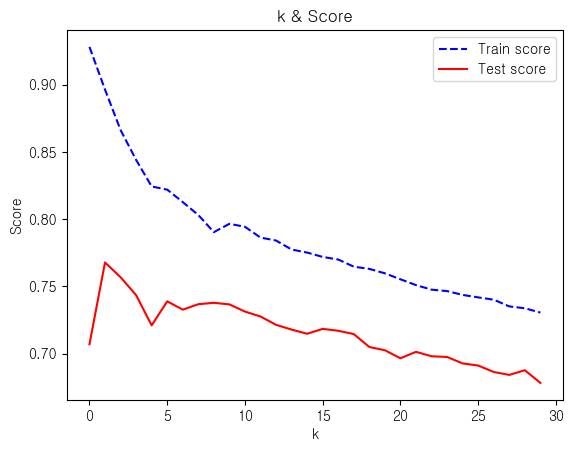

최적의 이웃 개수 k = 2
weight : distance, metric : nan_euclidean일 때 ===>

RobustScaler() => Train Score : 0.96 --- Test Score : 0.79



In [108]:
# KNeighborsClassifier 학습
def main():
    weight_list = ['uniform', 'distance']
    metric_list = ['cityblock', 'cosine', 'euclidean', 'l1', 'l2', 'manhattan', 'nan_euclidean']
    for scaler in [StandardScaler(), MinMaxScaler(), RobustScaler()]:
        for weight in weight_list:
            for metric in metric_list:
                train_score = score_return(['failures', 'Medu', 'Fedu', 'G1', 'G2'], 'G3',
                                        scaler, 30, stratify = targetSR, weights = weight, metric = metric)[0]
                test_score = score_return(['failures', 'Medu', 'Fedu', 'G1', 'G2'], 'G3',
                                        scaler, 30, stratify = targetSR, weights = weight, metric = metric)[1]
                print(f'weight : {weight}, metric : {metric}일 때 ===>\n')
                print(f'{scaler} => Train Score : {train_score} --- Test Score : {test_score}\n')

main()

#### 수치형 데이터와 범주형 데이터를 활용하여 학습 <hr>

- KNeighborsRegressor로 피처 전체를 활용한 학습

In [109]:
student_mathDF.select_dtypes('object')

school sex address famsize Pstatus      Mjob      Fjob  reason guardian  \
0       GP   F       U     GT3       A   at_home   teacher  course   mother   
1       GP   F       U     GT3       T   at_home     other  course   father   
2       GP   F       U     LE3       T   at_home     other   other   mother   
3       GP   F       U     GT3       T    health  services    home   mother   
4       GP   F       U     GT3       T     other     other    home   father   
..     ...  ..     ...     ...     ...       ...       ...     ...      ...   
390     MS   M       U     LE3       A  services  services  course    other   
391     MS   M       U     LE3       T  services  services  course   mother   
392     MS   M       R     GT3       T     other     other  course    other   
393     MS   M       R     LE3       T  services     other  course   mother   
394     MS   M       U     LE3       T     other   at_home  course   father   

    schoolsup famsup paid activities nursery higher internet romantic  
0         yes     no   no         no     yes    yes       no       no  
1          no    yes   no         no      no    yes      yes       no  
2         yes     no  yes         no     yes    yes      yes       no  
3          no    yes  yes        yes     yes    yes      yes      yes  
4          no    yes  yes         no     yes    yes       no       no  
..        ...    ...  ...        ...     ...    ...      ...      ...  
390        no    yes  yes         no     yes    yes       no       no  
391        no     no   no         no      no    yes      yes       no  
392        no     no   no         no      no    yes       no       no  
393        no     no   no         no      no    yes      yes       no  
394        no     no   no         no     yes    yes      yes       no  

[395 rows x 17 columns]

In [110]:
numerical_dataDF = student_mathDF.select_dtypes('int')
categorical_dataDF = student_mathDF.select_dtypes('object')
featureDF = student_mathDF[student_mathDF.columns[:-1]]
targetSR = student_mathDF[student_mathDF.columns[-1]]

X_train, X_test, y_train, y_test = train_test_split(featureDF, targetSR, test_size = 0.2, random_state = 42)

# 수치형 데이터는 표준 정규화, 범주형 데이터는 원핫 인코딩 처리
ct = ColumnTransformer([('scaling', StandardScaler(), numerical_dataDF.columns[:-1]), ('onehot', OneHotEncoder(sparse = False), categorical_dataDF.columns)], remainder = 'passthrough')
ct.fit(X_train)
scaled_X_train = ct.transform(X_train)
scaled_X_test = ct.transform(X_test)

c:\Users\user\.conda\envs\EXAM_MML\lib\site-packages\sklearn\preprocessing\_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


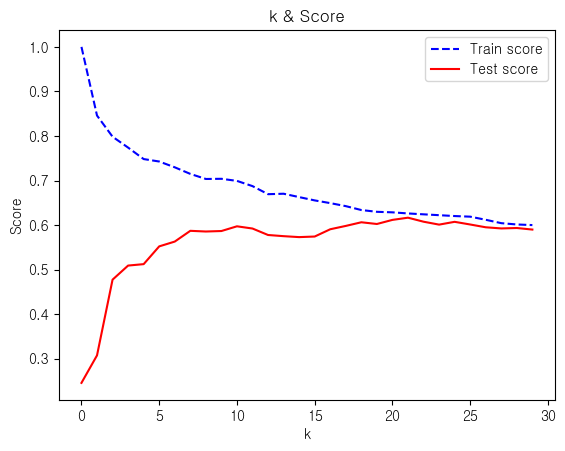

최적의 이웃 개수 k = 22


In [111]:
max_k = 30
train_scoreList = []
test_scoreList = []
for k in range(1, max_k + 1):
    model = KNeighborsRegressor(n_neighbors = k)
    model.fit(scaled_X_train, y_train)
    train_scoreList.append(model.score(scaled_X_train, y_train))
    test_scoreList.append(model.score(scaled_X_test, y_test))

# k에 따른 학습용/테스트용 점수 시각화
plt.plot(train_scoreList, 'b--', label = 'Train score')
plt.plot(test_scoreList, 'r', label = 'Test score')
plt.title('k & Score')
plt.xlabel('k')
plt.ylabel('Score')
plt.legend()
plt.show()

print(f'최적의 이웃 개수 k = {test_scoreList.index(max(test_scoreList))+1}')

In [112]:
model = KNeighborsRegressor(n_neighbors = 22)
model.fit(scaled_X_train, y_train)
model.score(scaled_X_train, y_train), model.score(scaled_X_test, y_test)

(0.6260649101403728, 0.6165215344110656)

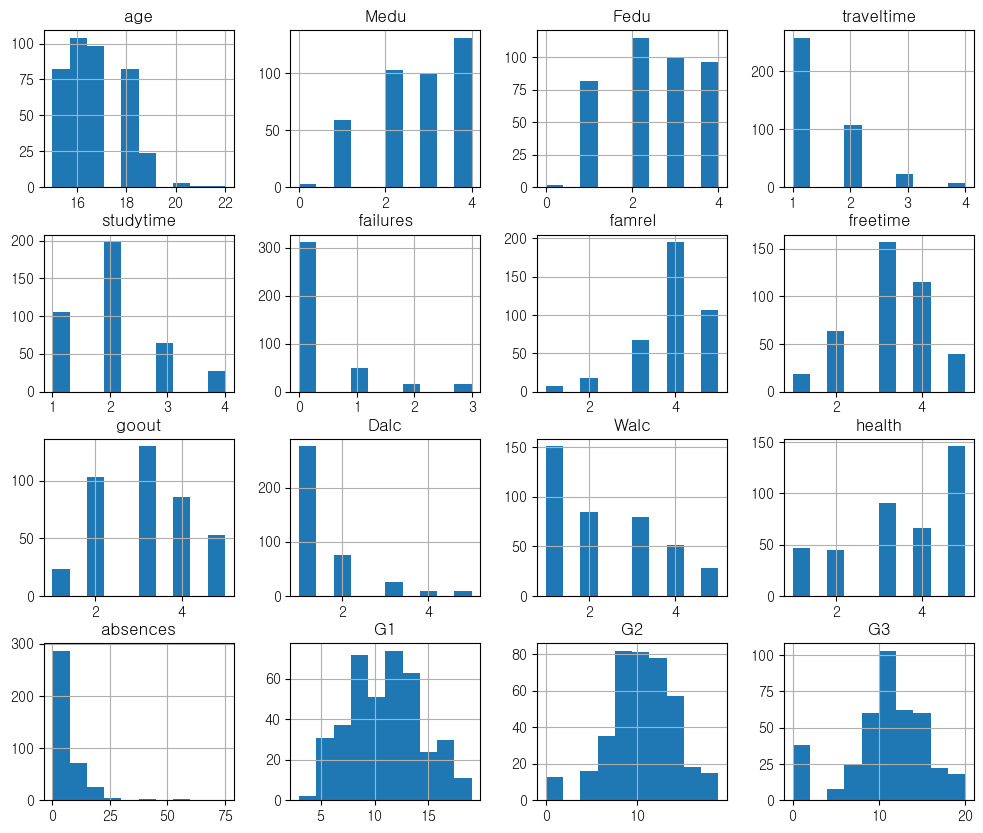

In [113]:
numerical_dataDF.hist(figsize = (12, 10))
plt.show()

In [114]:
numerical_dataDF = student_mathDF.select_dtypes('int')
categorical_dataDF = student_mathDF.select_dtypes('object')
featureDF = student_mathDF[student_mathDF.columns[:-1]]
targetSR = student_mathDF[student_mathDF.columns[-1]]

X_train, X_test, y_train, y_test = train_test_split(featureDF, targetSR, test_size = 0.2, random_state = 42)

# 수치형 데이터는 표준 정규화, 범주형 데이터는 라벨 인코딩 처리
ct = ColumnTransformer([('scaling', StandardScaler(), numerical_dataDF.columns[:-1]), ('ord_enc', OrdinalEncoder(), categorical_dataDF.columns)], remainder = 'passthrough')
ct.fit(X_train)
scaled_X_train = ct.transform(X_train)
scaled_X_test = ct.transform(X_test)

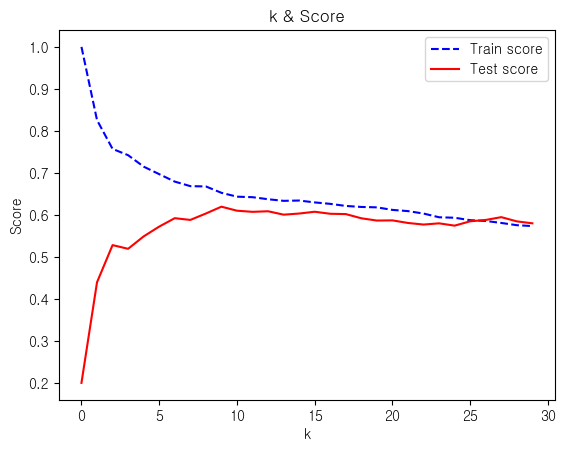

최적의 이웃 개수 k = 10


In [115]:
max_k = 30
train_scoreList = []
test_scoreList = []
for k in range(1, max_k + 1):
    model = KNeighborsRegressor(n_neighbors = k)
    model.fit(scaled_X_train, y_train)
    train_scoreList.append(model.score(scaled_X_train, y_train))
    test_scoreList.append(model.score(scaled_X_test, y_test))

# k에 따른 학습용/테스트용 점수 시각화
plt.plot(train_scoreList, 'b--', label = 'Train score')
plt.plot(test_scoreList, 'r', label = 'Test score')
plt.title('k & Score')
plt.xlabel('k')
plt.ylabel('Score')
plt.legend()
plt.show()

print(f'최적의 이웃 개수 k = {test_scoreList.index(max(test_scoreList))+1}')

### (2) Student-por.csv

In [116]:
file_data2 = '../DATA/student-por.csv'
student_porDF = pd.read_csv(file_data2, sep = ';')
student_porDF.shape

(649, 33)

In [117]:
student_porDF = pd.read_csv(file_data2, sep = ';')
student_porDF.head()

school sex  age address famsize Pstatus  Medu  Fedu     Mjob      Fjob  ...  \
0     GP   F   18       U     GT3       A     4     4  at_home   teacher  ...   
1     GP   F   17       U     GT3       T     1     1  at_home     other  ...   
2     GP   F   15       U     LE3       T     1     1  at_home     other  ...   
3     GP   F   15       U     GT3       T     4     2   health  services  ...   
4     GP   F   16       U     GT3       T     3     3    other     other  ...   

  famrel freetime  goout  Dalc  Walc health absences  G1  G2  G3  
0      4        3      4     1     1      3        4   0  11  11  
1      5        3      3     1     1      3        2   9  11  11  
2      4        3      2     2     3      3        6  12  13  12  
3      3        2      2     1     1      5        0  14  14  14  
4      4        3      2     1     2      5        0  11  13  13  

[5 rows x 33 columns]

In [118]:
student_porDF.shape

(649, 33)

In [119]:
student_porDF.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 649 entries, 0 to 648
Data columns (total 33 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   school      649 non-null    object
 1   sex         649 non-null    object
 2   age         649 non-null    int64 
 3   address     649 non-null    object
 4   famsize     649 non-null    object
 5   Pstatus     649 non-null    object
 6   Medu        649 non-null    int64 
 7   Fedu        649 non-null    int64 
 8   Mjob        649 non-null    object
 9   Fjob        649 non-null    object
 10  reason      649 non-null    object
 11  guardian    649 non-null    object
 12  traveltime  649 non-null    int64 
 13  studytime   649 non-null    int64 
 14  failures    649 non-null    int64 
 15  schoolsup   649 non-null    object
 16  famsup      649 non-null    object
 17  paid        649 non-null    object
 18  activities  649 non-null    object
 19  nursery     649 non-null    object
 20  higher    